# Car crashes and weather

By Anthony Gerbier and Mathias Pisch

# Introduction

## Motivations

The objective of this study is to investigate the primary factors contributing to road accidents, with a particular focus on meteorological conditions.

Weather plays a crucial role in driver attention. Most drivers can recall days when heavy rainfall required heightened caution on the road. Similarly, media reports frequently highlight road conditions during snowfall in urban areas, such as Paris, where accident rates tend to increase.

Since changing weather conditions directly affect driving difficulty, it is natural to ask how they influence the occurrence of traffic accidents. Are certain weather conditions associated with a higher risk of accidents? To what extent do extreme weather events impact road safety?

These questions form the core of this study.

## Scientific Approach

To address these questions, we focus on a well-defined geographical area: Montgomery County, Maryland, chosen for its rich and detailed traffic accident dataset. Our aim is to identify the main factors contributing to road accidents, with a particular emphasis on weather. The study follows a structured experimental procedure.

First, the dataset undergoes thorough preprocessing to ensure completeness and consistency. This includes cleaning, handling missing values, and standardizing formats. Once prepared, the dataset is enriched with high-resolution meteorological data obtained via API calls. To respect API request limits and maintain efficiency, we perform this enrichment on a representative sample of Montgomery County accident records.

Next, we perform descriptive statistical analyses to explore the dataset, examine variable distributions, and identify potential patterns or correlations, particularly between weather variables and accident occurrences.

Finally, we proceed to a modeling stage aimed at quantifying the effect of weather on road accidents. Focusing on causal inference, we seek to determine whether specific weather conditions increase the likelihood of accidents, and to what extent. Regression-based methods are employed to estimate the marginal effect of each weather variable while controlling for other relevant factors. The ultimate goal is to provide a robust, data-driven understanding of how weather conditions influence road safety.

<a id="summary"></a>
## Summary
- [I. Installation](#installation)
- [II. Data Preparation](#data_preparation)
  - [1. Addresses](#url)
  - [2. Car Accidents in Maryland](#car_accidents)
    - [Loading](#download)
    - [Cleaning](#cleaning)
    - [Sampling](#sample)
  - [3. Weather Data](#weather)
    - [API Calls](#weather_api)
    - [Day/Night Variable](#day_or_night)
  - [4. Spatio-Temporal Grid](#grid)
    - [Grid creation](#grid_creation)
    - [API Calls](#grid_api)
    - [Average Values](#grid_average)
- [III. Descriptive Analysis](#descriptive)
  - [1. Construction of categorical variables](#categorical)
  - [2. Preliminary analysis of the new variables](#weather_analysis)
  - [3. Correlation between night and the percentage of accident with Driver Substance Abuse](#drogue)
  - [4. Plotting area map with multiple conditions ](#map)
  - [5. Descriptive Analysis of Injury Severity](#injury_desc)
  - [6. Weather and number of car crashes par day ](#crashes_per_day)

- [IV. Modeling](#modeling)
  - [1. Standardization of variables](#centrage)
  - [2. Multiple Linear Regression Analysis](#linear)
  - [3. Ordinal Regression Analysis](#ordinal)
  - [4. Regression of Daily Accidents](#daily_reg)
  - [5. Count-Based Modeling of Daily Accident Frequency](#count)

- [Conclusion and Perspectives](#conclusion)


<a id="installation"></a>
# I. Installation


## Libraries 

In [3]:
!pip install -r requirements.txt

  Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
  Using cached shapely-2.0.7-cp39-cp39-macosx_10_9_x86_64.whl (1.5 MB)
  Using cached pyogrio-0.11.1.tar.gz (287 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [25 lines of output]
      Traceback (most recent call last):
        File "/Users/mathiaspisch/opt/anaconda3/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 363, in <module>
          main()
        File "/Users/mathiaspisch/opt/anaconda3/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 345, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/Users/mathiaspisch/opt/anaconda3/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 164

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import geopandas as gpd
import openmeteo_requests
import requests_cache
import numpy as np
import calendar 
import time 
import folium
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nbformat

ModuleNotFoundError: No module named 'geopandas'

<a id="data_preparation"></a>
# II. Data Preparation
<a id="url"></a>
## I.1 Adresses

In [34]:
car_accidents_url = "https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.csv?accessType=DOWNLOAD"

## I.2 Car accidents in Montgomery County, Maryland <a id="car_accidents"></a>

The Crash Reporting – Drivers Data dataset from Montgomery County, Maryland, provides detailed information on motor vehicle drivers involved in traffic collisions occurring on county and local roadways. The dataset is compiled from the Automated Crash Reporting System (ACRS) of the Maryland State Police and includes reports submitted by multiple law enforcement agencies within the county, such as the Montgomery County Police and municipal police departments. It captures a wide range of variables related to crash events and driver characteristics, including collision context, driver behavior, and other attributes relevant to analysis of road safety. Because these reports are updated on a weekly basis and can be linked with other crash-related datasets via a common report identifier, the dataset offers a rich, longitudinal source of empirical data for studying patterns of traffic accidents and their determinants. Its granularity and scope make it particularly well-suited for investigating how meteorological conditions and other factors relate to accident severity and frequency within a defined geographic area. 

### I.2.i Download <a id="download"></a>


In [12]:
# this database takes approximately 2 to 4 min to download

bigbase = pd.read_csv(car_accidents_url)

bigbase.head()


/var/folders/5v/9b211qsj52sgwg1mx65bdc9m0000gn/T/ipykernel_61179/2413776474.py:5: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  bigbase = pd.read_csv(car_accidents_url)


Report Number Local Case Number Agency Name       ACRS Report Type  \
0   MCP3296002G         240018653  MONTGOMERY  Property Damage Crash   
1   MCP276700BF         240012321  MONTGOMERY  Property Damage Crash   
2   MCP32790038         240022955  MONTGOMERY  Property Damage Crash   
3   MCP34000014         240019831  MONTGOMERY  Property Damage Crash   
4   MCP3341003F         240011829  MONTGOMERY           Injury Crash   

          Crash Date/Time              Route Type             Road Name  \
0  04/21/2024 06:53:00 PM            County Route                   NaN   
1  03/14/2024 05:23:00 PM              US (State)  COLUMBIA PIKE (SB/L)   
2  05/15/2024 07:30:00 AM  Maryland (State) Route  VEIRS MILL RD (WB/L)   
3  04/28/2024 05:30:00 PM            County Route            HARDING DR   
4  03/12/2024 07:30:00 AM           Private Route                   NaN   

  Cross-Street Name Off-Road Description Municipality  ... Vehicle Going Dir  \
0               NaN                  NaN          NaN  ...        Northbound   
1               NaN                  NaN          NaN  ...        Southbound   
2               NaN                  NaN          NaN  ...        Northbound   
3               NaN                  NaN          NaN  ...        Southbound   
4   CONNECTICUT AVE                  NaN          NaN  ...        Southbound   

  Speed Limit Driverless Vehicle Parked Vehicle Vehicle Year Vehicle Make  \
0          25                 No             No         2013      HYUNDAI   
1          45                 No             No            0          NaN   
2          45                 No             No         2006    CHEVROLET   
3          25                 No             No         2012       NISSAN   
4          35                 No            NaN         2015    CHEVROLET   

  Vehicle Model   Latitude  Longitude                     Location  
0        SONATA  39.105339 -76.989845  (39.10533874, -76.98984545)  
1           NaN  39.040003 -76.997223  (39.04000338, -76.99722287)  
2        COBALT  39.073096 -77.111254    (39.0730963, -77.1112541)  
3        ALTIMA  39.021944 -77.018300  (39.02194389, -77.01829961)  
4     SILVERADO  39.090304 -77.071180  (39.09030389, -77.07118035)  

[5 rows x 39 columns]

#### Version locale

In [4]:
"""import pandas as pd
import numpy as np

# Downloading the database
bigbase = pd.read_csv("Crash_Reporting_-_Drivers_Data.csv")

bigbase.head()"""

'import pandas as pd\nimport numpy as np\n\n# Downloading the database\nbigbase = pd.read_csv("Crash_Reporting_-_Drivers_Data.csv")\n\nbigbase.head()'

### I.2.ii Cleaning <a id="cleaning"></a>


In this section, we perform a comprehensive cleaning of the dataset to ensure its reliability and suitability for subsequent statistical analyses.

We begin by examining the structure of the dataset, with particular attention to the available variables, their data types, and their completeness. This initial inspection allows us to identify columns that are essential for the objectives of the study, as well as those that may be redundant or insufficiently documented.

Next, we remove observations containing missing values in key variables. These variables are defined based on their relevance to the analysis, particularly those related to accident characteristics, temporal information, location, and weather conditions. Since incomplete records may introduce bias or reduce statistical power, rows with missing values in these critical fields are excluded from the analysis.

Finally, we address the presence of outliers. Given that this dataset is compiled from police accident reports, reporting or data entry errors are possible. Such errors may result in implausible or extreme values that do not reflect real-world conditions. We therefore identify and remove outliers using statistically motivated criteria, ensuring that the remaining observations fall within realistic and interpretable ranges.

#### Column Analysis

This subsection examines the values of each column in order to identify variable types (e.g., numerical or categorical) and assess the frequency of non-missing observations within the dataset.

In [13]:
bigbase.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault',
       'Injury Severity', 'Circumstance', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [14]:
all_unique = bigbase['Local Case Number'].is_unique
print(all_unique)

False


In [16]:
bigbase['Report Number'].value_counts()

Report Number
MCP229800RC    10
MCP32800050     9
MCP2693003Q     9
MCP12130045     9
MCP28810040     8
               ..
EJ7851001Z      1
MCP3085003B     1
MCP3117000W     1
MCP3024000Z     1
MCP120500DJ     1
Name: count, Length: 117105, dtype: int64

In [8]:
bigbase["Crash Date/Time"].value_counts()

Crash Date/Time
12/10/2018 06:10:00 PM    11
06/09/2020 06:53:00 PM    10
03/03/2017 06:00:00 AM    10
03/28/2019 09:30:00 AM    10
02/24/2017 04:30:00 PM     9
                          ..
12/06/2016 02:50:00 PM     1
12/07/2025 03:33:00 AM     1
12/11/2025 02:23:00 AM     1
12/15/2025 02:50:00 PM     1
12/10/2025 05:00:00 PM     1
Name: count, Length: 114243, dtype: int64

In [17]:
bigbase["Weather"].value_counts()

Weather
CLEAR                                116780
Clear                                 27945
RAINING                               20609
CLOUDY                                17295
Rain                                   3681
Cloudy                                 3187
SNOW                                   1444
UNKNOWN                                 693
FOGGY                                   676
WINTRY MIX                              391
OTHER                                   370
Snow                                    317
Unknown                                 234
SLEET                                   218
SEVERE WINDS                            154
BLOWING SNOW                            115
Blowing Snow                             76
Fog, Smog, Smoke                         64
Freezing Rain Or Freezing Drizzle        53
Severe Crosswinds                        27
BLOWING SAND, SOIL, DIRT                 15
Sleet Or Hail                            14
Name: count, dtype: int6

We observe that the weather variable does not provide quantitative information, preventing the assessment of whether meteorological conditions were exceptional. Consequently, enriching the dataset with quantitative weather variables obtained via an external API is both relevant and necessary.

In [18]:
bigbase["Circumstance"]

0                                                       NaN
1                                                       NaN
2                                                       NaN
3                                                       NaN
4                                                       NaN
                                ...                        
207709                                                  NaN
207710                                                  NaN
207711    Followed Too Closely, Operated Motor Vehicle i...
207712                                                  NaN
207713                                                  NaN
Name: Circumstance, Length: 207714, dtype: object

The circumstance variable is an example of a feature that will not be exploited in this study, as its values are highly qualitative and a large proportion of observations are missing, limiting its usefulness for quantitative analysis.

In [19]:
bigbase["Driver Distracted By"].value_counts()

Driver Distracted By
NOT DISTRACTED                                       106718
UNKNOWN                                               32803
Not Distracted                                        23491
LOOKED BUT DID NOT SEE                                21546
Unknown                                                8405
INATTENTIVE OR LOST IN THOUGHT                         4320
OTHER DISTRACTION                                      3245
Other Action (looking away from task, etc.)             991
DISTRACTED BY OUTSIDE PERSON OBJECT OR EVENT            970
BY OTHER OCCUPANTS                                      418
OTHER CELLULAR PHONE RELATED                            372
OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)       325
TALKING OR LISTENING TO CELLULAR PHONE                  282
NO DRIVER PRESENT                                       279
BY MOVING OBJECT IN VEHICLE                             212
EATING OR DRINKING                                      196
ADJUSTING AUDIO AND

The driver distracted by variable exhibits a very high diversity of values, indicating substantial heterogeneity in the recorded categories. While it may be used in the analysis, it is not considered a fundamental variable for this study.

In [21]:
bigbase["Injury Severity"].value_counts()

Injury Severity
NO APPARENT INJURY          141196
No Apparent Injury           27437
POSSIBLE INJURY              17481
SUSPECTED MINOR INJURY       11871
Suspected Minor Injury        3012
Possible Injury               2431
SUSPECTED SERIOUS INJURY      1414
Suspected Serious Injury       284
FATAL INJURY                   154
Fatal Injury                    37
Name: count, dtype: int64

The injury severity variable contains sufficiently explicit values to allow the creation of a categorical variable. This will enable the study of the effect of weather conditions on accident severity.

#### Removal of Rows with Missing Values

The most critical variables to monitor for missing values are Latitude and Longitude. Ensuring these fields are populated is essential, as valid coordinates are required for joining the dataset with external meteorological data via API calls.

In [22]:
subset = ["Latitude", "Longitude", "Vehicle Year", "Speed Limit", "Injury Severity", "Driver Substance Abuse"] # columns we want to clean

bigbase_clean = bigbase.dropna(subset=subset)

# Quick conclusion of the amount of row dropped : 
rows_dropped = len(bigbase) - len(bigbase_clean)
percentage = (rows_dropped / len(bigbase)) * 100
print(f"{rows_dropped} rows dropped ({percentage:.2f}% of the rows)")

33717 rows dropped (16.23% of the rows)


In [23]:
bigbase_clean[subset].head()

Latitude  Longitude  Vehicle Year  Speed Limit     Injury Severity  \
1   39.040003 -76.997223             0           45  No Apparent Injury   
4   39.090304 -77.071180          2015           35  No Apparent Injury   
6   39.074780 -77.005133          2015           40  No Apparent Injury   
9   39.143230 -77.200655          2014           30  No Apparent Injury   
11  38.979433 -77.009016          2003           25  No Apparent Injury   

                               Driver Substance Abuse  
1                                    Unknown, Unknown  
4                                    Unknown, Unknown  
6   Not Suspect of Alcohol Use, Not Suspect of Dru...  
9   Not Suspect of Alcohol Use, Not Suspect of Dru...  
11                                   Unknown, Unknown

#### Analysis and Outlier Removal


We will examine the following variables: Latitude, Longitude, Vehicle Year, Speed Limit, Injury Severity, and Driver Substance Abuse to ensure that they do not contain implausible values (e.g., coordinates outside the state, inconsistent vehicle years, or other anomalous entries).

This step excludes observations with coordinates located outside the study county.

In [24]:
lat_min = 38.934343
lat_max = 39.353502
lon_min = -77.52768
lon_max = -76.888505

# Créer une copie filtrée pour éviter le SettingWithCopyWarning
bigbase_clean_step2 = bigbase_clean[
    (bigbase_clean['Latitude'] >= lat_min) &
    (bigbase_clean['Latitude'] <= lat_max) &
    (bigbase_clean['Longitude'] >= lon_min) &
    (bigbase_clean['Longitude'] <= lon_max)
].copy()

# Afficher le nombre de lignes supprimées
rows_removed = len(bigbase_clean) - len(bigbase_clean_step2)
print(f"Rows removed: {rows_removed} ({rows_removed / len(bigbase_clean) * 100:.2f}% of total)")
print(f"Rows remaining: {len(bigbase_clean_step2)}")


Rows removed: 153 (0.09% of total)
Rows remaining: 173844


We will now generate a diagram illustrating the frequency of each value for the selected variables. This visualization provides an overview of their distributions and also serves as a quick method for identifying potential outliers.

In [25]:

def plot_value_counts(df, variable, color='skyblue', figsize=(10,6)):
    """
    Plot a bar chart showing all unique values of a variable and their counts.

    Parameters:
    df : pandas.DataFrame
        The DataFrame containing the data.
    variable : str
        The name of the variable to analyze.
    color : str, optional
        Color of the bars (default is 'skyblue').
    figsize : tuple, optional
        Figure size (default is (10,6)).

    Returns:
    None
    """
    # Count the occurrences of each unique value
    value_counts = df[variable].value_counts().sort_index()

    # Plot the bar chart
    plt.figure(figsize=figsize)
    plt.bar(value_counts.index.astype(str), value_counts.values, color=color)
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.title(f'Value counts of {variable}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Plotting value counts for: Vehicle Year


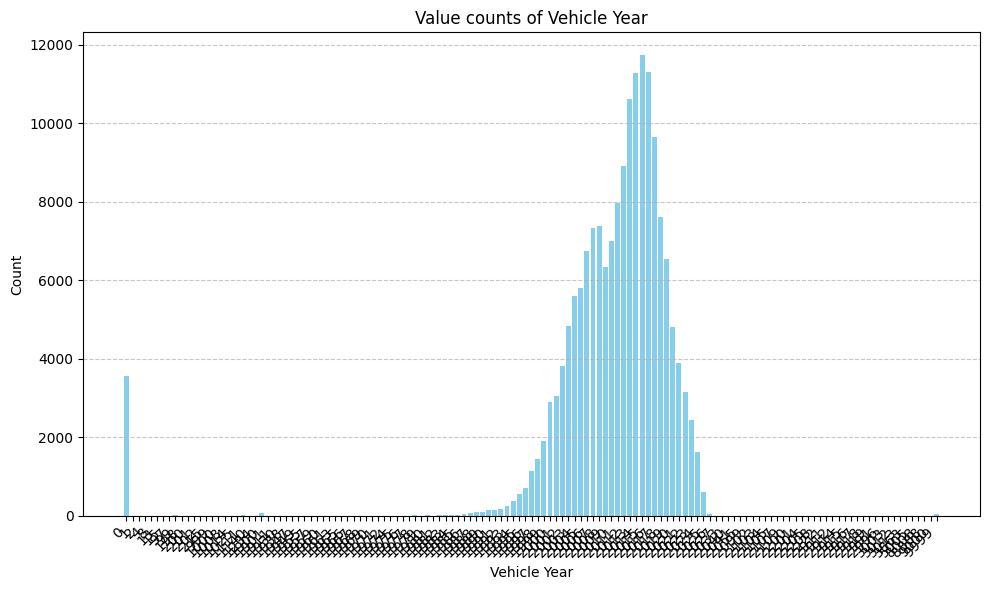

Plotting value counts for: Speed Limit


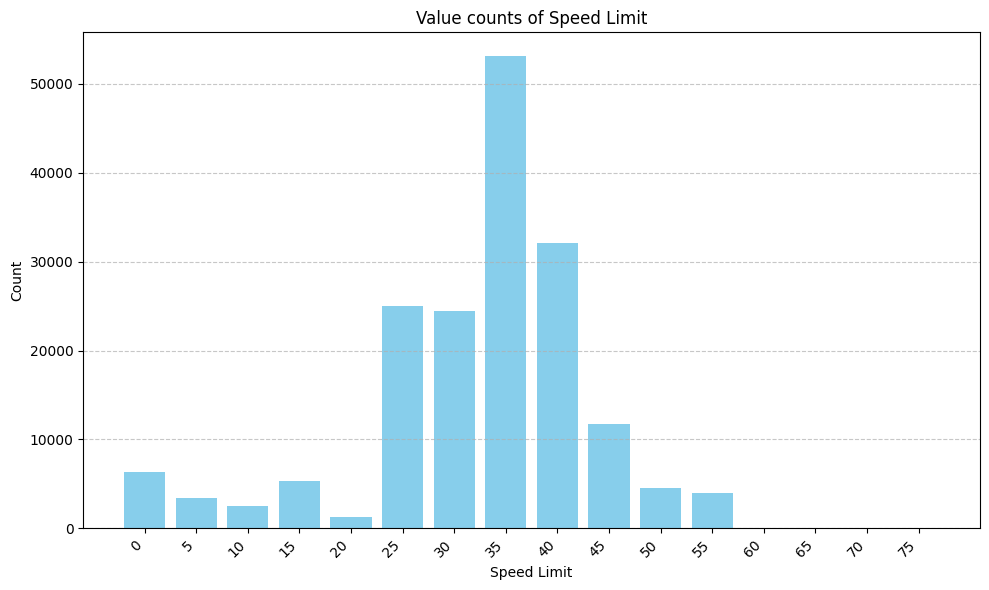

Plotting value counts for: Injury Severity


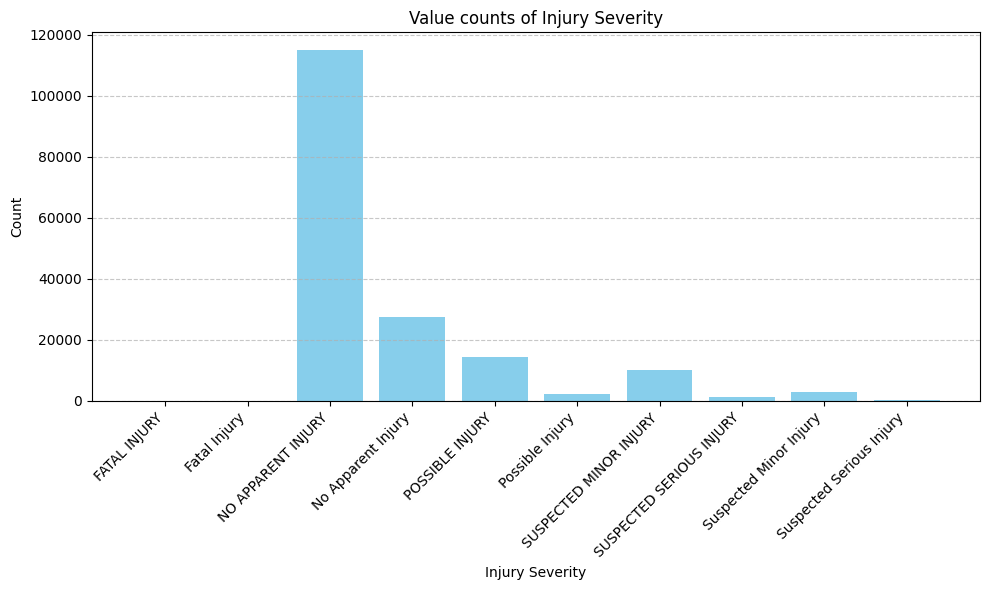

Plotting value counts for: Driver Substance Abuse


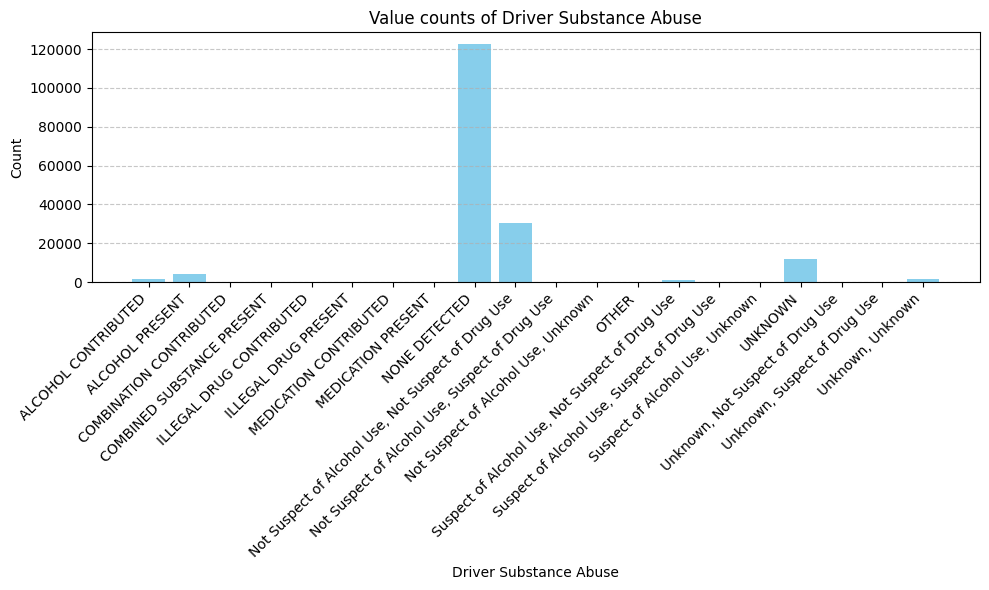

In [26]:
# List of columns to analyze
columns_to_analyze = ["Vehicle Year", "Speed Limit", "Injury Severity", "Driver Substance Abuse"]

# Loop over each column and plot its value counts
for col in columns_to_analyze:
    print(f"Plotting value counts for: {col}")
    plot_value_counts(bigbase_clean, variable=col)


We observe that the Vehicle Year variable contains implausible values, which will be removed from the dataset.

In [27]:
# Drop rows where Vehicle Year is less than 1920
bigbase_clean_step3 = bigbase_clean_step2[
    (bigbase_clean_step2['Vehicle Year'] >= 1950) &
    (bigbase_clean_step2['Vehicle Year'] <= 2025)
].copy()

# Vérification
print(f"Rows remaining after filtering Vehicle Year >= 1920: {len(bigbase_clean_step3)}")


Rows remaining after filtering Vehicle Year >= 1920: 170034


Let's plot again after this removal 

Plotting value counts for: Vehicle Year


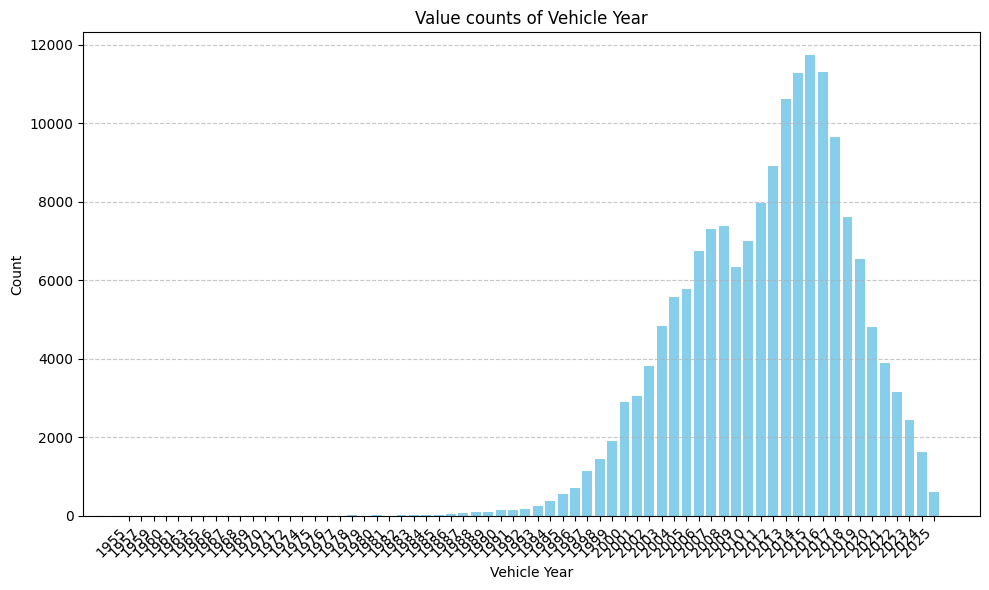

Plotting value counts for: Speed Limit


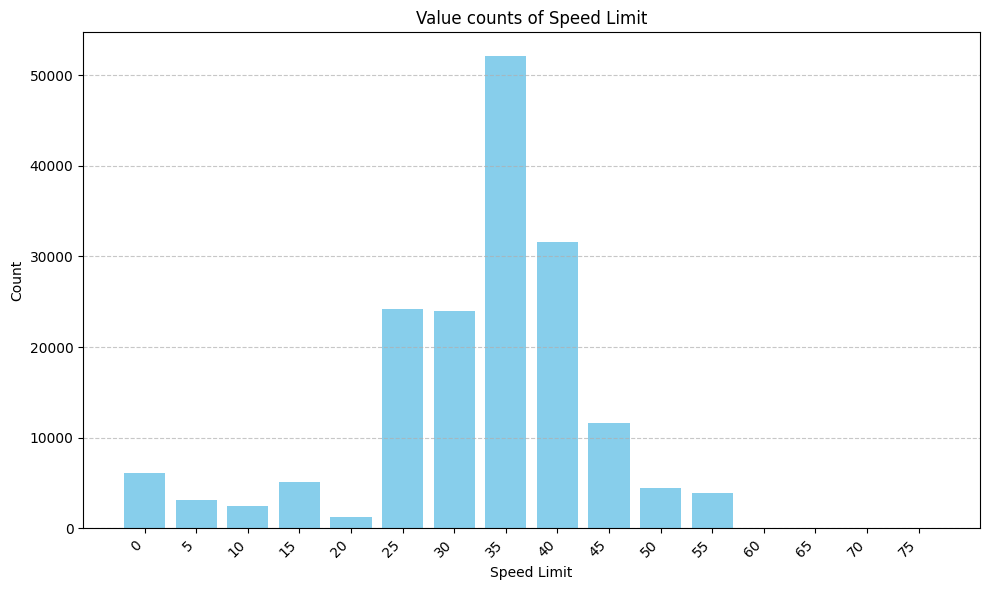

Plotting value counts for: Injury Severity


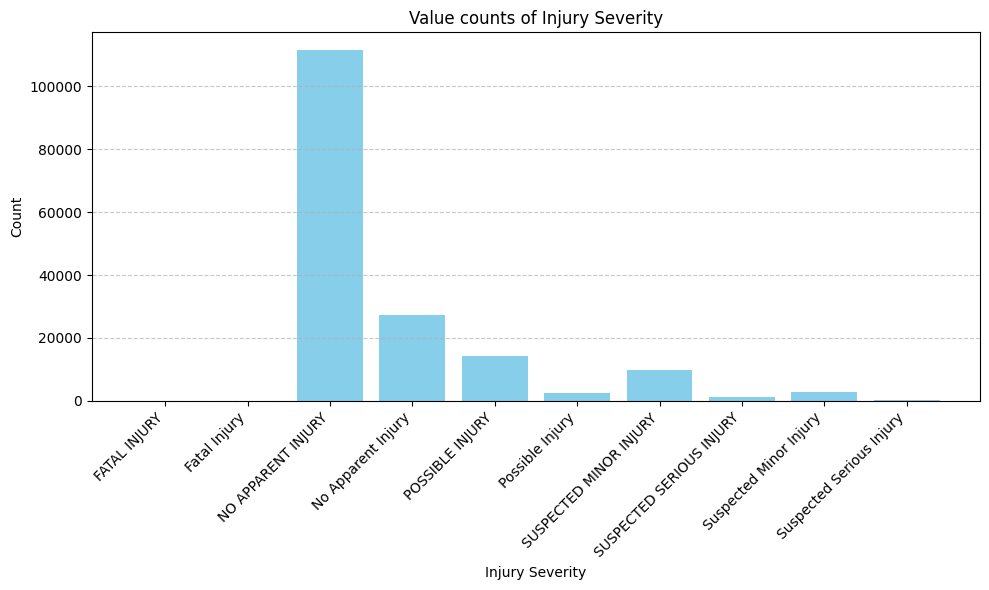

Plotting value counts for: Driver Substance Abuse


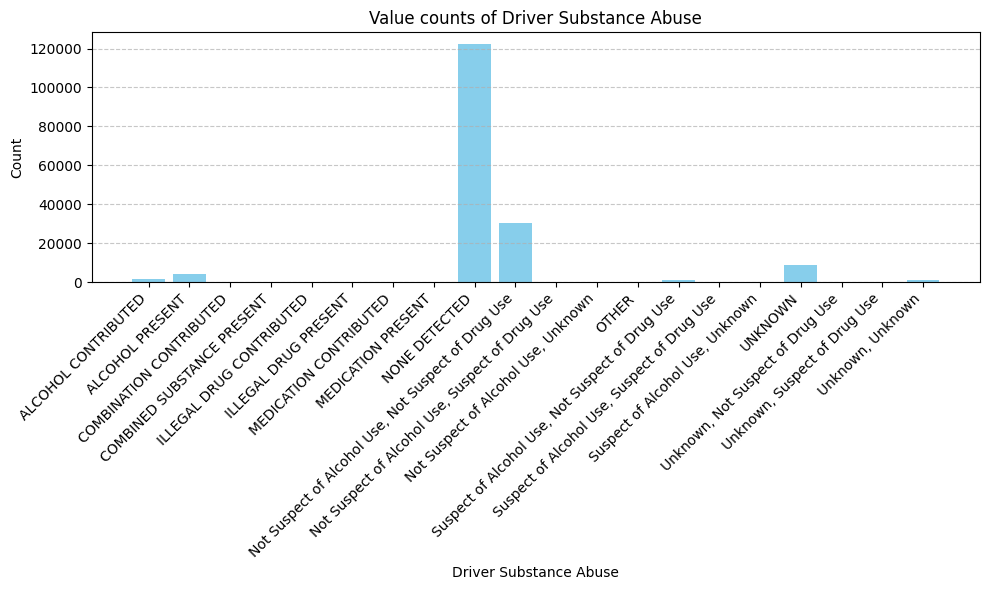

In [28]:
# List of columns to analyze
columns_to_analyze = ["Vehicle Year", "Speed Limit", "Injury Severity", "Driver Substance Abuse"]

# Loop over each column and plot its value counts
for col in columns_to_analyze:
    print(f"Plotting value counts for: {col}")
    plot_value_counts(bigbase_clean_step3, variable=col)


The implausible values have been successfully removed from the dataset.

In [29]:
# We can now have the final version of our big database : 

bigbase_final=bigbase_clean_step3

### I.2.iii Sampling <a id="sample"></a>


We will perform a sampling of the dataset to facilitate the integration of meteorological data. This step is necessary because the number of API requests is limited per hour, and working with a representative subset ensures efficient data enrichment.

In [31]:

# We want to extract a sample of 6000 lines to make sure the data can be used properly. 

n_samples = min(6000, len(bigbase_final))
bigbase_sample = bigbase_final.sample(n=n_samples, random_state=42)  
bigbase_sample.to_csv("Montgomery_sample.csv", index=False)

print("Original shape:", bigbase_sample.shape)
bigbase_sample.head(100)

Original shape: (6000, 39)


Report Number Local Case Number                Agency Name  \
110721    EJ7873004H         210038526  Gaithersburg Police Depar   
52761    MCP211600CT         210002455   Montgomery County Police   
196914   MCP289200HF         250021525                 MONTGOMERY   
142521   MCP2305001M         190029596   Montgomery County Police   
64203    MCP26330037         230027825   Montgomery County Police   
...              ...               ...                        ...   
107270   MCP06850043         180012380   Montgomery County Police   
74796    MCP2937001N          16012312                 MONTGOMERY   
33831    MCP2770000T          15060642                 MONTGOMERY   
181267   MCP3279003J         240045431                 MONTGOMERY   
158444   MCP29910053         210012909   Montgomery County Police   

             ACRS Report Type         Crash Date/Time        Route Type  \
110721  Property Damage Crash  09/29/2021 07:15:00 AM  Maryland (State)   
52761   Property Damage Crash  01/20/2021 10:54:00 AM            County   
196914  Property Damage Crash  05/15/2025 08:16:00 PM      County Route   
142521  Property Damage Crash  06/20/2019 10:20:00 PM            County   
64203   Property Damage Crash  06/09/2023 06:32:00 PM  Maryland (State)   
...                       ...                     ...               ...   
107270           Injury Crash  03/12/2018 09:12:00 AM  Maryland (State)   
74796   Property Damage Crash  03/12/2016 03:08:00 PM               NaN   
33831   Property Damage Crash  11/27/2015 04:49:00 PM  Maryland (State)   
181267           Injury Crash  09/23/2024 05:31:00 PM      County Route   
158444  Property Damage Crash  04/07/2021 06:20:00 AM  Maryland (State)   

                Road Name                 Cross-Street Name  \
110721     S FREDERICK RD                  FULKS CORNER AVE   
52761           SPRING ST                       FAIRVIEW RD   
196914    GRACE CHURCH RD                        SECOND AVE   
142521      DAVIS MILL RD                     HUNTMASTER RD   
64203      ROCKVILLE PIKE                      TUCKERMAN LA   
...                   ...                               ...   
107270      DARNESTOWN RD                     BERRYVILLE RD   
74796                 NaN                               NaN   
33831        KEY WEST AVE                  GREAT SENECA HWY   
181267         ARCOLA AVE                               NaN   
158444  NEW HAMPSHIRE AVE  RAMP 1 FR MD 650 NB TO MD 200 WB   

           Off-Road Description  Municipality  ... Vehicle Going Dir  \
110721                      NaN  GAITHERSBURG  ...             North   
52761                       NaN           NaN  ...             South   
196914                      NaN           NaN  ...               NaN   
142521                      NaN           NaN  ...             North   
64203                       NaN           NaN  ...             South   
...                         ...           ...  ...               ...   
107270                      NaN           NaN  ...              West   
74796   DRIVE THRU OF STARBUCKS           NaN  ...               NaN   
33831                       NaN           NaN  ...              East   
181267                      NaN           NaN  ...        Northbound   
158444                      NaN           NaN  ...              East   

       Speed Limit Driverless Vehicle Parked Vehicle Vehicle Year  \
110721          30                 No             No         2005   
52761           25                 No             No         2020   
196914          20                 No             No         2016   
142521          30                 No             No         2004   
64203           35                 No             No         2020   
...            ...                ...            ...          ...   
107270          50                 No             No         2010   
74796           15                 No            Yes         2009   
33831           35                

## I.3 Weather data <a id="weather"></a>

We are using the free API of Open Weather, which provides weather data from 1940 until now. 
The API call has different parameters: some are required (latitude, longitude, start_date, end_date), and other are optional (elevation -to improve accuracy, apikey -required only for commercial use, hourly -a list of hourly weather variables which should be returned, daily -a list of daily weather variable aggregations which should be returned).

Limitations: Only for non-commercial use and Less than 10 000 API calls per day, 5 000 per hour and 600 per minute.

<b> Focus on the WMO </b> <br>
The conditions corresponding to the WMO code are described here: https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM.

Weather icons illustration for each code are provided here: https://gist.github.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c

<b> DOCS for the Open Meteo </b> <br>
https://open-meteo.com/en/docs/historical-weather-api

### Reading the csv file with the data about car accident without weather

In [35]:
# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv")
else:
    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv")

# Preview first 5 rows
car_accidents_data.head()

Unnamed: 0.11  Unnamed: 0.10  Unnamed: 0.9  Unnamed: 0.8  Unnamed: 0.7  \
0              0              0             0             0             0   
1              1              1             1             1             1   
2              2              2             2             2             2   
3              3              3             3             3             3   
4              4              4             4             4             4   

   Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  ...  \
0             0             0             0             0             0  ...   
1             1             1             1             1             1  ...   
2             2             2             2             2             2  ...   
3             3             3             3             3             3  ...   
4             4             4             4             4             4  ...   

   weather_code  precipitation snowfall wind_speed wind_direction  \
0          51.0            0.3      0.0  10.829959     285.422211   
1          63.0            3.2      0.0   4.320000     270.000000   
2           2.0            0.0      0.0   6.120000     241.927612   
3           3.0            0.0      0.0   3.319036     139.398788   
4          61.0            1.5      0.0  12.599998     323.130005   

  soil_temperature soil_moisture   sunrise    sunset day_or_night_code  
0        11.233001         0.459  05:35:00  18:42:00                 0  
1        21.872499         0.518  04:43:00  19:37:00                 0  
2         8.493999         0.439  06:28:00  18:09:00                 0  
3        15.491500         0.407  04:55:00  19:13:00                 0  
4        12.625000         0.506  05:04:00  19:06:00                 0  

[5 rows x 64 columns]

# Ajout de la météo au dataset des accidents

## Square

In [23]:
def create_squares(df,lat,long,nb_sq_lat,nb_sq_long):
    lat_min = 38.934343
    lat_max = 39.353502
    lon_min = -77.52768
    lon_max = -76.888505
    grid_dict = {}
    
    # Compute the step sizes
    lat_step = (lat_max - lat_min) / nb_sq_lat
    lon_step = (lon_max - lon_min) / nb_sq_long
    
    for i in range(nb_sq_lat):
        for j in range(nb_sq_long):
            square_lat_min = lat_min + i * lat_step
            square_lat_max = lat_min + (i + 1) * lat_step
            square_lon_min = lon_min + j * lon_step
            square_lon_max = lon_min + (j + 1) * lon_step
            
            grid_dict[(i, j)] = (square_lat_min, square_lat_max, square_lon_min, square_lon_max)

    return grid_dict

create_squares(car_accidents_data,"Latitude","Longitude",3,3)


{(0, 0): (38.934343, 39.07406266666666, -77.52768, -77.31462166666667),
 (0, 1): (38.934343,
  39.07406266666666,
  -77.31462166666667,
  -77.10156333333333),
 (0, 2): (38.934343, 39.07406266666666, -77.10156333333333, -76.888505),
 (1, 0): (39.07406266666666,
  39.213782333333334,
  -77.52768,
  -77.31462166666667),
 (1, 1): (39.07406266666666,
  39.213782333333334,
  -77.31462166666667,
  -77.10156333333333),
 (1, 2): (39.07406266666666,
  39.213782333333334,
  -77.10156333333333,
  -76.888505),
 (2, 0): (39.213782333333334, 39.353502, -77.52768, -77.31462166666667),
 (2, 1): (39.213782333333334,
  39.353502,
  -77.31462166666667,
  -77.10156333333333),
 (2, 2): (39.213782333333334, 39.353502, -77.10156333333333, -76.888505)}

### Let's add for each line of the dataset in which square we are 

for each cell, we have to find in which square we are 

In [24]:
def find_square_from_grid(lat, lon, grid_dict):
    """
    Return the grid cell (i, j) containing the point (lat, lon).
    """
    for (i, j), (lat_min, lat_max, lon_min, lon_max) in grid_dict.items():
        if lat_min <= lat < lat_max and lon_min <= lon < lon_max:
            return (i, j)
    return None




ajouter au data set le numéro du carré

In [25]:
grid = create_squares(
    car_accidents_data,
    "Latitude",
    "Longitude",
    3,
    3
)


car_accidents_data['grid_cell'] = car_accidents_data.apply(
    lambda row: find_square_from_grid(
        row['Latitude'],
        row['Longitude'],
        grid
    ),
    axis=1
)
print(grid.keys())
car_accidents_data[['Latitude', 'Longitude', 'grid_cell']].head()



dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


Latitude  Longitude grid_cell
0  39.084912 -77.076068    (1, 2)
1  39.013298 -77.045822    (0, 2)
2  39.026372 -77.204397    (0, 1)
3  39.176243 -77.118350    (1, 1)
4  38.992689 -77.161965    (0, 1)

In [26]:
print(len(grid))
#print(grid[0])
print(grid)
print(grid.keys())

9
{(0, 0): (38.934343, 39.07406266666666, -77.52768, -77.31462166666667), (0, 1): (38.934343, 39.07406266666666, -77.31462166666667, -77.10156333333333), (0, 2): (38.934343, 39.07406266666666, -77.10156333333333, -76.888505), (1, 0): (39.07406266666666, 39.213782333333334, -77.52768, -77.31462166666667), (1, 1): (39.07406266666666, 39.213782333333334, -77.31462166666667, -77.10156333333333), (1, 2): (39.07406266666666, 39.213782333333334, -77.10156333333333, -76.888505), (2, 0): (39.213782333333334, 39.353502, -77.52768, -77.31462166666667), (2, 1): (39.213782333333334, 39.353502, -77.31462166666667, -77.10156333333333), (2, 2): (39.213782333333334, 39.353502, -77.10156333333333, -76.888505)}
dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


#### We provide a visual representation of the square to make sure our code works

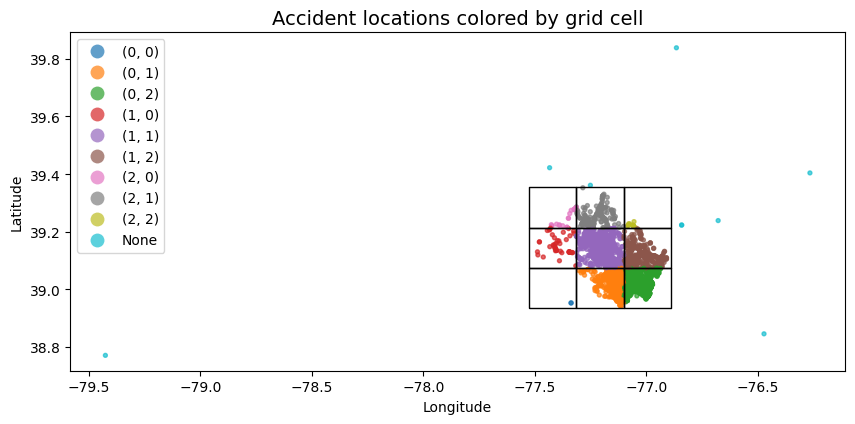

In [27]:

from shapely.geometry import Point
from shapely.geometry import Polygon


lat_min = 38.934343
lat_max = 39.353502
lon_min = -77.52768
lon_max = -76.888505
# Create geometry column from Latitude / Longitude
geometry = [
    Point(lon, lat)
    for lon, lat in zip(
        car_accidents_data['Longitude'],
        car_accidents_data['Latitude']
    )
]

gdf = gpd.GeoDataFrame(
    car_accidents_data,
    geometry=geometry,
    crs="EPSG:4326"
)

polygons = []
cells = []

for (i, j), (lat_min, lat_max, lon_min, lon_max) in grid.items():
    poly = Polygon([
        (lon_min, lat_min),
        (lon_max, lat_min),
        (lon_max, lat_max),
        (lon_min, lat_max)
    ])
    polygons.append(poly)
    cells.append(f"({i}, {j})")

grid_gdf = gpd.GeoDataFrame(
    {'grid_cell': cells},
    geometry=polygons,
    crs="EPSG:4326"
)

gdf['grid_cell_str'] = gdf['grid_cell'].astype(str)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot grid boundaries
grid_gdf.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1
)

# Plot accident points colored by grid cell
gdf.plot(
    ax=ax,
    column='grid_cell_str',
    cmap='tab10',
    markersize=8,
    legend=True,
    alpha=0.7
)

ax.set_title("Accident locations colored by grid cell", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


## Computing the average temperature for each square of the grid for each month

In [33]:

from retry_requests import retry
from datetime import datetime, timezone, timedelta

url = "https://archive-api.open-meteo.com/v1/archive"

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


#creer un tableau ca

def month_weather_api(latitude, longitude, start_date, end_date):
# on fournit la lat et long du centre du carré, et la date, afin d'obtenir.

# The order of variables in hourly or daily is important (to assign them correctly below)

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "UTC-5",
        "daily": [
        "temperature_2m_min",
        "temperature_2m_max",
        "temperature_2m_mean",
        "weather_code",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "sunrise",
        "sunset",
        "sunshine_duration",
        "daylight_duration",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]
    }

    responses = openmeteo.weather_api(url, params=params)
    #print(responses)

    response = responses[0]
    # Process daily data. The order of variables needs to be the same as requested.
    
    daily = response.Daily()
    #print(daily)

    daily_min_temp= daily.Variables(0).ValuesAsNumpy()
    daily_max_temp = daily.Variables(1).ValuesAsNumpy()
    daily_mean_temp = daily.Variables(2).ValuesAsNumpy()
    weather_code = daily.Variables(3).ValuesAsNumpy()
    apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
    apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
    precipitation_sum = daily.Variables(6).ValuesAsNumpy()
    rain_sum = daily.Variables(7).ValuesAsNumpy()
    snowfall_sum = daily.Variables(8).ValuesAsNumpy()
    precipitation_hours = daily.Variables(9).ValuesAsNumpy()
    sunrise = daily.Variables(10).ValuesInt64AsNumpy()
    sunset = daily.Variables(11).ValuesInt64AsNumpy()

    ## ou si on préfère avoir les données dans le format plus explicite: (on préfère garder le format précédent, en nombre de secondes écoulés depuis 1er janvier 1970)
    
    #raw_sunrise = daily.Variables(10).ValuesInt64AsNumpy()
    #raw_sunset = daily.Variables(11).ValuesInt64AsNumpy()

    #list_sunrise = raw_sunrise.tolist()
    #list_sunset = raw_sunset.tolist()

    #utc_minus_5 = timezone(timedelta(hours=-5))

    #sunrise = [datetime.fromtimestamp(e,tz=utc_minus_5).isoformat() for e in list_sunrise]
    
    #sunset = [datetime.fromtimestamp(e, tz=utc_minus_5).isoformat() for e in list_sunset]
    
    sunshine_duration = daily.Variables(12).ValuesAsNumpy()
    daylight_duration = daily.Variables(13).ValuesAsNumpy()
    wind_speed_10m_max = daily.Variables(14).ValuesAsNumpy()
    wind_gusts_10m_max = daily.Variables(15).ValuesAsNumpy()
    wind_direction_10m_dominant = daily.Variables(16).ValuesAsNumpy()
    shortwave_radiation_sum = daily.Variables(17).ValuesAsNumpy()
    et0_fao_evapotranspiration = daily.Variables(18).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["temperature_2m_min"] = daily_min_temp
    daily_data["temperature_2m_max"] = daily_max_temp
    daily_data["temperature_2m_mean"] = daily_mean_temp
    daily_data["weather_code"] = weather_code
    daily_data["apparent_temperature_max"] = apparent_temperature_max
    daily_data["apparent_temperature_min"] = apparent_temperature_min
    daily_data["precipitation_sum"] = precipitation_sum
    daily_data["rain_sum"] = rain_sum
    daily_data["snowfall_sum"] = snowfall_sum
    daily_data["precipitation_hours"] = precipitation_hours
    daily_data["sunrise"] = sunrise
    daily_data["sunset"] = sunset
    daily_data["sunshine_duration"] = sunshine_duration
    daily_data["daylight_duration"] = daylight_duration
    daily_data["wind_speed_10m_max"] = wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = wind_gusts_10m_max
    daily_data["wind_direction_10m_dominant"] = wind_direction_10m_dominant
    daily_data["shortwave_radiation_sum"] = shortwave_radiation_sum
    daily_data["et0_fao_evapotranspiration"] = et0_fao_evapotranspiration

    return {"daily": daily_data}

#weather_api(52.52, 13.41, "2025-11-09", "2025-11-09")

#month_weather_api(39.2903848, -76.6121893, "2025-01-01", "2025-01-02")
#add_weather()


## pour le rapport:
# convertion du format iso8601 vers un autre pour le sunset et sunrise
# mise sous forme d'un dictonnaire de dictionnaires (un pour les hourly, un pour les daily (ici besoin que du daily, mais dans la fonction plus bas d'ajout de la météo au dataset on utilise les 2 types de données: hourly et daily))
# pas de vérification qu'on a pas de NaN dans l'appel car tous les problèmes ont été réglés à la main donc il n'y en a plus, mais ça pourrait être bien.



NameError: name 'requests_cache' is not defined

### Using the month_weather_api function to fill the array

In [ ]:
cells = list(grid.keys())

nb_cells_col = (cells[-1])[1]+1 #pour calculer l'index des cellules

months_nb = 12
years = list(range(2014, 2026))
years_nb = len(years)

nb_variables = 19 #the number of variables that we stock for the monthly dataset

### Ne pas relancer ceci (les appels API pour récupérer les données brutes)

In [ ]:
"""

cells = list(grid.keys())

nb_cells_col = (cells[-1])[1]+1 #pour calculer l'index des cellules

months_nb = 12
years = list(range(2014, 2026))
years_nb = len(years)

nb_variables = 19 #the number of variables that we stock for the monthly dataset

raw_data = np.zeros(
    (len(cells), months_nb, years_nb, nb_variables),
    dtype=list
)

for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]
    l1, l2, L1, L2 = cell [0], cell[1], cell[2], cell[3]
    lcenter, Lcenter = (l2 + l1)/2, (L2 + L1)/2
    print("Starting cell:", c)
    print("Central latitude:", lcenter)
    print("Central longitude:", Lcenter)

    for m in range(months_nb) :
        m_arg = str(m + 1)
        if m+1 < 10:
            m_arg = "0" + m_arg

        for y in years:

            y_index = 2025 - y #we obtain the index number, starting at 0 for 2025
            #print(y)
            #y_arg = str(y)[2] + str(y)[3]
            #print(y_arg)

            last_day = calendar.monthrange(y, m+1)[1] #+1 because month must be between 1 and 12 for the monthrange
            #print(last_day)

            start_date = str(y) + "-" + m_arg + "-" + "01"

            end_date = str(y) + "-" + m_arg + "-"  + str(last_day)
            
            if y == 2025 and m == 11 :
                end_date = "2025-12-19" #the historcal API only allow past data
        
            print(start_date)
            print(end_date)

            # etape 1: recuperer données brutes via la fonction
            raw_variables = month_weather_api(lcenter, Lcenter, start_date, end_date)
            
            daily_data = raw_variables["daily"]

            # etape 2: faire 3 list à partir des array avec le .tolist(), pour min, max, mean

            min_temp_list = daily_data['temperature_2m_min'].tolist()
            max_temp_list = daily_data['temperature_2m_max'].tolist()
            mean_temp_list = daily_data['temperature_2m_mean'].tolist()
                    
            weather_code_list = daily_data['weather_code'].tolist()

            apparent_temperature_max_list = daily_data['apparent_temperature_max'].tolist()
            apparent_temperature_min_list = daily_data['apparent_temperature_min'].tolist()

            precipitation_sum_list = daily_data['precipitation_sum'].tolist()
            rain_sum_list = daily_data['rain_sum'].tolist()
            snowfall_sum_list = daily_data['snowfall_sum'].tolist()

            precipitation_hours_list = daily_data['precipitation_hours'].tolist()

            sunrise_list = daily_data['sunrise'].tolist()
            sunset_list = daily_data['sunset'].tolist()
            
            sunshine_duration_list = daily_data['sunshine_duration'].tolist()
            daylight_duration_list = daily_data['daylight_duration'].tolist()

            wind_speed_10m_max_list = daily_data['wind_speed_10m_max'].tolist()
            wind_gusts_10m_max_list = daily_data['wind_gusts_10m_max'].tolist()
            wind_direction_10m_dominant_list = daily_data['wind_direction_10m_dominant'].tolist()

            shortwave_radiation_sum_list = daily_data['shortwave_radiation_sum'].tolist()
            et0_fao_evapotranspiration_list = daily_data['et0_fao_evapotranspiration'].tolist()

            raw_data[cell_index][m][y_index][0] = min_temp_list
            raw_data[cell_index][m][y_index][1] = max_temp_list
            raw_data[cell_index][m][y_index][2] = mean_temp_list

            raw_data[cell_index][m][y_index][3] = weather_code_list

            raw_data[cell_index][m][y_index][4] = apparent_temperature_max_list
            raw_data[cell_index][m][y_index][5] = apparent_temperature_min_list

            raw_data[cell_index][m][y_index][6] = precipitation_sum_list
            raw_data[cell_index][m][y_index][7] = rain_sum_list
            raw_data[cell_index][m][y_index][8] = snowfall_sum_list

            raw_data[cell_index][m][y_index][9] = precipitation_hours_list

            raw_data[cell_index][m][y_index][10] = sunrise_list
            raw_data[cell_index][m][y_index][11] = sunset_list

            raw_data[cell_index][m][y_index][12] = sunshine_duration_list
            raw_data[cell_index][m][y_index][13] = daylight_duration_list

            raw_data[cell_index][m][y_index][14] = wind_speed_10m_max_list
            raw_data[cell_index][m][y_index][15] = wind_gusts_10m_max_list
            raw_data[cell_index][m][y_index][16] = wind_direction_10m_dominant_list

            raw_data[cell_index][m][y_index][17] = shortwave_radiation_sum_list
            raw_data[cell_index][m][y_index][18] = et0_fao_evapotranspiration_list

            np.savez_compressed("raw_data_weather.npz",  allow_pickle=True, raw_data=raw_data)
            #print(raw_data)

    time.sleep(60)
    print("=========================")

# tableau de dimension 4

# avec un appel API (i.e. de la fonction month_weather_api), on remplit une ligne du tableau (une ligne annee)

# etape 2: faire 3 list à partir des array avec le .tolist(), pour min, max, mean

#data = np.load("raw_data.npz", allow_pickle=True)
#raw_data = data["raw_data"]
#print(raw_data)
"""

'\n\ncells = list(grid.keys())\n\nnb_cells_col = (cells[-1])[1]+1 #pour calculer l\'index des cellules\n\nmonths_nb = 12\nyears = list(range(2014, 2026))\nyears_nb = len(years)\n\nnb_variables = 19 #the number of variables that we stock for the monthly dataset\n\nraw_data = np.zeros(\n    (len(cells), months_nb, years_nb, nb_variables),\n    dtype=list\n)\n\nfor c in grid :\n    cell_index = c[0]*nb_cells_col + c[1]\n    # on calcule le centre de la cellule (lat, long)\n    cell = grid[c]\n    l1, l2, L1, L2 = cell [0], cell[1], cell[2], cell[3]\n    lcenter, Lcenter = (l2 + l1)/2, (L2 + L1)/2\n    print("Starting cell:", c)\n    print("Central latitude:", lcenter)\n    print("Central longitude:", Lcenter)\n\n    for m in range(months_nb) :\n        m_arg = str(m + 1)\n        if m+1 < 10:\n            m_arg = "0" + m_arg\n\n        for y in years:\n\n            y_index = 2025 - y #we obtain the index number, starting at 0 for 2025\n            #print(y)\n            #y_arg = str(y)[2

### Correction du type de sunrise et sunset (conversion numpy array --> list pour uniformisation)

In [ ]:
from datetime import timezone, timedelta

data = np.load("full_raw_data_weather.npz", allow_pickle=True)
raw_data = data["raw_data"]
utc_minus_5 = timezone(timedelta(hours=-5))

for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]

    for m in range(months_nb) :

        # pour chacune des variables, on va faire la moyenne des valeurs sur tous les jours du mois, et sur toutes les années
        for y in years:
            y_index = 2025 - y

            list_sunrise = raw_data[cell_index][m][y_index][10].tolist()
            list_sunset = raw_data[cell_index][m][y_index][11].tolist()

            raw_data[cell_index][m][y_index][10] = list_sunrise # ou si conversion souhaitée: [datetime.fromtimestamp(e,tz=utc_minus_5).isoformat() for e in list_sunrise]
            raw_data[cell_index][m][y_index][11] = list_sunset # ou si conversion souhaitée:[datetime.fromtimestamp(e,tz=utc_minus_5).isoformat() for e in list_sunset]
            

np.savez_compressed("full_corrected_raw_data_weather.npz",  allow_pickle=True, raw_data=raw_data)

In [ ]:
### Vérification que la correction a bien fonctionnée

data = np.load("full_corrected_raw_data_weather.npz", allow_pickle=True)
raw_data = data["raw_data"]

print(type(raw_data[1][2][5][11]))

<class 'list'>


### Calcul des moyennes à partir des données brutes contenues dans full_raw_data_weather.npz

In [ ]:
data = np.load("full_corrected_raw_data_weather.npz", allow_pickle=True)
raw_data = data["raw_data"]

# creation du tableau permettant de sstocker les valeurs moyennes

# calculs des valeurs moyennes à partir des données brutes
### pour les variables qui nous intéressent:
## 1. Moyenne sur les jours de chaque mois
## 2. Moyenne sur les années de chaque mois
## on obtient les valeurs moyennes pour chaque mois, pour chaque variables, et ce pour chaque cellule de la grille

raw_data_average = np.zeros(
    (len(cells), months_nb, nb_variables),
    dtype=float
)

# calcul des valeurs

for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]

    for m in range(months_nb):
        m_arg = str(m + 1)
        if m+1 < 10:
            m_arg = "0" + m_arg

        # pour chacune des variables, on va faire la moyenne des valeurs sur tous les jours du mois, et sur toutes les années
        for i in range (0, 19):
            v_acccross_years = []

            for y in years:
                y_index = 2025 - y
                values = raw_data[cell_index][m][y_index][i]

                #if i == 10 or i == 11:
                #    mean = sum(values) / len(values)                            
                #else :
                
                mean = np.mean(raw_data[cell_index][m][y_index][i])

                v_acccross_years.append(mean)
                
            v_mean = np.mean(v_acccross_years)

            raw_data_average[cell_index][m][i] = v_mean
            
np.savez_compressed("full_months_average.npz",  allow_pickle=True, raw_data=raw_data)

### Documentation : Comment utiliser les valeurs moyennes par mois ?

In [ ]:
# pour récupérer ce dataset, il suffit de faire :
data = np.load("full_months_average.npz", allow_pickle=True)
raw_data = data["raw_data"]

## et ensuite pour accéder à la valeur moyenne de la variable i du mois m de la case c:
raw_data_average[cell_index][m][i] = v_mean

# où m = 0 pour janvier, 11 pour décembre
# où cell_index est calculé avec : cell_index = c[0]*nb_cells_col + c[1] pour c in grid.keys()
# et où :
# i = 0  -> min_temp
# i = 1  -> max_temp
# i = 2  -> mean_temp
# i = 3  -> weather_code
# i = 4  -> apparent_temperature_max
# i = 5  -> apparent_temperature_min
# i = 6  -> precipitation_sum
# i = 7  -> rain_sum
# i = 8  -> snowfall_sum
# i = 9  -> precipitation_hours
# i = 10 -> sunrise
# i = 11 -> sunset
# i = 12 -> sunshine_duration
# i = 13 -> daylight_duration
# i = 14 -> wind_speed_10m_max
# i = 15 -> wind_gusts_10m_max
# i = 16 -> wind_direction_10m_dominant
# i = 17 -> shortwave_radiation_sum
# i = 18 -> et0_fao_evapotranspiration

##### Affichage des valeurs moyennes

In [ ]:
for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]
    for m in range(months_nb):
        for i in range (0, 19):
            print(i,raw_data_average[cell_index][m][i])

0 -3.223999974908688
1 5.319951621124582
2 0.908056529486672
3 31.776881720430108
4 1.3310835733208604
5 -7.77318242672951
6 2.5803763881245616
7 1.8819892675445604
8 0.49395161019938616
9 3.4274193548387095
10 1563431106.9247313
11 1563466369.9623654
12 21096.771797590358
13 35262.4481686828
14 18.401449966174297
15 38.256773207777286
16 236.19903559838568
17 7.758360215412672
18 1.0896585007668824
0 -1.6823435735717502
1 8.315203505131603
2 3.0923971933766143
3 33.254002463054185
4 4.6444337820674
5 -6.012600337318795
6 2.9226908406452234
7 2.2916769158654833
8 0.4474928057033795
9 3.8022372742200328
10 1565989239.332307
11 1566027966.161741
12 23593.97752689493
13 38725.86223292859
14 18.437769592395558
15 39.3475850318453
16 225.1658940699765
17 10.55044338501048
18 1.5337182681316321
0 1.5553010808884775
1 12.878956687406344
2 7.033347798441286
3 29.16935483870968
4 9.5844933935391
5 -2.4650932050520376
6 2.806451665838399
7 2.3459677836827693
8 0.32422043258945143
9 3.39516129032

### Code using the API with a function (timezone "UTC-5")

In [ ]:


from retry_requests import retry
from datetime import datetime, timezone, timedelta

url = "https://archive-api.open-meteo.com/v1/archive"

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def weather_api(latitude, longitude, start_date, end_date):
# Function to get weather data from OpenMeteo API
# Return a json with hourly and daily data

# The order of variables in hourly or daily is important (to assign them correctly below)

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "UTC-5",
        "hourly": ["temperature_2m", "apparent_temperature", "relative_humidity_2m", "weather_code", "precipitation", "snowfall", "wind_speed_10m", "wind_direction_10m", "soil_temperature_0_to_7cm", "soil_moisture_0_to_7cm", "shortwave_radiation", "direct_radiation", "direct_normal_irradiance", "diffuse_radiation", "global_tilted_irradiance", "sunshine_duration"],
        "daily": ["sunrise", "sunset"]
    }

    responses = openmeteo.weather_api(url, params=params)
    #print(responses)

    response = responses[0]

    #print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    #print(f"Elevation: {response.Elevation()} m asl")
    #print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    temperature = hourly.Variables(0).ValuesAsNumpy()
    apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
    humidity = hourly.Variables(2).ValuesAsNumpy()
    weather_code = hourly.Variables(3).ValuesAsNumpy()
    precipitation = hourly.Variables(4).ValuesAsNumpy()
    snowfall = hourly.Variables(5).ValuesAsNumpy()
    wind_speed = hourly.Variables(6).ValuesAsNumpy()
    wind_direction = hourly.Variables(7).ValuesAsNumpy()
    soil_temperature = hourly.Variables(8).ValuesAsNumpy()
    soil_moisture = hourly.Variables(9).ValuesAsNumpy()
    shortwave_radiation = hourly.Variables(10).ValuesAsNumpy()
    direct_radiation = hourly.Variables(11).ValuesAsNumpy()
    direct_normal_irradiance = hourly.Variables(12).ValuesAsNumpy
    diffuse_radiation = hourly.Variables(13).ValuesAsNumpy()
    global_tilted_irradiance = hourly.Variables(14).ValuesAsNumpy
    sunshine_duration = hourly.Variables(15).ValuesAsNumpy()

    
    daily = response.Daily()

    daily_sunrise = daily.Variables(0).ValuesInt64AsNumpy()
    daily_sunset = daily.Variables(1).ValuesInt64AsNumpy()

    utc_minus_5 = timezone(timedelta(hours=-5))

    daily_sunrise= datetime.fromtimestamp(daily_sunrise[0],tz=utc_minus_5).isoformat()
    daily_sunset= datetime.fromtimestamp(daily_sunset[0], tz=utc_minus_5).isoformat()
    
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["temperature"] = temperature
    hourly_data["apparent_temperature"] = apparent_temperature
    hourly_data["humidity"] = humidity
    hourly_data["weather_code"] = weather_code
    hourly_data["precipitation"] = precipitation
    hourly_data["snowfall"] = snowfall
    hourly_data["wind_speed"] = wind_speed
    hourly_data["wind_direction"] = wind_direction
    hourly_data["soil_temperature"] = soil_temperature
    hourly_data["soil_moisture"] = soil_moisture
    
    """
    cette partie doit rester commentée 
    hourly_data["shortwave_radiation"] = shortwave_radiation
    hourly_data["direct_radiation"] = direct_radiation
    hourly_data["direct_normal_irradiance"] = direct_normal_irradiance
    hourly_data["diffuse_radiation"] = diffuse_radiation
    hourly_data["global_tilted_irradiance"] = global_tilted_irradiance
    hourly_data["sunshine_duration"] = sunshine_duration
    """
    
    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["sunrise"] = daily_sunrise
    daily_data["sunset"] = daily_sunset
    

    return {"hourly": hourly_data, "daily": daily_data}

#weather_api(52.52, 13.41, "2025-11-09", "2025-11-09")

weather_api(39.2903848, -76.6121893, "2025-01-01", "2025-01-20")
#add_weather()


{'hourly': {'date': DatetimeIndex(['2025-01-01 05:00:00+00:00', '2025-01-01 06:00:00+00:00',
                 '2025-01-01 07:00:00+00:00', '2025-01-01 08:00:00+00:00',
                 '2025-01-01 09:00:00+00:00', '2025-01-01 10:00:00+00:00',
                 '2025-01-01 11:00:00+00:00', '2025-01-01 12:00:00+00:00',
                 '2025-01-01 13:00:00+00:00', '2025-01-01 14:00:00+00:00',
                 ...
                 '2025-01-20 19:00:00+00:00', '2025-01-20 20:00:00+00:00',
                 '2025-01-20 21:00:00+00:00', '2025-01-20 22:00:00+00:00',
                 '2025-01-20 23:00:00+00:00', '2025-01-21 00:00:00+00:00',
                 '2025-01-21 01:00:00+00:00', '2025-01-21 02:00:00+00:00',
                 '2025-01-21 03:00:00+00:00', '2025-01-21 04:00:00+00:00'],
                dtype='datetime64[ns, UTC]', length=480, freq='h'),
  'temperature': array([ 7.85850000e+00,  8.35850048e+00,  8.45849991e+00,  7.95849991e+00,
          7.55849981e+00,  7.15849972e+00,  6.8084

### Function that add the weather data to the data set

In [ ]:


"""
# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv") # usecols=usecols) to select specific columns

def add_weather():
    n = len(car_accidents_data)

    # adding weather columns to car_accidents_data

    weather_columns_hourly = [
        "temperature",
        "apparent_temperature",
        "humidity",
        "weather_code",
        "precipitation",
        "snowfall",
        "wind_speed",
        "wind_direction",
        "soil_temperature",
        "soil_moisture"
    ]

    weather_columns_daily = [
        "sunrise",
        "sunset",
        "day_or_night_code"]
    
    weather_columns = weather_columns_hourly + weather_columns_daily

    new_data = {col: [None] * n for col in weather_columns}
    for col, values in new_data.items():
        if col not in car_accidents_data.columns: # to avoid overwriting existing columns with data coming form previous runs
            car_accidents_data[col] = values
    
    #show the full updated dataframe
    #print("Updated car_accidents_data with new weather columns:")
    #print(car_accidents_data.head())
    
    j, k = 0, 0

    start_time = time.perf_counter()
    for i in range(0,n):
        j+=1
        print(f"Processing row {i}, meaning row {j} of the {k} series, out of {n}")
        latitude = car_accidents_data.iloc[i]['Latitude']
        longitude = car_accidents_data.iloc[i]['Longitude']
        date_time = car_accidents_data.iloc[i]['Crash Date/Time']

        date = date_time.split(" ")[0]
        accident_time = date_time.split(" ")[1] #useless
        

        hour = date_time.split(" ")[1].split(":")[0]
        time_of_day = date_time.split(" ")[2]
        time_minutes = date_time.split(" ")[1].split(":")[1]

        time_index = int(hour) # index starts at 0 for midnight, so 1am = 1, 2am = 2, ..., 12pm = 12, 1pm = 13, ..., 11pm = 23

        if time_of_day == "PM" and hour != "12":
            time_index += 12
        elif time_of_day == "AM" and hour == "12":
            time_index = 0

        if time_minutes < "30":
            time_index += 0
        elif int(hour) < 11 :
            time_index += 1

        #print(f"Fetching weather data for row {i} (ID: {car_accidents_data.index[i]}) at coordinates: {latitude}, {longitude}")
        #print(f"Crash Date/Time: {date_time}")
        print(f"Parsed Date: {date}, Time: {accident_time}, Hour: {hour}, Time of Day: {time_of_day}, Time Minutes: {time_minutes}")
        #print(f"Computed Time Index for hourly data: {time_index}")

        date_conversion = pd.to_datetime(date)
        date_for_api = date_conversion.strftime("%Y-%m-%d")
        #print(f"Formatted Date for API: {date_for_api}")

        weather_data = weather_api(latitude, longitude, date_for_api, date_for_api)

        # Extract hourly weather data for the specific hour of the crash
        hourly_data = weather_data["hourly"]
        daily_data = weather_data["daily"]

        #print(hourly_data)
        #print('Daily data:')
        #print(daily_data)

        for col in weather_columns_hourly:
            if col in hourly_data:
                print("Time index:", time_index)
                car_accidents_data.at[i, col] = hourly_data[col][time_index]
                #print(f"Assigned {col} value: {hourly_data[col][time_index]} to row {i} (ID: {car_accidents_data.index[i]})")
            else:
                print(f"Warning: {col} not found in hourly data for row {i} (ID: {car_accidents_data.index[i]})")
            
        col = "day_or_night_code"
        if "sunrise" in daily_data and "sunset" in daily_data:
            sunrise_time = daily_data["sunrise"]
            #print(f"Sunrise time: {sunrise_time}")
            sunrise_time_list = sunrise_time.split("T")[1].split(":")[0:2]
            sunrise_time_h, sunrise_time_m = sunrise_time_list[0], sunrise_time_list[1]
            #print(f"Sunrise time (hour) and minute): {sunrise_time_h} {sunrise_time_m}")

            sunrise_time_hm = sunrise_time_h + ":" + sunrise_time_m + ":00"

            sunset_time = daily_data["sunset"]
            sunset_time_list = sunset_time.split("T")[1].split(":")[0:2]
            sunset_time_h, sunset_time_m = sunset_time_list[0], sunset_time_list[1]
            #print(f"Sunset time (hour and minute): {sunset_time_h} {sunset_time_m}")

            sunset_time_hm = sunset_time_h + ":" + sunset_time_m + ":00"

            if time_of_day == "PM" and hour != "12":
                accident_hour_24h = int(hour) + 12
            elif time_of_day == "AM" and hour == "12":
                accident_hour_24h = 00
            else :
                accident_hour_24h = int(hour)

            if accident_hour_24h < 10:
                accident_hour_24h = "0" + str(accident_hour_24h)
            accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

            if sunrise_time_hm <= accident_time_24h <= sunset_time_hm:
                #print(f"Crash time {time} is during the day (between {sunrise_time_hm} and {sunset_time_hm})")
                car_accidents_data.at[i, col] = "0"
            else:
                #print(f"Crash time {time} is during the night (outside {sunrise_time_hm} and {sunset_time_hm})")
                car_accidents_data.at[i, col] = "1"
            
            #print(f"Assigned {col} value: {car_accidents_data.at[i, col]} to row {i} (ID: {car_accidents_data.index[i]})")

            # we add the sunrise and sunset times to the dataframe, because it could be useful later to identify crashes at times close to sunrise/sunset
            car_accidents_data.at[i, "sunrise"] = sunrise_time_hm
            car_accidents_data.at[i, "sunset"] = sunset_time_hm
        else:
            print(f"Warning: sunrise or sunset not found in daily data for row {i} (ID: {car_accidents_data.index[i]})")
        
        if j > 300 :
            # Update the CSV file after each batch of 550 requests
            #car_accidents_data.to_csv("completed_dataset_sample.csv")

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Elapsed time for 550 requests: {elapsed} seconds")

            time.sleep(120) # to respect rate limit of 600 requests per minute (with a security margin of 4 seconds)
            j = 0
            k += 1
            start_time = time.perf_counter()

    # Saving the dataframe as a csv file

    # Export the file to the current working directory
    #car_accidents_data.to_csv("completed_dataset_sample.csv")

    return

add_weather()

"""

'\n# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work\nif os.path.exists("completed_dataset_sample.csv"):\n    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns\nelse:\n    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv") # usecols=usecols) to select specific columns\n\ndef add_weather():\n    n = len(car_accidents_data)\n\n    # adding weather columns to car_accidents_data\n\n    weather_columns_hourly = [\n        "temperature",\n        "apparent_temperature",\n        "humidity",\n        "weather_code",\n        "precipitation",\n        "snowfall",\n        "wind_speed",\n        "wind_direction",\n        "soil_temperature",\n        "soil_moisture"\n    ]\n\n    weather_columns_daily = [\n        "sunrise",\n        "sunset",\n        "day_or_night_code"]\n\n    weather_columns = weather_columns_hourly + weather_columns_da

In [ ]:
car_accidents_data.head()

Unnamed: 0.10  Unnamed: 0.9  Unnamed: 0.8  Unnamed: 0.7  Unnamed: 0.6  \
0              0             0             0             0             0   
1              1             1             1             1             1   
2              2             2             2             2             2   
3              3             3             3             3             3   
4              4             4             4             4             4   

   Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  ...  \
0             0             0             0             0             0  ...   
1             1             1             1             1             1  ...   
2             2             2             2             2             2  ...   
3             3             3             3             3             3  ...   
4             4             4             4             4             4  ...   

   precipitation snowfall wind_speed wind_direction soil_temperature  \
0            0.3      0.0  10.829959     285.422211        11.233001   
1            3.2      0.0   4.320000     270.000000        21.872499   
2            0.0      0.0   6.120000     241.927612         8.493999   
3            0.0      0.0   3.319036     139.398788        15.491500   
4            1.5      0.0  12.599998     323.130005        12.625000   

  soil_moisture   sunrise    sunset day_or_night_code grid_cell  
0         0.459  05:35:00  18:42:00                 0    (1, 2)  
1         0.518  04:43:00  19:37:00                 0    (0, 2)  
2         0.439  06:28:00  18:09:00                 0    (0, 1)  
3         0.407  04:55:00  19:13:00                 0    (1, 1)  
4         0.506  05:04:00  19:06:00                 0    (0, 1)  

[5 rows x 64 columns]

### Correction of the day_or_night_code column to take PM into account

In [ ]:
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    print("The file does not exist.")

n = len(car_accidents_data)
for i in range(0,n):

    date_time = car_accidents_data.iloc[i]['Crash Date/Time']

    accident_time = date_time.split(" ")[1] #useless
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)
    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    sunrise_time = car_accidents_data.iloc[i]['sunrise']
    sunset_time = car_accidents_data.iloc[i]['sunset']

    if sunrise_time <= accident_time_24h <= sunset_time:
        car_accidents_data.at[i, "day_or_night_code"] = "0"
        print(f"Daytime crash at row {i}: accident time {accident_time_24h}, sunrise {sunrise_time}, sunset {sunset_time}")
    else:
        car_accidents_data.at[i, "day_or_night_code"] = "1"
        print(f"Nighttime crash at row {i}: accident time {accident_time_24h}, sunrise {sunrise_time}, sunset {sunset_time}")
    
   #print(f"Processed row {i} out of {n}")

car_accidents_data.head()
car_accidents_data.to_csv("completed_dataset_sample.csv")

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\1289435743.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  car_accidents_data.at[i, "day_or_night_code"] = "0"


Daytime crash at row 0: accident time 07:40:00, sunrise 05:35:00, sunset 18:42:00
Daytime crash at row 1: accident time 10:35:00, sunrise 04:43:00, sunset 19:37:00
Daytime crash at row 2: accident time 07:00:00, sunrise 06:28:00, sunset 18:09:00
Daytime crash at row 3: accident time 06:55:00, sunrise 04:55:00, sunset 19:13:00
Daytime crash at row 4: accident time 15:02:00, sunrise 05:04:00, sunset 19:06:00
Daytime crash at row 5: accident time 14:01:00, sunrise 06:18:00, sunset 18:16:00
Daytime crash at row 6: accident time 10:35:00, sunrise 05:04:00, sunset 19:07:00
Daytime crash at row 7: accident time 08:20:00, sunrise 07:17:00, sunset 17:26:00
Daytime crash at row 8: accident time 13:53:00, sunrise 05:45:00, sunset 18:36:00
Daytime crash at row 9: accident time 12:08:00, sunrise 05:36:00, sunset 18:41:00
Daytime crash at row 10: accident time 15:57:00, sunrise 07:24:00, sunset 17:11:00
Daytime crash at row 11: accident time 15:25:00, sunrise 07:27:00, sunset 17:06:00
Daytime crash 

## Create squares 

# Markdown

### Let's create new variables taking into account the average value we collected

Let $X$ denote a variable obtained from the API calls.
Let $\bar{X}$ denote the average we found using the API calls. 

We introduce the normalized variable $\tilde{X}$, defined by $\tilde{X} = \frac{X - \bar{X}}{\bar{X}}$.


CELLULE TEMPORAIRE : DATASET AVEC DONNEES METEO

In [92]:
dataset = pd.read_csv("completed_dataset_sample.csv").copy()

grid = create_squares(
    dataset,
    "Latitude",
    "Longitude",
    3,
    3
)


dataset['grid_cell'] = dataset.apply(
    lambda row: find_square_from_grid(
        row['Latitude'],
        row['Longitude'],
        grid
    ),
    axis=1
)
print(grid.keys())
dataset[['Latitude', 'Longitude', 'grid_cell']].head()
dataset = dataset[dataset['grid_cell'].notna()]


dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


In [93]:
c=(0,1)
cell_index = c[0]*nb_cells_col + c[1]

print(cell_index)
print(raw_data_average[cell_index][7][2])




1
23.9908642461223


In [94]:


# ================================
# 1. Conversion de la date en datetime
# ================================
dataset['Crash Date/Time'] = pd.to_datetime(dataset['Crash Date/Time'], errors='coerce')


API_Columns = [
    ("temperature", 2),
    ("precipitation", 6),
    ("snowfall", 8),("wind_speed",14)
]

for column_name, var_idx in API_Columns:
    var_name = f"{column_name}_normalized"
    dataset[var_name] = np.nan  # initialiser avec NaN
    
    for index, row in dataset.iterrows():
        month_idx = row['Crash Date/Time'].month - 1
        i, j = row['grid_cell']
        cell_index = i * nb_cells_col + j
        
        # Valeur moyenne provenant de raw_data_average
        mean = raw_data_average[cell_index][month_idx][var_idx]
        
        # Valeur locale et normalisée
        local_value = row[column_name]
        local_value_normalized = (local_value - mean) / mean
        
        # Affecter uniquement à la ligne actuelle
        dataset.at[index, var_name] = local_value_normalized

dataset.head()



C:\Users\33783\AppData\Local\Temp\ipykernel_18980\2394325652.py:27: RuntimeWarning:

invalid value encountered in scalar divide



Unnamed: 0.11  Unnamed: 0.10  Unnamed: 0.9  Unnamed: 0.8  Unnamed: 0.7  \
0              0              0             0             0             0   
1              1              1             1             1             1   
2              2              2             2             2             2   
3              3              3             3             3             3   
4              4              4             4             4             4   

   Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  ...  \
0             0             0             0             0             0  ...   
1             1             1             1             1             1  ...   
2             2             2             2             2             2  ...   
3             3             3             3             3             3  ...   
4             4             4             4             4             4  ...   

   soil_temperature  soil_moisture   sunrise    sunset day_or_night_code  \
0         11.233001          0.459  05:35:00  18:42:00                 0   
1         21.872499          0.518  04:43:00  19:37:00                 0   
2          8.493999          0.439  06:28:00  18:09:00                 0   
3         15.491500          0.407  04:55:00  19:13:00                 0   
4         12.625000          0.506  05:04:00  19:06:00                 0   

  grid_cell temperature_normalized precipitation_normalized  \
0    (1, 2)               0.118357                -0.910037   
1    (0, 2)              -0.056369                -0.246665   
2    (0, 1)               0.100674                -1.000000   
3    (1, 1)              -0.155897                -1.000000   
4    (0, 1)              -0.326378                -0.654724   

  snowfall_normalized wind_speed_normalized  
0                -1.0             -0.427309  
1                 NaN             -0.719103  
2                -1.0             -0.685417  
3                 NaN             -0.790605  
4                 NaN             -0.209879  

[5 rows x 69 columns]

ajout de la version où la moyenne est la moyenne annuelle 

In [95]:


# ================================
# 1. Conversion de la date en datetime
# ================================
dataset['Crash Date/Time'] = pd.to_datetime(dataset['Crash Date/Time'], errors='coerce')

API_Columns = [
    ("temperature", 2),
    ("precipitation", 6),
    ("snowfall", 8),("wind_speed",14)
]

annual_average = {}  

for column_name, var_idx in API_Columns:
    var_name = f"{column_name}_normalized_year"
    var_name_abs = f"{column_name}_normalized_year_abs"

    dataset[var_name] = np.nan  # initialiser la colonne
    dataset[var_name_abs] = np.nan

    # Calculer la moyenne annuelle par cellule, stockée par cell_index
    annual_average[column_name] = {}  # dictionnaire : key=cell_index, value=moyenne annuelle
    for c in grid:
        i_cell, j_cell = c
        cell_index = i_cell * nb_cells_col + j_cell
        monthly_values = [raw_data_average[cell_index][month][var_idx] for month in range(12)]
        mean_annual = np.mean(monthly_values)

        annual_average[column_name][cell_index] = mean_annual

# Vérifions le dictionnaire
print(annual_average)

# Normalisation des valeurs dans le dataset
for column_name, var_idx in API_Columns:
    var_name = f"{column_name}_normalized_year"
    var_name_abs = f"{column_name}_normalized_year_abs"

    for index, row in dataset.iterrows():
        i, j = row['grid_cell']
        cell_index = i * nb_cells_col + j

        local_value = row[column_name]
        mean_annual = annual_average[column_name].get(cell_index, np.nan)  # sécuriser
        
        # Normalisation par rapport à la moyenne annuelle
        local_value_normalized = (local_value - mean_annual)/mean_annual 
        dataset.at[index, var_name] = local_value_normalized
        dataset.at[index, var_name_abs] = abs(local_value_normalized)

dataset.head()


{'temperature': {0: np.float64(13.649465702086333), 1: np.float64(13.544248039343222), 2: np.float64(13.609548994006772), 3: np.float64(13.292457370993667), 4: np.float64(13.138453463261042), 5: np.float64(12.997028153088914), 6: np.float64(13.092095491711639), 7: np.float64(12.432053887904445), 8: np.float64(12.754560413068821)}, 'precipitation': {0: np.float64(3.2639154219967152), 1: np.float64(3.6031785539885526), 2: np.float64(3.6479081149152637), 3: np.float64(3.3218031366655736), 4: np.float64(3.387201092684973), 5: np.float64(3.6767922672748408), 6: np.float64(3.212758184032244), 7: np.float64(3.472699606235403), 8: np.float64(3.5590229083669076)}, 'snowfall': {0: np.float64(0.12003232259971519), 1: np.float64(0.1162235181027131), 2: np.float64(0.11190084103412627), 3: np.float64(0.12610007504187112), 4: np.float64(0.12653295592420896), 5: np.float64(0.12705135028645773), 6: np.float64(0.13113914520088568), 7: np.float64(0.14525565493925052), 8: np.float64(0.13804388020331723)},

Unnamed: 0.11  Unnamed: 0.10  Unnamed: 0.9  Unnamed: 0.8  Unnamed: 0.7  \
0              0              0             0             0             0   
1              1              1             1             1             1   
2              2              2             2             2             2   
3              3              3             3             3             3   
4              4              4             4             4             4   

   Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  ...  \
0             0             0             0             0             0  ...   
1             1             1             1             1             1  ...   
2             2             2             2             2             2  ...   
3             3             3             3             3             3  ...   
4             4             4             4             4             4  ...   

   snowfall_normalized  wind_speed_normalized temperature_normalized_year  \
0                 -1.0              -0.427309                    0.048932   
1                  NaN              -0.719103                    0.596122   
2                 -1.0              -0.685417                   -0.431936   
3                  NaN              -0.790605                    0.125817   
4                  NaN              -0.209879                   -0.112169   

  temperature_normalized_year_abs precipitation_normalized_year  \
0                        0.048932                     -0.918407   
1                        0.596122                     -0.122785   
2                        0.431936                     -1.000000   
3                        0.125817                     -1.000000   
4                        0.112169                     -0.583701   

  precipitation_normalized_year_abs snowfall_normalized_year  \
0                          0.918407                     -1.0   
1                          0.122785                     -1.0   
2                          1.000000                     -1.0   
3                          1.000000                     -1.0   
4                          0.583701                     -1.0   

  snowfall_normalized_year_abs wind_speed_normalized_year  \
0                          1.0                  -0.336294   
1                          1.0                  -0.738534   
2                          1.0                  -0.629414   
3                          1.0                  -0.797938   
4                          1.0                  -0.237028   

  wind_speed_normalized_year_abs  
0                       0.336294  
1                       0.738534  
2                       0.629414  
3                       0.797938  
4                       0.237028  

[5 rows x 77 columns]

In [96]:
# Mois d'août = 8
mois_cible = 6

# Filtrer le dataset pour le mois d'août
dataset_aout = dataset[dataset['Crash Date/Time'].dt.month == mois_cible].copy()

# Ajouter une colonne pour l'écart à la moyenne annuelle
dataset_aout['temperature_diff_annual'] = dataset_aout.apply(
    lambda row: row['temperature'] - annual_average['temperature'].get(row['grid_cell'][0]*nb_cells_col + row['grid_cell'][1], np.nan),
    axis=1
)

dataset_aout['temperature_diff_annual2'] = dataset_aout.apply(
    lambda row: row['temperature_normalized_year'] if pd.notnull(row['temperature_normalized_year']) else np.nan,
    axis=1
)

# Afficher les premières lignes
print(dataset_aout[['Crash Date/Time', 'grid_cell', 'temperature', 'temperature_diff_annual','temperature_diff_annual2']].head())


       Crash Date/Time grid_cell  temperature  temperature_diff_annual  \
1  2016-06-23 10:35:00    (0, 2)    21.722500                 8.112951   
16 2021-06-03 11:01:00    (1, 1)    25.036999                11.898545   
23 2020-06-14 05:42:00    (1, 1)    14.898000                 1.759546   
25 2019-06-23 16:10:00    (0, 2)    29.919500                16.309951   
30 2018-06-12 21:15:00    (0, 2)    19.448000                 5.838451   

    temperature_diff_annual2  
1                   0.596122  
16                  0.905628  
23                  0.133923  
25                  1.198420  
30                  0.428997  


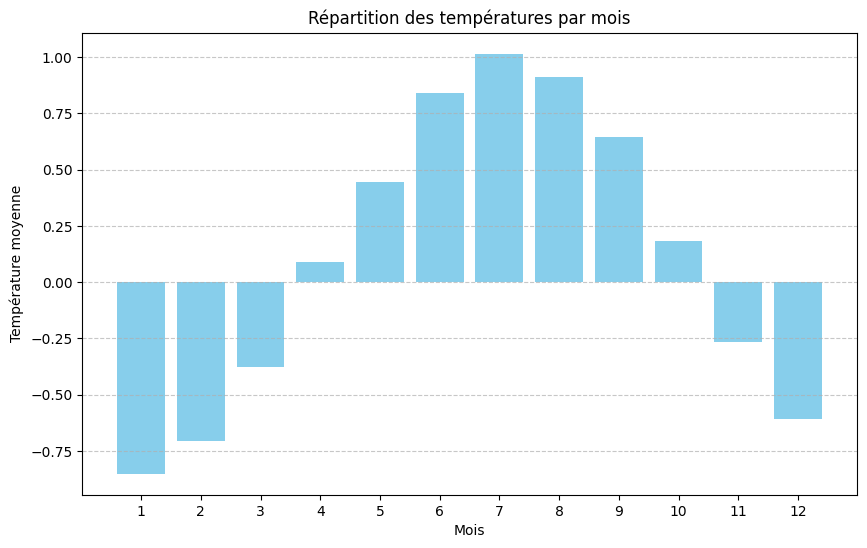

In [97]:

# Extraire le mois de la date
dataset['month'] = dataset['Crash Date/Time'].dt.month

# Calculer la température moyenne par mois
temp_moyenne_par_mois = dataset.groupby('month')['temperature_normalized_year'].mean()

# Diagramme en bâtons
plt.figure(figsize=(10,6))
plt.bar(temp_moyenne_par_mois.index, temp_moyenne_par_mois.values, color='skyblue')
plt.xticks(range(1,13))  # Mois de 1 à 12
plt.xlabel('Mois')
plt.ylabel('Température moyenne')
plt.title('Répartition des températures par mois')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# III. Descriptive Analysis <a id="descriptive"></a>

This section is devoted to descriptive statistical analyses designed to characterize the dataset and explore preliminary relationships between key variables. We begin by constructing categorical variables from selected continuous and nominal features in order to enable stratified analyses and improve interpretability. We then perform an exploratory analysis of the newly added meteorological variables, focusing on their distributions, central tendencies, and variability.

Subsequently, we investigate the association between nighttime conditions and the proportion of drivers involved in substance abuse, using summary statistics and comparative measures. We also examine the relationship between traffic accidents and standardized weather codes, followed by a spatial analysis in which accident occurrences are visualized on area maps under multiple conditions. Finally, we analyze injury severity outcomes and assess how accident frequencies vary across different meteorological conditions, providing an initial descriptive foundation for subsequent inferential modeling.

In [47]:
### Nom des database que nous allons utiliser 

# Database avec 100 000 lignes sans météo -> bigbase_final
# Database avec météo mais sample -> 

## III.1 Construction of Categorical Variables <a id="categorical"></a>


We create new categorical variables derived from the textual variables Driver_Under_Influence and Injury Severity in order to facilitate descriptive statistical analyses and support subsequent predictive modeling. This transformation allows for clearer interpretation and more efficient use of these variables in both exploratory and inferential frameworks.

### Case of substance consumption 

In [7]:


if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    print("completed_dataset_sample.csv file not found.")


import pandas as pd
import numpy as np

# here we call the million line dataset 
big_dataset=pd.read_csv("Crash_Reporting_-_Drivers_Data.csv").copy()

/var/folders/5v/9b211qsj52sgwg1mx65bdc9m0000gn/T/ipykernel_61179/3661937335.py:11: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  big_dataset=pd.read_csv("Crash_Reporting_-_Drivers_Data.csv").copy()


In [8]:
## V1: AVEC LE SAMPLE

# variable driver_substance_abuse has 3 categories: 0 (No), 1 (Yes), 2 (Unknown)

# adding a column to the dataset indicating whether the driver was under the influence or not

under_influence_modalities = [
    "ALCOHOL PRESENT",
    "ALCOHOL CONTRIBUTED",
    "ILLEGAL DRUG PRESENT",
    "ILLEGAL DRUG CONTRIBUTED",
    "Suspect of Alcohol Use, Not Suspect of Drug Use",
    "Suspect of Alcohol Use, Unknown",
    "Suspect of Alcohol Use, Suspect of Drug Use",
    "COMBINED SUBSTANCE PRESENT",
    "MEDICATION CONTRIBUTED",
    "MEDICATION PRESENT",
]

# We apply this to the two types of datasets : 
car_accidents_data["Driver_Under_Influence"] = car_accidents_data["Driver Substance Abuse"].apply(
    lambda x: 1 if x in under_influence_modalities else 0
)


bigbase_final["Driver_Under_Influence"] = bigbase_final["Driver Substance Abuse"].apply(
    lambda x: 1 if x in under_influence_modalities else 0
)

bigbase_final["Driver_Under_Influence"].value_counts()
car_accidents_data["Driver_Under_Influence"].value_counts()




NameError: name 'bigbase_final' is not defined

### Case of injury 

In [102]:

# Mapping dictionary
injury_map = {
    'NO APPARENT INJURY': 0,
    'No Apparent Injury': 0,
    'POSSIBLE INJURY': 1,
    'Possible Injury': 1,
    'SUSPECTED MINOR INJURY': 1,
    'Suspected Minor Injury': 1,
    'SUSPECTED SERIOUS INJURY': 2,
    'Suspected Serious Injury': 2,
    'FATAL INJURY': 2,
    'Fatal Injury': 2,
    np.nan: np.nan
}

# We apply this to the two types of datasets : 
dataset['injury_severity_num'] = dataset['Injury Severity'].map(injury_map)
bigbase_final['injury_severity_num'] = bigbase_final['Injury Severity'].map(injury_map)

# Check results
print(dataset[['Injury Severity', 'injury_severity_num']].head(10))


          Injury Severity  injury_severity_num
0      NO APPARENT INJURY                  0.0
1         POSSIBLE INJURY                  1.0
2      NO APPARENT INJURY                  0.0
3         POSSIBLE INJURY                  1.0
4      NO APPARENT INJURY                  0.0
5  SUSPECTED MINOR INJURY                  1.0
6      No Apparent Injury                  0.0
7  Suspected Minor Injury                  1.0
8      No Apparent Injury                  0.0
9      NO APPARENT INJURY                  0.0


 II.1) Repartition of the modalities of variables

In [51]:
car_accidents_data.head()

print(car_accidents_data["weather_code"].value_counts())

weather_code
3.0     2116
0.0     1938
1.0      725
2.0      593
51.0     533
53.0     184
61.0     156
63.0     104
55.0      64
73.0      37
71.0      26
75.0      13
65.0       9
Name: count, dtype: int64


## III.2 Preliminary Analysis of the New Meteorological Variables <a id="weather_analysis"></a>


We examine the distribution of observations for each meteorological variable in the dataset using simple graphical representations.

We first implement functions to generate histograms for the variables of interest.

In [9]:
# The goal here is to get an intuition through a spacial visualation of our weather variables


def plot_numeric_histogram(df, column_name, bins=30, color='skyblue'):
    """
    Displays the histogram of a numerical variable.

    Arguments:
    df : pandas.DataFrame
    column_name : str, name of the numerical column
    bins : int, number of bins for the histogram (default: 30)
    color : str, color of the histogram (default: 'skyblue')
    """
    plt.figure(figsize=(8,5))
    plt.hist(df[column_name].dropna(), bins=bins, color=color, edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.show()


### Case of Temperature

In [10]:
plot_numeric_histogram(dataset, "temperature", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "temperature_normalized", bins=30, color='red')
plot_numeric_histogram(dataset, "temperature_normalized_year", bins=30, color='brown')


NameError: name 'dataset' is not defined

For the non-normalized temperature variable, we observe a wide range of values, which is expected since temperatures from all months of the year are considered. The temperature normalized at the annual level exhibits a similar pattern. In contrast, the monthly normalized temperature shows limited deviation from seasonal norms, indicating that few observations correspond to unusually extreme temperatures for a given month.

### Case of precipitation

We observe that most days correspond to low precipitation levels. The normalized version of this variable exhibits a similar distribution.

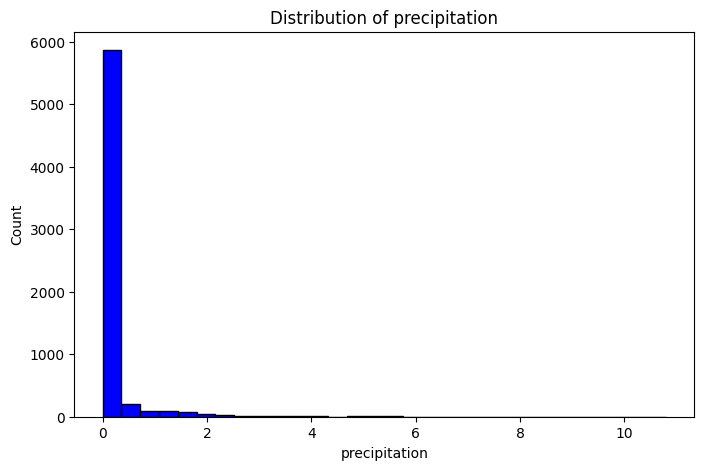

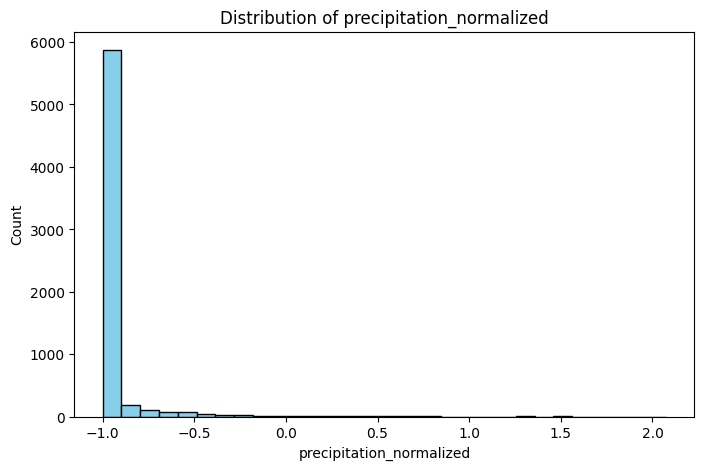

In [54]:
plot_numeric_histogram(dataset, "precipitation", bins=30, color='blue')
plot_numeric_histogram(dataset, "precipitation_normalized", bins=30, color='skyblue')

The distribution of precipitation (measured in millimeters) is highly right-skewed, with the vast majority of observations concentrated near zero, indicating that most car accidents occurs in days that experience little to no rainfall. A small number of days exhibit substantially higher precipitation values, forming a long right tail. The normalized precipitation variable shows a very similar pattern, with most observations taking negative values, reflecting precipitation levels below the annual average. Overall, both representations confirm that heavy rainfall events are relatively rare in the dataset, while low-precipitation conditions dominate.

### Case of snowfall

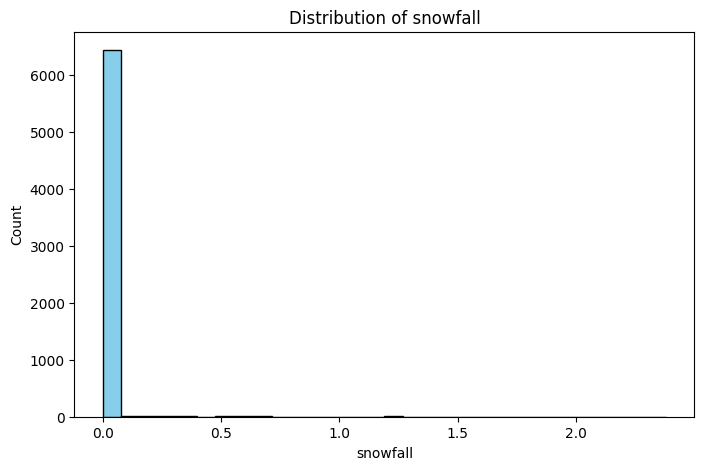

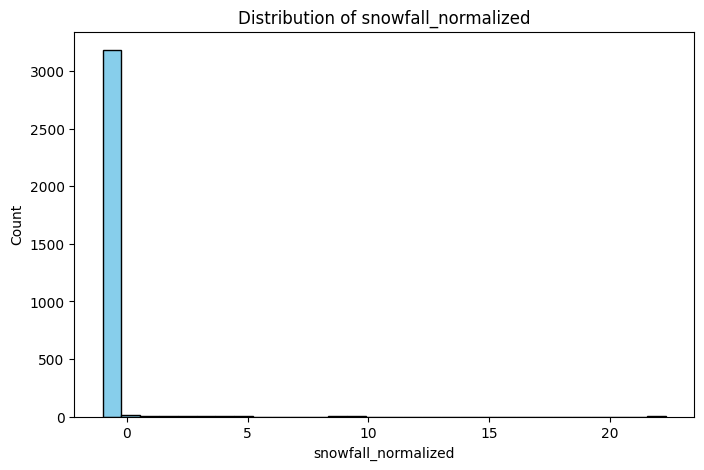

In [55]:
plot_numeric_histogram(dataset, "snowfall", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "snowfall_normalized", bins=30, color='skyblue')

We observe that snowfall is extremely rare in Montgomery County; consequently, the snowfall variable will be excluded from the analysis.

### Case of wind speed

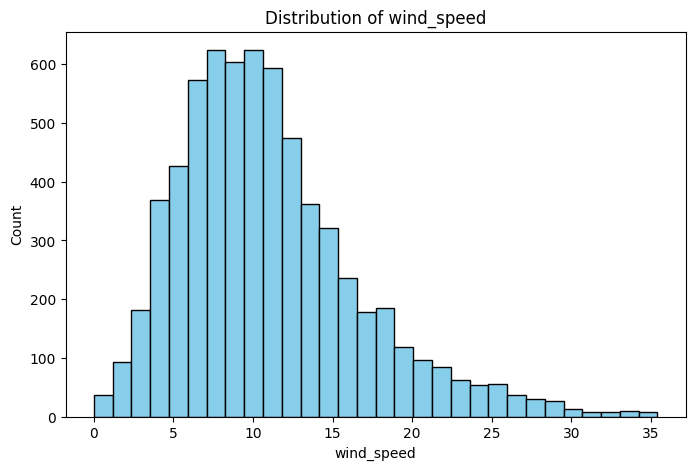

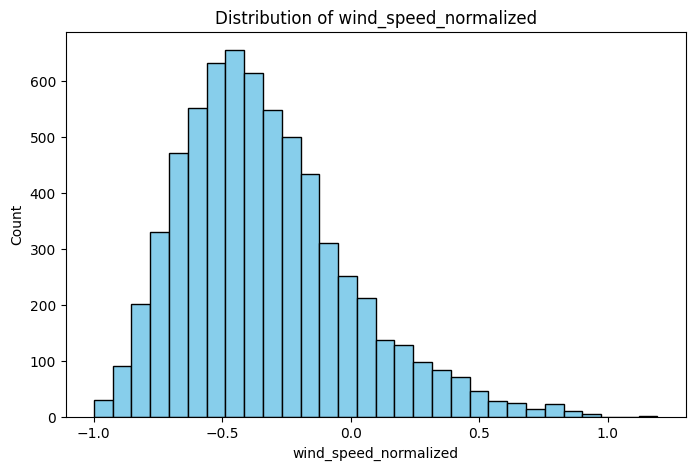

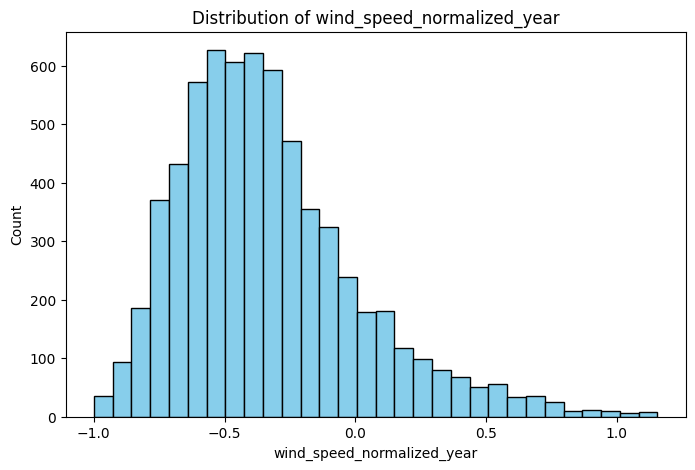

In [56]:
plot_numeric_histogram(dataset, "wind_speed", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "wind_speed_normalized", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "wind_speed_normalized_year", bins=30, color='skyblue')

According to the API documentation, wind speed is measured in kilometers per hour (km/h). The wind_speed variable displays a very similar distribution in both its raw and normalized forms, with the highest concentration of observations around 10 km/h. In the normalized representation, accident occurrences are predominantly associated with negative values (around −0.5), suggesting that a larger number of accidents take place under wind conditions below the annual average. However, this observation is purely descriptive and does not imply a causal relationship. Overall, wind speed appears to exhibit limited variability in relation to accident occurrence, indicating that it may have a relatively weak explanatory role in the context of traffic accidents compared to other factors.

### Weather code 

{Mettre un reminder sur le fonctionnement du Weather code}

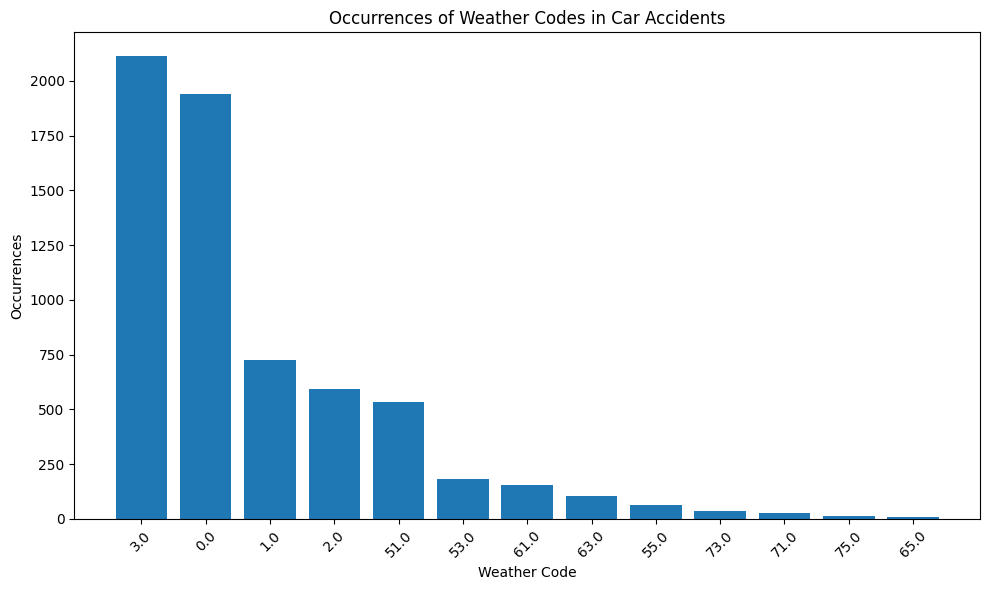

In [57]:
# Plotting the graphs with the proportion of weather_code in Car Accidents
#labels = ["Not Under Influence", "Under Influence"]
# compter les occurrences
counts = car_accidents_data["weather_code"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(counts.index.astype(str), counts.values)  # aucun style/couleur imposé
plt.xlabel("Weather Code")
plt.ylabel("Occurrences")
plt.title("Occurrences of Weather Codes in Car Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## III.3 Correlation between night and the percentage of accident with Driver Substance Abuse <a id="drogue"></a>


In [60]:
car_accidents_data.columns

Index(['Unnamed: 0.11', 'Unnamed: 0.10', 'Unnamed: 0.9', 'Unnamed: 0.8',
       'Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4',
       'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault',
       'Injury Severity', 'Circumstance', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Latitude

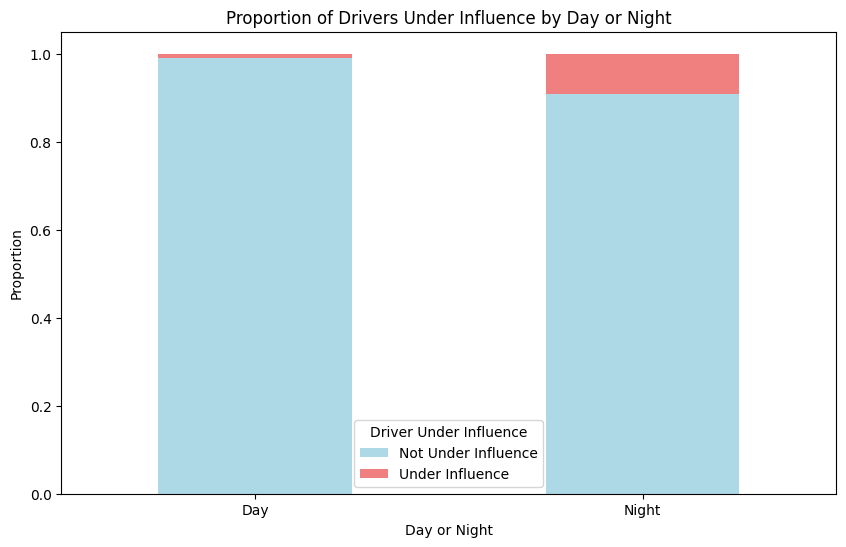

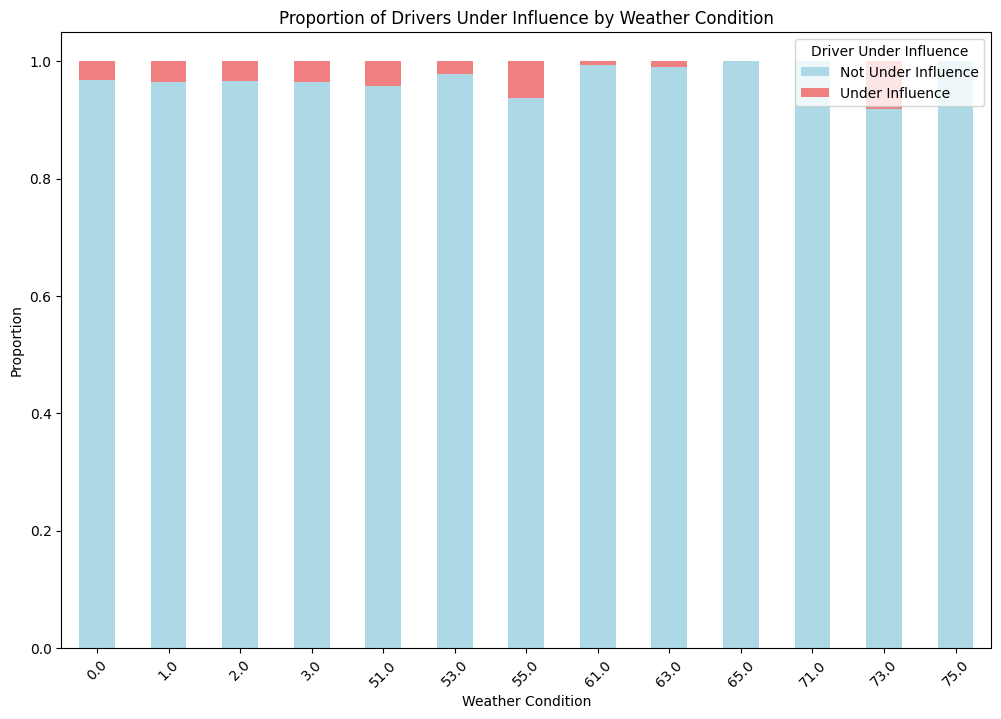

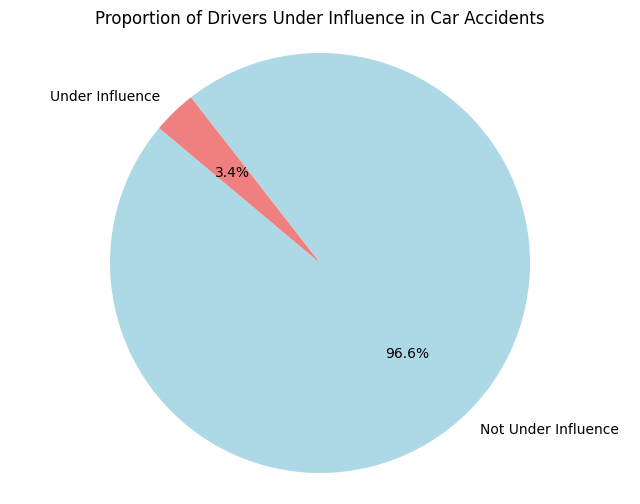

In [63]:
## V1: AVEC LE SAMPLE


# percentage of accident where the driver was under the influence during the night vs day
day_night_influence = pd.crosstab(
    car_accidents_data["day_or_night_code"],
    car_accidents_data["Driver_Under_Influence"],
    rownames=["Day or Night"],
    colnames=["Driver Under Influence"],
    normalize='index'
)

day_night_influence.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title("Proportion of Drivers Under Influence by Day or Night")
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["Day", "Night"], rotation=0)
plt.legend(title="Driver Under Influence", labels=["Not Under Influence", "Under Influence"])
plt.show()


# percentage of accident where the driver was under the influence during different weather conditions
weather_influence = pd.crosstab(
    car_accidents_data["weather_code"],
    car_accidents_data["Driver_Under_Influence"],
    rownames=["Weather Condition"],
    colnames=["Driver Under Influence"],
    normalize='index'
)

weather_influence.plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightblue', 'lightcoral'])
plt.title("Proportion of Drivers Under Influence by Weather Condition")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Driver Under Influence", labels=["Not Under Influence", "Under Influence"])
plt.show()

# Plotting the graphs with the proportion of drivers under influence in Car Accidents
labels = ["Not Under Influence", "Under Influence"]
sizes = car_accidents_data["Driver_Under_Influence"].value_counts().values
colors = ['lightblue', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Drivers Under Influence in Car Accidents")
plt.axis('equal')
plt.show()

In [ ]:
print(big_dataset)

### V2: Avec les 1 million de lignes

#### IMPORTANT : le code ne compile pas car il n'y a pas de day or night code dans la grosse data base 

In [ ]:
"""

## V2: Avec les 1 million de lignes

# variable driver_substance_abuse has 3 categories: 0 (No), 1 (Yes), 2 (Unknown)

# adding a column to the dataset indicating whether the driver was under the influence or not

under_influence_modalities = [
    "ALCOHOL PRESENT",
    "ALCOHOL CONTRIBUTED",
    "ILLEGAL DRUG PRESENT",
    "ILLEGAL DRUG CONTRIBUTED",
    "Suspect of Alcohol Use, Not Suspect of Drug Use",
    "Suspect of Alcohol Use, Unknown",
    "Suspect of Alcohol Use, Suspect of Drug Use",
    "COMBINED SUBSTANCE PRESENT",
    "MEDICATION CONTRIBUTED",
    "MEDICATION PRESENT",
]

big_dataset["Driver_Under_Influence"] = big_dataset["Driver Substance Abuse"].apply(
    lambda x: 1 if x in under_influence_modalities else 0
)

big_dataset["Driver_Under_Influence"].value_counts()

import matplotlib.pyplot as plt
# percentage of accident where the driver was under the influence during the night vs day
day_night_influence = pd.crosstab(
    big_dataset["day_or_night_code"],
    big_dataset["Driver_Under_Influence"],
    rownames=["Day or Night"],
    colnames=["Driver Under Influence"],
    normalize='index'
)

day_night_influence.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title("Proportion of Drivers Under Influence by Day or Night")
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["Day", "Night"], rotation=0)
plt.legend(title="Driver Under Influence", labels=["Not Under Influence", "Under Influence"])
plt.show()


# percentage of accident where the driver was under the influence during different weather conditions
weather_influence = pd.crosstab(
    big_dataset["weather_code"],
    big_dataset["Driver_Under_Influence"],
    rownames=["Weather Condition"],
    colnames=["Driver Under Influence"],
    normalize='index'
)

weather_influence.plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightblue', 'lightcoral'])
plt.title("Proportion of Drivers Under Influence by Weather Condition")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Driver Under Influence", labels=["Not Under Influence", "Under Influence"])
plt.show()

# Plotting the graphs with the proportion of drivers under influence in Car Accidents
labels = ["Not Under Influence", "Under Influence"]
sizes = big_dataset["Driver_Under_Influence"].value_counts().values
colors = ['lightblue', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Drivers Under Influence in Car Accidents")
plt.axis('equal')
plt.show()

"""

## III.4 Plotting area map with multiple conditions <a id="map"></a>


In [ ]:
print(car_accidents_data)

In [64]:
# Extraire la date
car_accidents_data['Date'] = car_accidents_data['Crash Date/Time'].str.split(" ").str[0]

# Convertir l'heure en format 24h
def convert_to_24h(date_time):
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)

    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    return accident_time_24h

car_accidents_data['Accident time in 24h format'] = car_accidents_data['Crash Date/Time'].apply(convert_to_24h)

car_accidents_data[['Crash Date/Time', 'Date', 'Accident time in 24h format', 'Latitude', 'Longitude']].head()

Crash Date/Time        Date Accident time in 24h format   Latitude  \
0  04/12/2022 07:40:00 AM  04/12/2022                    07:40:00  39.084912   
1  06/23/2016 10:35:00 AM  06/23/2016                    10:35:00  39.013298   
2  03/09/2016 07:00:00 AM  03/09/2016                    07:00:00  39.026372   
3  05/14/2018 06:55:00 AM  05/14/2018                    06:55:00  39.176243   
4  05/06/2020 03:02:00 PM  05/06/2020                    15:02:00  38.992689   

   Longitude  
0 -77.076068  
1 -77.045822  
2 -77.204397  
3 -77.118350  
4 -77.161965

In [65]:
## V2: Avec les 1M de lignes

# Extraire la date
bigbase_final['Date'] = bigbase_final['Crash Date/Time'].str.split(" ").str[0]

# Convertir l'heure en format 24h
def convert_to_24h(date_time):
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)

    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    return accident_time_24h

bigbase_final['Accident time in 24h format'] = bigbase_final['Crash Date/Time'].apply(convert_to_24h)

bigbase_final[['Crash Date/Time', 'Date', 'Accident time in 24h format', 'Latitude', 'Longitude']].head()

Crash Date/Time        Date Accident time in 24h format   Latitude  \
4   03/12/2024 07:30:00 AM  03/12/2024                    07:30:00  39.090304   
6   05/01/2024 07:47:00 PM  05/01/2024                    19:47:00  39.074780   
9   05/24/2024 04:16:00 PM  05/24/2024                    16:16:00  39.143230   
11  05/05/2024 01:04:00 AM  05/05/2024                    01:04:00  38.979433   
12  05/07/2024 04:05:00 PM  05/07/2024                    16:05:00  38.995360   

    Longitude  
4  -77.071180  
6  -77.005133  
9  -77.200655  
11 -77.009016  
12 -77.024414

In [66]:

# Centre approximatif de la zone (Maryland / Washington DC selon ton extrait)
center_lat = car_accidents_data["Latitude"].mean()
center_lon = car_accidents_data["Longitude"].mean()

# Création de la carte
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Ajout des points
for _, row in car_accidents_data.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        fill=True,
        fill_opacity=0.7,
        opacity=0.7,
        color='red' #if row["Driver_Under_Influence"] == 1 else 'blue',
    ).add_to(m)

# Affichage de la carte
m

#enregistrer la carte sous format html
m.save("car_accidents_map.html")


In [67]:
# Extraire la date
car_accidents_data['Date'] = car_accidents_data['Crash Date/Time'].str.split(" ").str[0]

# Convertir l'heure en format 24h
def convert_to_24h(date_time):
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)

    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    return accident_time_24h

car_accidents_data['Accident time in 24h format'] = car_accidents_data['Crash Date/Time'].apply(convert_to_24h)

car_accidents_data[['Crash Date/Time', 'Date', 'Accident time in 24h format', 'Latitude', 'Longitude']].head()

Crash Date/Time        Date Accident time in 24h format   Latitude  \
0  04/12/2022 07:40:00 AM  04/12/2022                    07:40:00  39.084912   
1  06/23/2016 10:35:00 AM  06/23/2016                    10:35:00  39.013298   
2  03/09/2016 07:00:00 AM  03/09/2016                    07:00:00  39.026372   
3  05/14/2018 06:55:00 AM  05/14/2018                    06:55:00  39.176243   
4  05/06/2020 03:02:00 PM  05/06/2020                    15:02:00  38.992689   

   Longitude  
0 -77.076068  
1 -77.045822  
2 -77.204397  
3 -77.118350  
4 -77.161965

### Day VS Night

In [68]:

# Centre approximatif
center_lat = car_accidents_data["Latitude"].mean()
center_lon = car_accidents_data["Longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

for _, row in car_accidents_data.iterrows():
    
    color = 'yellow' if row["day_or_night_code"] == 0 else 'purple'
    label = "Day" if row["day_or_night_code"] == 0 else "Night"
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        fill=True,
        fill_opacity=0.7,
        opacity=0.7,
        color=color,
        tooltip=f"{label}"
    ).add_to(m)

m

m.save("car_accidents_map_day_vs_night.html")

### Weather code

In [69]:

weather_mapping = {
    0.0: ("skyblue", "Clear"),
    1.0: ("blue", "Rain"),
    2.0: ("white", "Snow"),
    3.0: ("gray", "Fog"),
    51.0: ("lightblue", "Drizzle"),
    53.0: ("deepskyblue", "Rain Shower"),
    55.0: ("darkblue", "Heavy Rain"),
    61.0: ("lightgray", "Sleet"),
    63.0: ("silver", "Freezing Rain"),
    65.0: ("darkgray", "Hail"),
    71.0: ("snow", "Snowfall Light"),
    73.0: ("whitesmoke", "Snowfall Moderate"),
    75.0: ("aliceblue", "Snowfall Heavy"),
}

# Centre de la carte
center_lat = car_accidents_data["Latitude"].mean()
center_lon = car_accidents_data["Longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Ajout des points avec couleur selon weather_code
for _, row in car_accidents_data.iterrows():
    color, label = weather_mapping.get(row["weather_code"], ("black", "Unknown"))
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        fill=True,
        fill_opacity=0.7,
        opacity=0.7,
        color=color,
        tooltip=f"Weather: {label}"
    ).add_to(m)

m

#enregistrer la carte sous format html
m.save("car_accidents_map_by_weather.html")


### Animated version, of 10s

In [70]:
from folium.plugins import TimestampedGeoJson

# Reconstruction robuste du datetime
car_accidents_data["datetime"] = pd.to_datetime(
    car_accidents_data["Date"] + " " + car_accidents_data["Accident time in 24h format"],
    errors="coerce"
)

df = car_accidents_data.dropna(subset=["datetime"]).sort_values("datetime")

# Centre de la carte
center_lat = df["Latitude"].mean()
center_lon = df["Longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Construction du GeoJSON animé (format "times": [...])
features = []
for _, row in df.iterrows():
    iso_time = row["datetime"].strftime("%Y-%m-%dT%H:%M:%S")
    
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [row["Longitude"], row["Latitude"]],
        },
        "properties": {
            "times": [iso_time],
            "popup": f"{iso_time}",
            "icon": "circle",
            "iconstyle": {
                "radius": 4,
                "color": "red",
                "fillColor": "red",
                "fillOpacity": 0.7
            }
        }
    })

TimestampedGeoJson(
    {"type": "FeatureCollection", "features": features},
    period="PT1S",
    duration="PT10S",
    auto_play=True,
    loop=False,
    add_last_point=True
).add_to(m)

m


### Drafts

In [78]:

car_accidents_data["Datetime"] = pd.to_datetime(
    car_accidents_data["Date"] + " " + car_accidents_data["Accident time in 24h format"]
)
car_accidents_data = car_accidents_data.sort_values("Datetime")
car_accidents_data["DatetimeStr"] = car_accidents_data["Datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

# Pour réduire le nombre de frames, on peut arrondir à la minute
car_accidents_data["Minute"] = car_accidents_data["Datetime"].dt.floor('T').astype(str)

fig = px.scatter_mapbox(
    car_accidents_data,
    lat="Latitude",
    lon="Longitude",
    hover_name="DatetimeStr",
    animation_frame="Minute",
    zoom=9,
    height=700,
)

fig.update_layout(
    mapbox_style="open-street-map",
    title="Accidents de voiture dans le temps",
    title_x=0.5
)

# Vitesse de l'animation
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100  # 100 ms par frame
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0

fig.show()

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\2968095537.py:8: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\2968095537.py:10: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [79]:
# we are gonna create an animation in fonction of the time, showing car accidents occuring over time (one car accident remains on the map for 1 second before disappearing)

start_time = time.perf_counter()
n = len(car_accidents_data)

for i in range(0,n):
    print(f"Processing row {i} of {n}")
    latitude = car_accidents_data.iloc[i]['Latitude']
    longitude = car_accidents_data.iloc[i]['Longitude']
    date_time = car_accidents_data.iloc[i]['Crash Date/Time']

    date = date_time.split(" ")[0]
    accident_time = date_time.split(" ")[1] #useless

    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)
    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"
    
    car_accidents_data[i, "Date" ] = date
    car_accidents_data[i, "Accident time in 24h format"] = accident_time_24h


    """
    print("Latitude: ", latitude)
    print("Longitude: ", longitude)
    print("Date: ", date)
    print("Accident time in 24h format: ", accident_time_24h)
    """

Processing row 0 of 6498
Processing row 1 of 6498
Processing row 2 of 6498
Processing row 3 of 6498
Processing row 4 of 6498
Processing row 5 of 6498
Processing row 6 of 6498
Processing row 7 of 6498
Processing row 8 of 6498
Processing row 9 of 6498
Processing row 10 of 6498
Processing row 11 of 6498
Processing row 12 of 6498
Processing row 13 of 6498
Processing row 14 of 6498
Processing row 15 of 6498
Processing row 16 of 6498
Processing row 17 of 6498
Processing row 18 of 6498
Processing row 19 of 6498
Processing row 20 of 6498
Processing row 21 of 6498
Processing row 22 of 6498
Processing row 23 of 6498
Processing row 24 of 6498
Processing row 25 of 6498
Processing row 26 of 6498
Processing row 27 of 6498
Processing row 28 of 6498
Processing row 29 of 6498
Processing row 30 of 6498
Processing row 31 of 6498
Processing row 32 of 6498
Processing row 33 of 6498
Processing row 34 of 6498
Processing row 35 of 6498
Processing row 36 of 6498
Processing row 37 of 6498
Processing row 38 of 6

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 133 of 6498
Processing row 134 of 6498
Processing row 135 of 6498
Processing row 136 of 6498
Processing row 137 of 6498
Processing row 138 of 6498
Processing row 139 of 6498
Processing row 140 of 6498
Processing row 141 of 6498
Processing row 142 of 6498
Processing row 143 of 6498
Processing row 144 of 6498
Processing row 145 of 6498
Processing row 146 of 6498
Processing row 147 of 6498
Processing row 148 of 6498
Processing row 149 of 6498
Processing row 150 of 6498
Processing row 151 of 6498
Processing row 152 of 6498
Processing row 153 of 6498
Processing row 154 of 6498
Processing row 155 of 6498
Processing row 156 of 6498
Processing row 157 of 6498
Processing row 158 of 6498
Processing row 159 of 6498
Processing row 160 of 6498
Processing row 161 of 6498
Processing row 162 of 6498
Processing row 163 of 6498
Processing row 164 of 6498
Processing row 165 of 6498
Processing row 166 of 6498
Processing row 167 of 6498
Processing row 168 of 6498
Processing row 169 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 218 of 6498
Processing row 219 of 6498
Processing row 220 of 6498
Processing row 221 of 6498
Processing row 222 of 6498
Processing row 223 of 6498
Processing row 224 of 6498
Processing row 225 of 6498
Processing row 226 of 6498
Processing row 227 of 6498
Processing row 228 of 6498
Processing row 229 of 6498
Processing row 230 of 6498
Processing row 231 of 6498
Processing row 232 of 6498
Processing row 233 of 6498
Processing row 234 of 6498
Processing row 235 of 6498
Processing row 236 of 6498
Processing row 237 of 6498
Processing row 238 of 6498
Processing row 239 of 6498
Processing row 240 of 6498
Processing row 241 of 6498
Processing row 242 of 6498
Processing row 243 of 6498
Processing row 244 of 6498
Processing row 245 of 6498
Processing row 246 of 6498
Processing row 247 of 6498
Processing row 248 of 6498
Processing row 249 of 6498
Processing row 250 of 6498
Processing row 251 of 6498
Processing row 252 of 6498
Processing row 253 of 6498
Processing row 254 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 287 of 6498
Processing row 288 of 6498
Processing row 289 of 6498
Processing row 290 of 6498
Processing row 291 of 6498
Processing row 292 of 6498
Processing row 293 of 6498
Processing row 294 of 6498
Processing row 295 of 6498
Processing row 296 of 6498
Processing row 297 of 6498
Processing row 298 of 6498
Processing row 299 of 6498
Processing row 300 of 6498
Processing row 301 of 6498
Processing row 302 of 6498
Processing row 303 of 6498
Processing row 304 of 6498
Processing row 305 of 6498
Processing row 306 of 6498
Processing row 307 of 6498
Processing row 308 of 6498
Processing row 309 of 6498
Processing row 310 of 6498
Processing row 311 of 6498
Processing row 312 of 6498
Processing row 313 of 6498
Processing row 314 of 6498
Processing row 315 of 6498
Processing row 316 of 6498
Processing row 317 of 6498
Processing row 318 of 6498
Processing row 319 of 6498
Processing row 320 of 6498
Processing row 321 of 6498
Processing row 322 of 6498
Processing row 323 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 355 of 6498
Processing row 356 of 6498
Processing row 357 of 6498
Processing row 358 of 6498
Processing row 359 of 6498
Processing row 360 of 6498
Processing row 361 of 6498
Processing row 362 of 6498
Processing row 363 of 6498
Processing row 364 of 6498
Processing row 365 of 6498
Processing row 366 of 6498
Processing row 367 of 6498
Processing row 368 of 6498
Processing row 369 of 6498
Processing row 370 of 6498
Processing row 371 of 6498
Processing row 372 of 6498
Processing row 373 of 6498
Processing row 374 of 6498
Processing row 375 of 6498
Processing row 376 of 6498
Processing row 377 of 6498
Processing row 378 of 6498
Processing row 379 of 6498
Processing row 380 of 6498
Processing row 381 of 6498
Processing row 382 of 6498
Processing row 383 of 6498
Processing row 384 of 6498
Processing row 385 of 6498
Processing row 386 of 6498
Processing row 387 of 6498
Processing row 388 of 6498
Processing row 389 of 6498
Processing row 390 of 6498
Processing row 391 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 411 of 6498
Processing row 412 of 6498
Processing row 413 of 6498
Processing row 414 of 6498
Processing row 415 of 6498
Processing row 416 of 6498
Processing row 417 of 6498
Processing row 418 of 6498
Processing row 419 of 6498
Processing row 420 of 6498
Processing row 421 of 6498
Processing row 422 of 6498
Processing row 423 of 6498
Processing row 424 of 6498
Processing row 425 of 6498
Processing row 426 of 6498
Processing row 427 of 6498
Processing row 428 of 6498
Processing row 429 of 6498
Processing row 430 of 6498
Processing row 431 of 6498
Processing row 432 of 6498
Processing row 433 of 6498
Processing row 434 of 6498
Processing row 435 of 6498
Processing row 436 of 6498
Processing row 437 of 6498
Processing row 438 of 6498
Processing row 439 of 6498
Processing row 440 of 6498
Processing row 441 of 6498
Processing row 442 of 6498
Processing row 443 of 6498
Processing row 444 of 6498
Processing row 445 of 6498
Processing row 446 of 6498
Processing row 447 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 459 of 6498
Processing row 460 of 6498
Processing row 461 of 6498
Processing row 462 of 6498
Processing row 463 of 6498
Processing row 464 of 6498
Processing row 465 of 6498
Processing row 466 of 6498
Processing row 467 of 6498
Processing row 468 of 6498
Processing row 469 of 6498
Processing row 470 of 6498
Processing row 471 of 6498
Processing row 472 of 6498
Processing row 473 of 6498
Processing row 474 of 6498
Processing row 475 of 6498
Processing row 476 of 6498
Processing row 477 of 6498
Processing row 478 of 6498
Processing row 479 of 6498
Processing row 480 of 6498
Processing row 481 of 6498
Processing row 482 of 6498
Processing row 483 of 6498
Processing row 484 of 6498
Processing row 485 of 6498
Processing row 486 of 6498
Processing row 487 of 6498
Processing row 488 of 6498
Processing row 489 of 6498
Processing row 490 of 6498
Processing row 491 of 6498
Processing row 492 of 6498
Processing row 493 of 6498
Processing row 494 of 6498
Processing row 495 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 505 of 6498
Processing row 506 of 6498
Processing row 507 of 6498
Processing row 508 of 6498
Processing row 509 of 6498
Processing row 510 of 6498
Processing row 511 of 6498
Processing row 512 of 6498
Processing row 513 of 6498
Processing row 514 of 6498
Processing row 515 of 6498
Processing row 516 of 6498
Processing row 517 of 6498
Processing row 518 of 6498
Processing row 519 of 6498
Processing row 520 of 6498
Processing row 521 of 6498
Processing row 522 of 6498
Processing row 523 of 6498
Processing row 524 of 6498
Processing row 525 of 6498
Processing row 526 of 6498
Processing row 527 of 6498
Processing row 528 of 6498
Processing row 529 of 6498
Processing row 530 of 6498
Processing row 531 of 6498
Processing row 532 of 6498
Processing row 533 of 6498
Processing row 534 of 6498
Processing row 535 of 6498
Processing row 536 of 6498
Processing row 537 of 6498
Processing row 538 of 6498
Processing row 539 of 6498
Processing row 540 of 6498
Processing row 541 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 548 of 6498
Processing row 549 of 6498
Processing row 550 of 6498
Processing row 551 of 6498
Processing row 552 of 6498
Processing row 553 of 6498
Processing row 554 of 6498
Processing row 555 of 6498
Processing row 556 of 6498
Processing row 557 of 6498
Processing row 558 of 6498
Processing row 559 of 6498
Processing row 560 of 6498
Processing row 561 of 6498
Processing row 562 of 6498
Processing row 563 of 6498
Processing row 564 of 6498
Processing row 565 of 6498
Processing row 566 of 6498
Processing row 567 of 6498
Processing row 568 of 6498
Processing row 569 of 6498
Processing row 570 of 6498
Processing row 571 of 6498
Processing row 572 of 6498
Processing row 573 of 6498
Processing row 574 of 6498
Processing row 575 of 6498
Processing row 576 of 6498
Processing row 577 of 6498
Processing row 578 of 6498
Processing row 579 of 6498
Processing row 580 of 6498
Processing row 581 of 6498
Processing row 582 of 6498
Processing row 583 of 6498
Processing row 584 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 588 of 6498
Processing row 589 of 6498
Processing row 590 of 6498
Processing row 591 of 6498
Processing row 592 of 6498
Processing row 593 of 6498
Processing row 594 of 6498
Processing row 595 of 6498
Processing row 596 of 6498
Processing row 597 of 6498
Processing row 598 of 6498
Processing row 599 of 6498
Processing row 600 of 6498
Processing row 601 of 6498
Processing row 602 of 6498
Processing row 603 of 6498
Processing row 604 of 6498
Processing row 605 of 6498
Processing row 606 of 6498
Processing row 607 of 6498
Processing row 608 of 6498
Processing row 609 of 6498
Processing row 610 of 6498
Processing row 611 of 6498
Processing row 612 of 6498
Processing row 613 of 6498
Processing row 614 of 6498
Processing row 615 of 6498
Processing row 616 of 6498
Processing row 617 of 6498
Processing row 618 of 6498
Processing row 619 of 6498
Processing row 620 of 6498
Processing row 621 of 6498
Processing row 622 of 6498
Processing row 623 of 6498
Processing row 624 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 633 of 6498
Processing row 634 of 6498
Processing row 635 of 6498
Processing row 636 of 6498
Processing row 637 of 6498
Processing row 638 of 6498
Processing row 639 of 6498
Processing row 640 of 6498
Processing row 641 of 6498
Processing row 642 of 6498
Processing row 643 of 6498
Processing row 644 of 6498
Processing row 645 of 6498
Processing row 646 of 6498
Processing row 647 of 6498
Processing row 648 of 6498
Processing row 649 of 6498
Processing row 650 of 6498
Processing row 651 of 6498
Processing row 652 of 6498
Processing row 653 of 6498
Processing row 654 of 6498
Processing row 655 of 6498
Processing row 656 of 6498
Processing row 657 of 6498
Processing row 658 of 6498
Processing row 659 of 6498
Processing row 660 of 6498
Processing row 661 of 6498
Processing row 662 of 6498
Processing row 663 of 6498
Processing row 664 of 6498
Processing row 665 of 6498
Processing row 666 of 6498
Processing row 667 of 6498
Processing row 668 of 6498
Processing row 669 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 673 of 6498
Processing row 674 of 6498
Processing row 675 of 6498
Processing row 676 of 6498
Processing row 677 of 6498
Processing row 678 of 6498
Processing row 679 of 6498
Processing row 680 of 6498
Processing row 681 of 6498
Processing row 682 of 6498
Processing row 683 of 6498
Processing row 684 of 6498
Processing row 685 of 6498
Processing row 686 of 6498
Processing row 687 of 6498
Processing row 688 of 6498
Processing row 689 of 6498
Processing row 690 of 6498
Processing row 691 of 6498
Processing row 692 of 6498
Processing row 693 of 6498
Processing row 694 of 6498
Processing row 695 of 6498
Processing row 696 of 6498
Processing row 697 of 6498
Processing row 698 of 6498
Processing row 699 of 6498
Processing row 700 of 6498
Processing row 701 of 6498
Processing row 702 of 6498
Processing row 703 of 6498
Processing row 704 of 6498
Processing row 705 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 706 of 6498
Processing row 707 of 6498
Processing row 708 of 6498
Processing row 709 of 6498
Processing row 710 of 6498
Processing row 711 of 6498
Processing row 712 of 6498
Processing row 713 of 6498
Processing row 714 of 6498
Processing row 715 of 6498
Processing row 716 of 6498
Processing row 717 of 6498
Processing row 718 of 6498
Processing row 719 of 6498
Processing row 720 of 6498
Processing row 721 of 6498
Processing row 722 of 6498
Processing row 723 of 6498
Processing row 724 of 6498
Processing row 725 of 6498
Processing row 726 of 6498
Processing row 727 of 6498
Processing row 728 of 6498
Processing row 729 of 6498
Processing row 730 of 6498
Processing row 731 of 6498
Processing row 732 of 6498
Processing row 733 of 6498
Processing row 734 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 735 of 6498
Processing row 736 of 6498
Processing row 737 of 6498
Processing row 738 of 6498
Processing row 739 of 6498
Processing row 740 of 6498
Processing row 741 of 6498
Processing row 742 of 6498
Processing row 743 of 6498
Processing row 744 of 6498
Processing row 745 of 6498
Processing row 746 of 6498
Processing row 747 of 6498
Processing row 748 of 6498
Processing row 749 of 6498
Processing row 750 of 6498
Processing row 751 of 6498
Processing row 752 of 6498
Processing row 753 of 6498
Processing row 754 of 6498
Processing row 755 of 6498
Processing row 756 of 6498
Processing row 757 of 6498
Processing row 758 of 6498
Processing row 759 of 6498
Processing row 760 of 6498
Processing row 761 of 6498
Processing row 762 of 6498
Processing row 763 of 6498
Processing row 764 of 6498
Processing row 765 of 6498
Processing row 766 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 767 of 6498
Processing row 768 of 6498
Processing row 769 of 6498
Processing row 770 of 6498
Processing row 771 of 6498
Processing row 772 of 6498
Processing row 773 of 6498
Processing row 774 of 6498
Processing row 775 of 6498
Processing row 776 of 6498
Processing row 777 of 6498
Processing row 778 of 6498
Processing row 779 of 6498
Processing row 780 of 6498
Processing row 781 of 6498
Processing row 782 of 6498
Processing row 783 of 6498
Processing row 784 of 6498
Processing row 785 of 6498
Processing row 786 of 6498
Processing row 787 of 6498
Processing row 788 of 6498
Processing row 789 of 6498
Processing row 790 of 6498
Processing row 791 of 6498
Processing row 792 of 6498
Processing row 793 of 6498
Processing row 794 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 795 of 6498
Processing row 796 of 6498
Processing row 797 of 6498
Processing row 798 of 6498
Processing row 799 of 6498
Processing row 800 of 6498
Processing row 801 of 6498
Processing row 802 of 6498
Processing row 803 of 6498
Processing row 804 of 6498
Processing row 805 of 6498
Processing row 806 of 6498
Processing row 807 of 6498
Processing row 808 of 6498
Processing row 809 of 6498
Processing row 810 of 6498
Processing row 811 of 6498
Processing row 812 of 6498
Processing row 813 of 6498
Processing row 814 of 6498
Processing row 815 of 6498
Processing row 816 of 6498
Processing row 817 of 6498
Processing row 818 of 6498
Processing row 819 of 6498
Processing row 820 of 6498
Processing row 821 of 6498
Processing row 822 of 6498
Processing row 823 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 824 of 6498
Processing row 825 of 6498
Processing row 826 of 6498
Processing row 827 of 6498
Processing row 828 of 6498
Processing row 829 of 6498
Processing row 830 of 6498
Processing row 831 of 6498
Processing row 832 of 6498
Processing row 833 of 6498
Processing row 834 of 6498
Processing row 835 of 6498
Processing row 836 of 6498
Processing row 837 of 6498
Processing row 838 of 6498
Processing row 839 of 6498
Processing row 840 of 6498
Processing row 841 of 6498
Processing row 842 of 6498
Processing row 843 of 6498
Processing row 844 of 6498
Processing row 845 of 6498
Processing row 846 of 6498
Processing row 847 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 848 of 6498
Processing row 849 of 6498
Processing row 850 of 6498
Processing row 851 of 6498
Processing row 852 of 6498
Processing row 853 of 6498
Processing row 854 of 6498
Processing row 855 of 6498
Processing row 856 of 6498
Processing row 857 of 6498
Processing row 858 of 6498
Processing row 859 of 6498
Processing row 860 of 6498
Processing row 861 of 6498
Processing row 862 of 6498
Processing row 863 of 6498
Processing row 864 of 6498
Processing row 865 of 6498
Processing row 866 of 6498
Processing row 867 of 6498
Processing row 868 of 6498
Processing row 869 of 6498
Processing row 870 of 6498
Processing row 871 of 6498
Processing row 872 of 6498
Processing row 873 of 6498
Processing row 874 of 6498
Processing row 875 of 6498
Processing row 876 of 6498
Processing row 877 of 6498
Processing row 878 of 6498
Processing row 879 of 6498
Processing row 880 of 6498
Processing row 881 of 6498
Processing row 882 of 6498
Processing row 883 of 6498
Processing row 884 of 6498
P

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 886 of 6498
Processing row 887 of 6498
Processing row 888 of 6498
Processing row 889 of 6498
Processing row 890 of 6498
Processing row 891 of 6498
Processing row 892 of 6498
Processing row 893 of 6498
Processing row 894 of 6498
Processing row 895 of 6498
Processing row 896 of 6498
Processing row 897 of 6498
Processing row 898 of 6498
Processing row 899 of 6498
Processing row 900 of 6498
Processing row 901 of 6498
Processing row 902 of 6498
Processing row 903 of 6498
Processing row 904 of 6498
Processing row 905 of 6498
Processing row 906 of 6498
Processing row 907 of 6498
Processing row 908 of 6498
Processing row 909 of 6498
Processing row 910 of 6498
Processing row 911 of 6498
Processing row 912 of 6498
Processing row 913 of 6498
Processing row 914 of 6498
Processing row 915 of 6498
Processing row 916 of 6498
Processing row 917 of 6498
Processing row 918 of 6498
Processing row 919 of 6498
Processing row 920 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 921 of 6498
Processing row 922 of 6498
Processing row 923 of 6498
Processing row 924 of 6498
Processing row 925 of 6498
Processing row 926 of 6498
Processing row 927 of 6498
Processing row 928 of 6498
Processing row 929 of 6498
Processing row 930 of 6498
Processing row 931 of 6498
Processing row 932 of 6498
Processing row 933 of 6498
Processing row 934 of 6498
Processing row 935 of 6498
Processing row 936 of 6498
Processing row 937 of 6498
Processing row 938 of 6498
Processing row 939 of 6498
Processing row 940 of 6498
Processing row 941 of 6498
Processing row 942 of 6498
Processing row 943 of 6498
Processing row 944 of 6498
Processing row 945 of 6498
Processing row 946 of 6498
Processing row 947 of 6498
Processing row 948 of 6498
Processing row 949 of 6498
Processing row 950 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 951 of 6498
Processing row 952 of 6498
Processing row 953 of 6498
Processing row 954 of 6498
Processing row 955 of 6498
Processing row 956 of 6498
Processing row 957 of 6498
Processing row 958 of 6498
Processing row 959 of 6498
Processing row 960 of 6498
Processing row 961 of 6498
Processing row 962 of 6498
Processing row 963 of 6498
Processing row 964 of 6498
Processing row 965 of 6498
Processing row 966 of 6498
Processing row 967 of 6498
Processing row 968 of 6498
Processing row 969 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 970 of 6498
Processing row 971 of 6498
Processing row 972 of 6498
Processing row 973 of 6498
Processing row 974 of 6498
Processing row 975 of 6498
Processing row 976 of 6498
Processing row 977 of 6498
Processing row 978 of 6498
Processing row 979 of 6498
Processing row 980 of 6498
Processing row 981 of 6498
Processing row 982 of 6498
Processing row 983 of 6498
Processing row 984 of 6498
Processing row 985 of 6498
Processing row 986 of 6498
Processing row 987 of 6498
Processing row 988 of 6498
Processing row 989 of 6498
Processing row 990 of 6498
Processing row 991 of 6498
Processing row 992 of 6498
Processing row 993 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 994 of 6498
Processing row 995 of 6498
Processing row 996 of 6498
Processing row 997 of 6498
Processing row 998 of 6498
Processing row 999 of 6498
Processing row 1000 of 6498
Processing row 1001 of 6498
Processing row 1002 of 6498
Processing row 1003 of 6498
Processing row 1004 of 6498
Processing row 1005 of 6498
Processing row 1006 of 6498
Processing row 1007 of 6498
Processing row 1008 of 6498
Processing row 1009 of 6498
Processing row 1010 of 6498
Processing row 1011 of 6498
Processing row 1012 of 6498
Processing row 1013 of 6498
Processing row 1014 of 6498
Processing row 1015 of 6498
Processing row 1016 of 6498
Processing row 1017 of 6498
Processing row 1018 of 6498
Processing row 1019 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1020 of 6498
Processing row 1021 of 6498
Processing row 1022 of 6498
Processing row 1023 of 6498
Processing row 1024 of 6498
Processing row 1025 of 6498
Processing row 1026 of 6498
Processing row 1027 of 6498
Processing row 1028 of 6498
Processing row 1029 of 6498
Processing row 1030 of 6498
Processing row 1031 of 6498
Processing row 1032 of 6498
Processing row 1033 of 6498
Processing row 1034 of 6498
Processing row 1035 of 6498
Processing row 1036 of 6498
Processing row 1037 of 6498
Processing row 1038 of 6498
Processing row 1039 of 6498
Processing row 1040 of 6498
Processing row 1041 of 6498
Processing row 1042 of 6498
Processing row 1043 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1044 of 6498
Processing row 1045 of 6498
Processing row 1046 of 6498
Processing row 1047 of 6498
Processing row 1048 of 6498
Processing row 1049 of 6498
Processing row 1050 of 6498
Processing row 1051 of 6498
Processing row 1052 of 6498
Processing row 1053 of 6498
Processing row 1054 of 6498
Processing row 1055 of 6498
Processing row 1056 of 6498
Processing row 1057 of 6498
Processing row 1058 of 6498
Processing row 1059 of 6498
Processing row 1060 of 6498
Processing row 1061 of 6498
Processing row 1062 of 6498
Processing row 1063 of 6498
Processing row 1064 of 6498
Processing row 1065 of 6498
Processing row 1066 of 6498
Processing row 1067 of 6498
Processing row 1068 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1069 of 6498
Processing row 1070 of 6498
Processing row 1071 of 6498
Processing row 1072 of 6498
Processing row 1073 of 6498
Processing row 1074 of 6498
Processing row 1075 of 6498
Processing row 1076 of 6498
Processing row 1077 of 6498
Processing row 1078 of 6498
Processing row 1079 of 6498
Processing row 1080 of 6498
Processing row 1081 of 6498
Processing row 1082 of 6498
Processing row 1083 of 6498
Processing row 1084 of 6498
Processing row 1085 of 6498
Processing row 1086 of 6498
Processing row 1087 of 6498
Processing row 1088 of 6498
Processing row 1089 of 6498
Processing row 1090 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1091 of 6498
Processing row 1092 of 6498
Processing row 1093 of 6498
Processing row 1094 of 6498
Processing row 1095 of 6498
Processing row 1096 of 6498
Processing row 1097 of 6498
Processing row 1098 of 6498
Processing row 1099 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1100 of 6498
Processing row 1101 of 6498
Processing row 1102 of 6498
Processing row 1103 of 6498
Processing row 1104 of 6498
Processing row 1105 of 6498
Processing row 1106 of 6498
Processing row 1107 of 6498
Processing row 1108 of 6498
Processing row 1109 of 6498
Processing row 1110 of 6498
Processing row 1111 of 6498
Processing row 1112 of 6498
Processing row 1113 of 6498
Processing row 1114 of 6498
Processing row 1115 of 6498
Processing row 1116 of 6498
Processing row 1117 of 6498
Processing row 1118 of 6498
Processing row 1119 of 6498
Processing row 1120 of 6498
Processing row 1121 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1122 of 6498
Processing row 1123 of 6498
Processing row 1124 of 6498
Processing row 1125 of 6498
Processing row 1126 of 6498
Processing row 1127 of 6498
Processing row 1128 of 6498
Processing row 1129 of 6498
Processing row 1130 of 6498
Processing row 1131 of 6498
Processing row 1132 of 6498
Processing row 1133 of 6498
Processing row 1134 of 6498
Processing row 1135 of 6498
Processing row 1136 of 6498
Processing row 1137 of 6498
Processing row 1138 of 6498
Processing row 1139 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1140 of 6498
Processing row 1141 of 6498
Processing row 1142 of 6498
Processing row 1143 of 6498
Processing row 1144 of 6498
Processing row 1145 of 6498
Processing row 1146 of 6498
Processing row 1147 of 6498
Processing row 1148 of 6498
Processing row 1149 of 6498
Processing row 1150 of 6498
Processing row 1151 of 6498
Processing row 1152 of 6498
Processing row 1153 of 6498
Processing row 1154 of 6498
Processing row 1155 of 6498
Processing row 1156 of 6498
Processing row 1157 of 6498
Processing row 1158 of 6498
Processing row 1159 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1160 of 6498
Processing row 1161 of 6498
Processing row 1162 of 6498
Processing row 1163 of 6498
Processing row 1164 of 6498
Processing row 1165 of 6498
Processing row 1166 of 6498
Processing row 1167 of 6498
Processing row 1168 of 6498
Processing row 1169 of 6498
Processing row 1170 of 6498
Processing row 1171 of 6498
Processing row 1172 of 6498
Processing row 1173 of 6498
Processing row 1174 of 6498
Processing row 1175 of 6498
Processing row 1176 of 6498
Processing row 1177 of 6498
Processing row 1178 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1179 of 6498
Processing row 1180 of 6498
Processing row 1181 of 6498
Processing row 1182 of 6498
Processing row 1183 of 6498
Processing row 1184 of 6498
Processing row 1185 of 6498
Processing row 1186 of 6498
Processing row 1187 of 6498
Processing row 1188 of 6498
Processing row 1189 of 6498
Processing row 1190 of 6498
Processing row 1191 of 6498
Processing row 1192 of 6498
Processing row 1193 of 6498
Processing row 1194 of 6498
Processing row 1195 of 6498
Processing row 1196 of 6498
Processing row 1197 of 6498
Processing row 1198 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1199 of 6498
Processing row 1200 of 6498
Processing row 1201 of 6498
Processing row 1202 of 6498
Processing row 1203 of 6498
Processing row 1204 of 6498
Processing row 1205 of 6498
Processing row 1206 of 6498
Processing row 1207 of 6498
Processing row 1208 of 6498
Processing row 1209 of 6498
Processing row 1210 of 6498
Processing row 1211 of 6498
Processing row 1212 of 6498
Processing row 1213 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1214 of 6498
Processing row 1215 of 6498
Processing row 1216 of 6498
Processing row 1217 of 6498
Processing row 1218 of 6498
Processing row 1219 of 6498
Processing row 1220 of 6498
Processing row 1221 of 6498
Processing row 1222 of 6498
Processing row 1223 of 6498
Processing row 1224 of 6498
Processing row 1225 of 6498
Processing row 1226 of 6498
Processing row 1227 of 6498
Processing row 1228 of 6498
Processing row 1229 of 6498
Processing row 1230 of 6498
Processing row 1231 of 6498
Processing row 1232 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1233 of 6498
Processing row 1234 of 6498
Processing row 1235 of 6498
Processing row 1236 of 6498
Processing row 1237 of 6498
Processing row 1238 of 6498
Processing row 1239 of 6498
Processing row 1240 of 6498
Processing row 1241 of 6498
Processing row 1242 of 6498
Processing row 1243 of 6498
Processing row 1244 of 6498
Processing row 1245 of 6498
Processing row 1246 of 6498
Processing row 1247 of 6498
Processing row 1248 of 6498
Processing row 1249 of 6498
Processing row 1250 of 6498
Processing row 1251 of 6498
Processing row 1252 of 6498
Processing row 1253 of 6498
Processing row 1254 of 6498
Processing row 1255 of 6498
Processing row 1256 of 6498
Processing row 1257 of 6498
Processing row 1258 of 6498
Processing row 1259 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1260 of 6498
Processing row 1261 of 6498
Processing row 1262 of 6498
Processing row 1263 of 6498
Processing row 1264 of 6498
Processing row 1265 of 6498
Processing row 1266 of 6498
Processing row 1267 of 6498
Processing row 1268 of 6498
Processing row 1269 of 6498
Processing row 1270 of 6498
Processing row 1271 of 6498
Processing row 1272 of 6498
Processing row 1273 of 6498
Processing row 1274 of 6498
Processing row 1275 of 6498
Processing row 1276 of 6498
Processing row 1277 of 6498
Processing row 1278 of 6498
Processing row 1279 of 6498
Processing row 1280 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1281 of 6498
Processing row 1282 of 6498
Processing row 1283 of 6498
Processing row 1284 of 6498
Processing row 1285 of 6498
Processing row 1286 of 6498
Processing row 1287 of 6498
Processing row 1288 of 6498
Processing row 1289 of 6498
Processing row 1290 of 6498
Processing row 1291 of 6498
Processing row 1292 of 6498
Processing row 1293 of 6498
Processing row 1294 of 6498
Processing row 1295 of 6498
Processing row 1296 of 6498
Processing row 1297 of 6498
Processing row 1298 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1299 of 6498
Processing row 1300 of 6498
Processing row 1301 of 6498
Processing row 1302 of 6498
Processing row 1303 of 6498
Processing row 1304 of 6498
Processing row 1305 of 6498
Processing row 1306 of 6498
Processing row 1307 of 6498
Processing row 1308 of 6498
Processing row 1309 of 6498
Processing row 1310 of 6498
Processing row 1311 of 6498
Processing row 1312 of 6498
Processing row 1313 of 6498
Processing row 1314 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1315 of 6498
Processing row 1316 of 6498
Processing row 1317 of 6498
Processing row 1318 of 6498
Processing row 1319 of 6498
Processing row 1320 of 6498
Processing row 1321 of 6498
Processing row 1322 of 6498
Processing row 1323 of 6498
Processing row 1324 of 6498
Processing row 1325 of 6498
Processing row 1326 of 6498
Processing row 1327 of 6498
Processing row 1328 of 6498
Processing row 1329 of 6498
Processing row 1330 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1331 of 6498
Processing row 1332 of 6498
Processing row 1333 of 6498
Processing row 1334 of 6498
Processing row 1335 of 6498
Processing row 1336 of 6498
Processing row 1337 of 6498
Processing row 1338 of 6498
Processing row 1339 of 6498
Processing row 1340 of 6498
Processing row 1341 of 6498
Processing row 1342 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1343 of 6498
Processing row 1344 of 6498
Processing row 1345 of 6498
Processing row 1346 of 6498
Processing row 1347 of 6498
Processing row 1348 of 6498
Processing row 1349 of 6498
Processing row 1350 of 6498
Processing row 1351 of 6498
Processing row 1352 of 6498
Processing row 1353 of 6498
Processing row 1354 of 6498
Processing row 1355 of 6498
Processing row 1356 of 6498
Processing row 1357 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1358 of 6498
Processing row 1359 of 6498
Processing row 1360 of 6498
Processing row 1361 of 6498
Processing row 1362 of 6498
Processing row 1363 of 6498
Processing row 1364 of 6498
Processing row 1365 of 6498
Processing row 1366 of 6498
Processing row 1367 of 6498
Processing row 1368 of 6498
Processing row 1369 of 6498
Processing row 1370 of 6498
Processing row 1371 of 6498
Processing row 1372 of 6498
Processing row 1373 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1374 of 6498
Processing row 1375 of 6498
Processing row 1376 of 6498
Processing row 1377 of 6498
Processing row 1378 of 6498
Processing row 1379 of 6498
Processing row 1380 of 6498
Processing row 1381 of 6498
Processing row 1382 of 6498
Processing row 1383 of 6498
Processing row 1384 of 6498
Processing row 1385 of 6498
Processing row 1386 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1387 of 6498
Processing row 1388 of 6498
Processing row 1389 of 6498
Processing row 1390 of 6498
Processing row 1391 of 6498
Processing row 1392 of 6498
Processing row 1393 of 6498
Processing row 1394 of 6498
Processing row 1395 of 6498
Processing row 1396 of 6498
Processing row 1397 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1398 of 6498
Processing row 1399 of 6498
Processing row 1400 of 6498
Processing row 1401 of 6498
Processing row 1402 of 6498
Processing row 1403 of 6498
Processing row 1404 of 6498
Processing row 1405 of 6498
Processing row 1406 of 6498
Processing row 1407 of 6498
Processing row 1408 of 6498
Processing row 1409 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1410 of 6498
Processing row 1411 of 6498
Processing row 1412 of 6498
Processing row 1413 of 6498
Processing row 1414 of 6498
Processing row 1415 of 6498
Processing row 1416 of 6498
Processing row 1417 of 6498
Processing row 1418 of 6498
Processing row 1419 of 6498
Processing row 1420 of 6498
Processing row 1421 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1422 of 6498
Processing row 1423 of 6498
Processing row 1424 of 6498
Processing row 1425 of 6498
Processing row 1426 of 6498
Processing row 1427 of 6498
Processing row 1428 of 6498
Processing row 1429 of 6498
Processing row 1430 of 6498
Processing row 1431 of 6498
Processing row 1432 of 6498
Processing row 1433 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1434 of 6498
Processing row 1435 of 6498
Processing row 1436 of 6498
Processing row 1437 of 6498
Processing row 1438 of 6498
Processing row 1439 of 6498
Processing row 1440 of 6498
Processing row 1441 of 6498
Processing row 1442 of 6498
Processing row 1443 of 6498
Processing row 1444 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1445 of 6498
Processing row 1446 of 6498
Processing row 1447 of 6498
Processing row 1448 of 6498
Processing row 1449 of 6498
Processing row 1450 of 6498
Processing row 1451 of 6498
Processing row 1452 of 6498
Processing row 1453 of 6498
Processing row 1454 of 6498
Processing row 1455 of 6498
Processing row 1456 of 6498
Processing row 1457 of 6498
Processing row 1458 of 6498
Processing row 1459 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1460 of 6498
Processing row 1461 of 6498
Processing row 1462 of 6498
Processing row 1463 of 6498
Processing row 1464 of 6498
Processing row 1465 of 6498
Processing row 1466 of 6498
Processing row 1467 of 6498
Processing row 1468 of 6498
Processing row 1469 of 6498
Processing row 1470 of 6498
Processing row 1471 of 6498
Processing row 1472 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1473 of 6498
Processing row 1474 of 6498
Processing row 1475 of 6498
Processing row 1476 of 6498
Processing row 1477 of 6498
Processing row 1478 of 6498
Processing row 1479 of 6498
Processing row 1480 of 6498
Processing row 1481 of 6498
Processing row 1482 of 6498
Processing row 1483 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1484 of 6498
Processing row 1485 of 6498
Processing row 1486 of 6498
Processing row 1487 of 6498
Processing row 1488 of 6498
Processing row 1489 of 6498
Processing row 1490 of 6498
Processing row 1491 of 6498
Processing row 1492 of 6498
Processing row 1493 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1494 of 6498
Processing row 1495 of 6498
Processing row 1496 of 6498
Processing row 1497 of 6498
Processing row 1498 of 6498
Processing row 1499 of 6498
Processing row 1500 of 6498
Processing row 1501 of 6498
Processing row 1502 of 6498
Processing row 1503 of 6498
Processing row 1504 of 6498
Processing row 1505 of 6498
Processing row 1506 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1507 of 6498
Processing row 1508 of 6498
Processing row 1509 of 6498
Processing row 1510 of 6498
Processing row 1511 of 6498
Processing row 1512 of 6498
Processing row 1513 of 6498
Processing row 1514 of 6498
Processing row 1515 of 6498
Processing row 1516 of 6498
Processing row 1517 of 6498
Processing row 1518 of 6498
Processing row 1519 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1520 of 6498
Processing row 1521 of 6498
Processing row 1522 of 6498
Processing row 1523 of 6498
Processing row 1524 of 6498
Processing row 1525 of 6498
Processing row 1526 of 6498
Processing row 1527 of 6498
Processing row 1528 of 6498
Processing row 1529 of 6498
Processing row 1530 of 6498
Processing row 1531 of 6498
Processing row 1532 of 6498
Processing row 1533 of 6498
Processing row 1534 of 6498
Processing row 1535 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1536 of 6498
Processing row 1537 of 6498
Processing row 1538 of 6498
Processing row 1539 of 6498
Processing row 1540 of 6498
Processing row 1541 of 6498
Processing row 1542 of 6498
Processing row 1543 of 6498
Processing row 1544 of 6498
Processing row 1545 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1546 of 6498
Processing row 1547 of 6498
Processing row 1548 of 6498
Processing row 1549 of 6498
Processing row 1550 of 6498
Processing row 1551 of 6498
Processing row 1552 of 6498
Processing row 1553 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1554 of 6498
Processing row 1555 of 6498
Processing row 1556 of 6498
Processing row 1557 of 6498
Processing row 1558 of 6498
Processing row 1559 of 6498
Processing row 1560 of 6498
Processing row 1561 of 6498
Processing row 1562 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1563 of 6498
Processing row 1564 of 6498
Processing row 1565 of 6498
Processing row 1566 of 6498
Processing row 1567 of 6498
Processing row 1568 of 6498
Processing row 1569 of 6498
Processing row 1570 of 6498
Processing row 1571 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1572 of 6498
Processing row 1573 of 6498
Processing row 1574 of 6498
Processing row 1575 of 6498
Processing row 1576 of 6498
Processing row 1577 of 6498
Processing row 1578 of 6498
Processing row 1579 of 6498
Processing row 1580 of 6498
Processing row 1581 of 6498
Processing row 1582 of 6498
Processing row 1583 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1584 of 6498
Processing row 1585 of 6498
Processing row 1586 of 6498
Processing row 1587 of 6498
Processing row 1588 of 6498
Processing row 1589 of 6498
Processing row 1590 of 6498
Processing row 1591 of 6498
Processing row 1592 of 6498
Processing row 1593 of 6498
Processing row 1594 of 6498
Processing row 1595 of 6498
Processing row 1596 of 6498
Processing row 1597 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1598 of 6498
Processing row 1599 of 6498
Processing row 1600 of 6498
Processing row 1601 of 6498
Processing row 1602 of 6498
Processing row 1603 of 6498
Processing row 1604 of 6498
Processing row 1605 of 6498
Processing row 1606 of 6498
Processing row 1607 of 6498
Processing row 1608 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1609 of 6498
Processing row 1610 of 6498
Processing row 1611 of 6498
Processing row 1612 of 6498
Processing row 1613 of 6498
Processing row 1614 of 6498
Processing row 1615 of 6498
Processing row 1616 of 6498
Processing row 1617 of 6498
Processing row 1618 of 6498
Processing row 1619 of 6498
Processing row 1620 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1621 of 6498
Processing row 1622 of 6498
Processing row 1623 of 6498
Processing row 1624 of 6498
Processing row 1625 of 6498
Processing row 1626 of 6498
Processing row 1627 of 6498
Processing row 1628 of 6498
Processing row 1629 of 6498
Processing row 1630 of 6498
Processing row 1631 of 6498
Processing row 1632 of 6498
Processing row 1633 of 6498
Processing row 1634 of 6498
Processing row 1635 of 6498
Processing row 1636 of 6498
Processing row 1637 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1638 of 6498
Processing row 1639 of 6498
Processing row 1640 of 6498
Processing row 1641 of 6498
Processing row 1642 of 6498
Processing row 1643 of 6498
Processing row 1644 of 6498
Processing row 1645 of 6498
Processing row 1646 of 6498
Processing row 1647 of 6498
Processing row 1648 of 6498
Processing row 1649 of 6498
Processing row 1650 of 6498
Processing row 1651 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1652 of 6498
Processing row 1653 of 6498
Processing row 1654 of 6498
Processing row 1655 of 6498
Processing row 1656 of 6498
Processing row 1657 of 6498
Processing row 1658 of 6498
Processing row 1659 of 6498
Processing row 1660 of 6498
Processing row 1661 of 6498
Processing row 1662 of 6498
Processing row 1663 of 6498
Processing row 1664 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1665 of 6498
Processing row 1666 of 6498
Processing row 1667 of 6498
Processing row 1668 of 6498
Processing row 1669 of 6498
Processing row 1670 of 6498
Processing row 1671 of 6498
Processing row 1672 of 6498
Processing row 1673 of 6498
Processing row 1674 of 6498
Processing row 1675 of 6498
Processing row 1676 of 6498
Processing row 1677 of 6498
Processing row 1678 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1679 of 6498
Processing row 1680 of 6498
Processing row 1681 of 6498
Processing row 1682 of 6498
Processing row 1683 of 6498
Processing row 1684 of 6498
Processing row 1685 of 6498
Processing row 1686 of 6498
Processing row 1687 of 6498
Processing row 1688 of 6498
Processing row 1689 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1690 of 6498
Processing row 1691 of 6498
Processing row 1692 of 6498
Processing row 1693 of 6498
Processing row 1694 of 6498
Processing row 1695 of 6498
Processing row 1696 of 6498
Processing row 1697 of 6498
Processing row 1698 of 6498
Processing row 1699 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1700 of 6498
Processing row 1701 of 6498
Processing row 1702 of 6498
Processing row 1703 of 6498
Processing row 1704 of 6498
Processing row 1705 of 6498
Processing row 1706 of 6498
Processing row 1707 of 6498
Processing row 1708 of 6498
Processing row 1709 of 6498
Processing row 1710 of 6498
Processing row 1711 of 6498
Processing row 1712 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1713 of 6498
Processing row 1714 of 6498
Processing row 1715 of 6498
Processing row 1716 of 6498
Processing row 1717 of 6498
Processing row 1718 of 6498
Processing row 1719 of 6498
Processing row 1720 of 6498
Processing row 1721 of 6498
Processing row 1722 of 6498
Processing row 1723 of 6498
Processing row 1724 of 6498
Processing row 1725 of 6498
Processing row 1726 of 6498
Processing row 1727 of 6498
Processing row 1728 of 6498
Processing row 1729 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1730 of 6498
Processing row 1731 of 6498
Processing row 1732 of 6498
Processing row 1733 of 6498
Processing row 1734 of 6498
Processing row 1735 of 6498
Processing row 1736 of 6498
Processing row 1737 of 6498
Processing row 1738 of 6498
Processing row 1739 of 6498
Processing row 1740 of 6498
Processing row 1741 of 6498
Processing row 1742 of 6498
Processing row 1743 of 6498
Processing row 1744 of 6498
Processing row 1745 of 6498
Processing row 1746 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1747 of 6498
Processing row 1748 of 6498
Processing row 1749 of 6498
Processing row 1750 of 6498
Processing row 1751 of 6498
Processing row 1752 of 6498
Processing row 1753 of 6498
Processing row 1754 of 6498
Processing row 1755 of 6498
Processing row 1756 of 6498
Processing row 1757 of 6498
Processing row 1758 of 6498
Processing row 1759 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1760 of 6498
Processing row 1761 of 6498
Processing row 1762 of 6498
Processing row 1763 of 6498
Processing row 1764 of 6498
Processing row 1765 of 6498
Processing row 1766 of 6498
Processing row 1767 of 6498
Processing row 1768 of 6498
Processing row 1769 of 6498
Processing row 1770 of 6498
Processing row 1771 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1772 of 6498
Processing row 1773 of 6498
Processing row 1774 of 6498
Processing row 1775 of 6498
Processing row 1776 of 6498
Processing row 1777 of 6498
Processing row 1778 of 6498
Processing row 1779 of 6498
Processing row 1780 of 6498
Processing row 1781 of 6498
Processing row 1782 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1783 of 6498
Processing row 1784 of 6498
Processing row 1785 of 6498
Processing row 1786 of 6498
Processing row 1787 of 6498
Processing row 1788 of 6498
Processing row 1789 of 6498
Processing row 1790 of 6498
Processing row 1791 of 6498
Processing row 1792 of 6498
Processing row 1793 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1794 of 6498
Processing row 1795 of 6498
Processing row 1796 of 6498
Processing row 1797 of 6498
Processing row 1798 of 6498
Processing row 1799 of 6498
Processing row 1800 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1801 of 6498
Processing row 1802 of 6498
Processing row 1803 of 6498
Processing row 1804 of 6498
Processing row 1805 of 6498
Processing row 1806 of 6498
Processing row 1807 of 6498
Processing row 1808 of 6498
Processing row 1809 of 6498
Processing row 1810 of 6498
Processing row 1811 of 6498
Processing row 1812 of 6498
Processing row 1813 of 6498
Processing row 1814 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1815 of 6498
Processing row 1816 of 6498
Processing row 1817 of 6498
Processing row 1818 of 6498
Processing row 1819 of 6498
Processing row 1820 of 6498
Processing row 1821 of 6498
Processing row 1822 of 6498
Processing row 1823 of 6498
Processing row 1824 of 6498
Processing row 1825 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1826 of 6498
Processing row 1827 of 6498
Processing row 1828 of 6498
Processing row 1829 of 6498
Processing row 1830 of 6498
Processing row 1831 of 6498
Processing row 1832 of 6498
Processing row 1833 of 6498
Processing row 1834 of 6498
Processing row 1835 of 6498
Processing row 1836 of 6498
Processing row 1837 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1838 of 6498
Processing row 1839 of 6498
Processing row 1840 of 6498
Processing row 1841 of 6498
Processing row 1842 of 6498
Processing row 1843 of 6498
Processing row 1844 of 6498
Processing row 1845 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1846 of 6498
Processing row 1847 of 6498
Processing row 1848 of 6498
Processing row 1849 of 6498
Processing row 1850 of 6498
Processing row 1851 of 6498
Processing row 1852 of 6498
Processing row 1853 of 6498
Processing row 1854 of 6498
Processing row 1855 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1856 of 6498
Processing row 1857 of 6498
Processing row 1858 of 6498
Processing row 1859 of 6498
Processing row 1860 of 6498
Processing row 1861 of 6498
Processing row 1862 of 6498
Processing row 1863 of 6498
Processing row 1864 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1865 of 6498
Processing row 1866 of 6498
Processing row 1867 of 6498
Processing row 1868 of 6498
Processing row 1869 of 6498
Processing row 1870 of 6498
Processing row 1871 of 6498
Processing row 1872 of 6498
Processing row 1873 of 6498
Processing row 1874 of 6498
Processing row 1875 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1876 of 6498
Processing row 1877 of 6498
Processing row 1878 of 6498
Processing row 1879 of 6498
Processing row 1880 of 6498
Processing row 1881 of 6498
Processing row 1882 of 6498
Processing row 1883 of 6498
Processing row 1884 of 6498
Processing row 1885 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1886 of 6498
Processing row 1887 of 6498
Processing row 1888 of 6498
Processing row 1889 of 6498
Processing row 1890 of 6498
Processing row 1891 of 6498
Processing row 1892 of 6498
Processing row 1893 of 6498
Processing row 1894 of 6498
Processing row 1895 of 6498
Processing row 1896 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1897 of 6498
Processing row 1898 of 6498
Processing row 1899 of 6498
Processing row 1900 of 6498
Processing row 1901 of 6498
Processing row 1902 of 6498
Processing row 1903 of 6498
Processing row 1904 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1905 of 6498
Processing row 1906 of 6498
Processing row 1907 of 6498
Processing row 1908 of 6498
Processing row 1909 of 6498
Processing row 1910 of 6498
Processing row 1911 of 6498
Processing row 1912 of 6498
Processing row 1913 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1914 of 6498
Processing row 1915 of 6498
Processing row 1916 of 6498
Processing row 1917 of 6498
Processing row 1918 of 6498
Processing row 1919 of 6498
Processing row 1920 of 6498
Processing row 1921 of 6498
Processing row 1922 of 6498
Processing row 1923 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1924 of 6498
Processing row 1925 of 6498
Processing row 1926 of 6498
Processing row 1927 of 6498
Processing row 1928 of 6498
Processing row 1929 of 6498
Processing row 1930 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1931 of 6498
Processing row 1932 of 6498
Processing row 1933 of 6498
Processing row 1934 of 6498
Processing row 1935 of 6498
Processing row 1936 of 6498
Processing row 1937 of 6498
Processing row 1938 of 6498
Processing row 1939 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1940 of 6498
Processing row 1941 of 6498
Processing row 1942 of 6498
Processing row 1943 of 6498
Processing row 1944 of 6498
Processing row 1945 of 6498
Processing row 1946 of 6498
Processing row 1947 of 6498
Processing row 1948 of 6498
Processing row 1949 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1950 of 6498
Processing row 1951 of 6498
Processing row 1952 of 6498
Processing row 1953 of 6498
Processing row 1954 of 6498
Processing row 1955 of 6498
Processing row 1956 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1957 of 6498
Processing row 1958 of 6498
Processing row 1959 of 6498
Processing row 1960 of 6498
Processing row 1961 of 6498
Processing row 1962 of 6498
Processing row 1963 of 6498
Processing row 1964 of 6498
Processing row 1965 of 6498
Processing row 1966 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1967 of 6498
Processing row 1968 of 6498
Processing row 1969 of 6498
Processing row 1970 of 6498
Processing row 1971 of 6498
Processing row 1972 of 6498
Processing row 1973 of 6498
Processing row 1974 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1975 of 6498
Processing row 1976 of 6498
Processing row 1977 of 6498
Processing row 1978 of 6498
Processing row 1979 of 6498
Processing row 1980 of 6498
Processing row 1981 of 6498
Processing row 1982 of 6498
Processing row 1983 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1984 of 6498
Processing row 1985 of 6498
Processing row 1986 of 6498
Processing row 1987 of 6498
Processing row 1988 of 6498
Processing row 1989 of 6498
Processing row 1990 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1991 of 6498
Processing row 1992 of 6498
Processing row 1993 of 6498
Processing row 1994 of 6498
Processing row 1995 of 6498
Processing row 1996 of 6498
Processing row 1997 of 6498
Processing row 1998 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 1999 of 6498
Processing row 2000 of 6498
Processing row 2001 of 6498
Processing row 2002 of 6498
Processing row 2003 of 6498
Processing row 2004 of 6498
Processing row 2005 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2006 of 6498
Processing row 2007 of 6498
Processing row 2008 of 6498
Processing row 2009 of 6498
Processing row 2010 of 6498
Processing row 2011 of 6498
Processing row 2012 of 6498
Processing row 2013 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2014 of 6498
Processing row 2015 of 6498
Processing row 2016 of 6498
Processing row 2017 of 6498
Processing row 2018 of 6498
Processing row 2019 of 6498
Processing row 2020 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2021 of 6498
Processing row 2022 of 6498
Processing row 2023 of 6498
Processing row 2024 of 6498
Processing row 2025 of 6498
Processing row 2026 of 6498
Processing row 2027 of 6498
Processing row 2028 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2029 of 6498
Processing row 2030 of 6498
Processing row 2031 of 6498
Processing row 2032 of 6498
Processing row 2033 of 6498
Processing row 2034 of 6498
Processing row 2035 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2036 of 6498
Processing row 2037 of 6498
Processing row 2038 of 6498
Processing row 2039 of 6498
Processing row 2040 of 6498
Processing row 2041 of 6498
Processing row 2042 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2043 of 6498
Processing row 2044 of 6498
Processing row 2045 of 6498
Processing row 2046 of 6498
Processing row 2047 of 6498
Processing row 2048 of 6498
Processing row 2049 of 6498
Processing row 2050 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2051 of 6498
Processing row 2052 of 6498
Processing row 2053 of 6498
Processing row 2054 of 6498
Processing row 2055 of 6498
Processing row 2056 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2057 of 6498
Processing row 2058 of 6498
Processing row 2059 of 6498
Processing row 2060 of 6498
Processing row 2061 of 6498
Processing row 2062 of 6498
Processing row 2063 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2064 of 6498
Processing row 2065 of 6498
Processing row 2066 of 6498
Processing row 2067 of 6498
Processing row 2068 of 6498
Processing row 2069 of 6498
Processing row 2070 of 6498
Processing row 2071 of 6498
Processing row 2072 of 6498
Processing row 2073 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2074 of 6498
Processing row 2075 of 6498
Processing row 2076 of 6498
Processing row 2077 of 6498
Processing row 2078 of 6498
Processing row 2079 of 6498
Processing row 2080 of 6498
Processing row 2081 of 6498
Processing row 2082 of 6498
Processing row 2083 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2084 of 6498
Processing row 2085 of 6498
Processing row 2086 of 6498
Processing row 2087 of 6498
Processing row 2088 of 6498
Processing row 2089 of 6498
Processing row 2090 of 6498
Processing row 2091 of 6498
Processing row 2092 of 6498
Processing row 2093 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2094 of 6498
Processing row 2095 of 6498
Processing row 2096 of 6498
Processing row 2097 of 6498
Processing row 2098 of 6498
Processing row 2099 of 6498
Processing row 2100 of 6498
Processing row 2101 of 6498
Processing row 2102 of 6498
Processing row 2103 of 6498
Processing row 2104 of 6498
Processing row 2105 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2106 of 6498
Processing row 2107 of 6498
Processing row 2108 of 6498
Processing row 2109 of 6498
Processing row 2110 of 6498
Processing row 2111 of 6498
Processing row 2112 of 6498
Processing row 2113 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2114 of 6498
Processing row 2115 of 6498
Processing row 2116 of 6498
Processing row 2117 of 6498
Processing row 2118 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2119 of 6498
Processing row 2120 of 6498
Processing row 2121 of 6498
Processing row 2122 of 6498
Processing row 2123 of 6498
Processing row 2124 of 6498
Processing row 2125 of 6498
Processing row 2126 of 6498
Processing row 2127 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2128 of 6498
Processing row 2129 of 6498
Processing row 2130 of 6498
Processing row 2131 of 6498
Processing row 2132 of 6498
Processing row 2133 of 6498
Processing row 2134 of 6498
Processing row 2135 of 6498
Processing row 2136 of 6498
Processing row 2137 of 6498
Processing row 2138 of 6498
Processing row 2139 of 6498
Processing row 2140 of 6498
Processing row 2141 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2142 of 6498
Processing row 2143 of 6498
Processing row 2144 of 6498
Processing row 2145 of 6498
Processing row 2146 of 6498
Processing row 2147 of 6498
Processing row 2148 of 6498
Processing row 2149 of 6498
Processing row 2150 of 6498
Processing row 2151 of 6498
Processing row 2152 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2153 of 6498
Processing row 2154 of 6498
Processing row 2155 of 6498
Processing row 2156 of 6498
Processing row 2157 of 6498
Processing row 2158 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2159 of 6498
Processing row 2160 of 6498
Processing row 2161 of 6498
Processing row 2162 of 6498
Processing row 2163 of 6498
Processing row 2164 of 6498
Processing row 2165 of 6498
Processing row 2166 of 6498
Processing row 2167 of 6498
Processing row 2168 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2169 of 6498
Processing row 2170 of 6498
Processing row 2171 of 6498
Processing row 2172 of 6498
Processing row 2173 of 6498
Processing row 2174 of 6498
Processing row 2175 of 6498
Processing row 2176 of 6498
Processing row 2177 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2178 of 6498
Processing row 2179 of 6498
Processing row 2180 of 6498
Processing row 2181 of 6498
Processing row 2182 of 6498
Processing row 2183 of 6498
Processing row 2184 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2185 of 6498
Processing row 2186 of 6498
Processing row 2187 of 6498
Processing row 2188 of 6498
Processing row 2189 of 6498
Processing row 2190 of 6498
Processing row 2191 of 6498
Processing row 2192 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2193 of 6498
Processing row 2194 of 6498
Processing row 2195 of 6498
Processing row 2196 of 6498
Processing row 2197 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2198 of 6498
Processing row 2199 of 6498
Processing row 2200 of 6498
Processing row 2201 of 6498
Processing row 2202 of 6498
Processing row 2203 of 6498
Processing row 2204 of 6498
Processing row 2205 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2206 of 6498
Processing row 2207 of 6498
Processing row 2208 of 6498
Processing row 2209 of 6498
Processing row 2210 of 6498
Processing row 2211 of 6498
Processing row 2212 of 6498
Processing row 2213 of 6498
Processing row 2214 of 6498
Processing row 2215 of 6498
Processing row 2216 of 6498
Processing row 2217 of 6498
Processing row 2218 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2219 of 6498
Processing row 2220 of 6498
Processing row 2221 of 6498
Processing row 2222 of 6498
Processing row 2223 of 6498
Processing row 2224 of 6498
Processing row 2225 of 6498
Processing row 2226 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2227 of 6498
Processing row 2228 of 6498
Processing row 2229 of 6498
Processing row 2230 of 6498
Processing row 2231 of 6498
Processing row 2232 of 6498
Processing row 2233 of 6498
Processing row 2234 of 6498
Processing row 2235 of 6498
Processing row 2236 of 6498
Processing row 2237 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2238 of 6498
Processing row 2239 of 6498
Processing row 2240 of 6498
Processing row 2241 of 6498
Processing row 2242 of 6498
Processing row 2243 of 6498
Processing row 2244 of 6498
Processing row 2245 of 6498
Processing row 2246 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2247 of 6498
Processing row 2248 of 6498
Processing row 2249 of 6498
Processing row 2250 of 6498
Processing row 2251 of 6498
Processing row 2252 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2253 of 6498
Processing row 2254 of 6498
Processing row 2255 of 6498
Processing row 2256 of 6498
Processing row 2257 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2258 of 6498
Processing row 2259 of 6498
Processing row 2260 of 6498
Processing row 2261 of 6498
Processing row 2262 of 6498
Processing row 2263 of 6498
Processing row 2264 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2265 of 6498
Processing row 2266 of 6498
Processing row 2267 of 6498
Processing row 2268 of 6498
Processing row 2269 of 6498
Processing row 2270 of 6498
Processing row 2271 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2272 of 6498
Processing row 2273 of 6498
Processing row 2274 of 6498
Processing row 2275 of 6498
Processing row 2276 of 6498
Processing row 2277 of 6498
Processing row 2278 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2279 of 6498
Processing row 2280 of 6498
Processing row 2281 of 6498
Processing row 2282 of 6498
Processing row 2283 of 6498
Processing row 2284 of 6498
Processing row 2285 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2286 of 6498
Processing row 2287 of 6498
Processing row 2288 of 6498
Processing row 2289 of 6498
Processing row 2290 of 6498
Processing row 2291 of 6498
Processing row 2292 of 6498
Processing row 2293 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2294 of 6498
Processing row 2295 of 6498
Processing row 2296 of 6498
Processing row 2297 of 6498
Processing row 2298 of 6498
Processing row 2299 of 6498
Processing row 2300 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2301 of 6498
Processing row 2302 of 6498
Processing row 2303 of 6498
Processing row 2304 of 6498
Processing row 2305 of 6498
Processing row 2306 of 6498
Processing row 2307 of 6498
Processing row 2308 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2309 of 6498
Processing row 2310 of 6498
Processing row 2311 of 6498
Processing row 2312 of 6498
Processing row 2313 of 6498
Processing row 2314 of 6498
Processing row 2315 of 6498
Processing row 2316 of 6498
Processing row 2317 of 6498
Processing row 2318 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2319 of 6498
Processing row 2320 of 6498
Processing row 2321 of 6498
Processing row 2322 of 6498
Processing row 2323 of 6498
Processing row 2324 of 6498
Processing row 2325 of 6498
Processing row 2326 of 6498
Processing row 2327 of 6498
Processing row 2328 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2329 of 6498
Processing row 2330 of 6498
Processing row 2331 of 6498
Processing row 2332 of 6498
Processing row 2333 of 6498
Processing row 2334 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2335 of 6498
Processing row 2336 of 6498
Processing row 2337 of 6498
Processing row 2338 of 6498
Processing row 2339 of 6498
Processing row 2340 of 6498
Processing row 2341 of 6498
Processing row 2342 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2343 of 6498
Processing row 2344 of 6498
Processing row 2345 of 6498
Processing row 2346 of 6498
Processing row 2347 of 6498
Processing row 2348 of 6498
Processing row 2349 of 6498
Processing row 2350 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2351 of 6498
Processing row 2352 of 6498
Processing row 2353 of 6498
Processing row 2354 of 6498
Processing row 2355 of 6498
Processing row 2356 of 6498
Processing row 2357 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2358 of 6498
Processing row 2359 of 6498
Processing row 2360 of 6498
Processing row 2361 of 6498
Processing row 2362 of 6498
Processing row 2363 of 6498
Processing row 2364 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2365 of 6498
Processing row 2366 of 6498
Processing row 2367 of 6498
Processing row 2368 of 6498
Processing row 2369 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2370 of 6498
Processing row 2371 of 6498
Processing row 2372 of 6498
Processing row 2373 of 6498
Processing row 2374 of 6498
Processing row 2375 of 6498
Processing row 2376 of 6498
Processing row 2377 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2378 of 6498
Processing row 2379 of 6498
Processing row 2380 of 6498
Processing row 2381 of 6498
Processing row 2382 of 6498
Processing row 2383 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2384 of 6498
Processing row 2385 of 6498
Processing row 2386 of 6498
Processing row 2387 of 6498
Processing row 2388 of 6498
Processing row 2389 of 6498
Processing row 2390 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2391 of 6498
Processing row 2392 of 6498
Processing row 2393 of 6498
Processing row 2394 of 6498
Processing row 2395 of 6498
Processing row 2396 of 6498
Processing row 2397 of 6498
Processing row 2398 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2399 of 6498
Processing row 2400 of 6498
Processing row 2401 of 6498
Processing row 2402 of 6498
Processing row 2403 of 6498
Processing row 2404 of 6498
Processing row 2405 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2406 of 6498
Processing row 2407 of 6498
Processing row 2408 of 6498
Processing row 2409 of 6498
Processing row 2410 of 6498
Processing row 2411 of 6498
Processing row 2412 of 6498
Processing row 2413 of 6498
Processing row 2414 of 6498
Processing row 2415 of 6498
Processing row 2416 of 6498
Processing row 2417 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2418 of 6498
Processing row 2419 of 6498
Processing row 2420 of 6498
Processing row 2421 of 6498
Processing row 2422 of 6498
Processing row 2423 of 6498
Processing row 2424 of 6498
Processing row 2425 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2426 of 6498
Processing row 2427 of 6498
Processing row 2428 of 6498
Processing row 2429 of 6498
Processing row 2430 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2431 of 6498
Processing row 2432 of 6498
Processing row 2433 of 6498
Processing row 2434 of 6498
Processing row 2435 of 6498
Processing row 2436 of 6498
Processing row 2437 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2438 of 6498
Processing row 2439 of 6498
Processing row 2440 of 6498
Processing row 2441 of 6498
Processing row 2442 of 6498
Processing row 2443 of 6498
Processing row 2444 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2445 of 6498
Processing row 2446 of 6498
Processing row 2447 of 6498
Processing row 2448 of 6498
Processing row 2449 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2450 of 6498
Processing row 2451 of 6498
Processing row 2452 of 6498
Processing row 2453 of 6498
Processing row 2454 of 6498
Processing row 2455 of 6498
Processing row 2456 of 6498
Processing row 2457 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2458 of 6498
Processing row 2459 of 6498
Processing row 2460 of 6498
Processing row 2461 of 6498
Processing row 2462 of 6498
Processing row 2463 of 6498
Processing row 2464 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2465 of 6498
Processing row 2466 of 6498
Processing row 2467 of 6498
Processing row 2468 of 6498
Processing row 2469 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2470 of 6498
Processing row 2471 of 6498
Processing row 2472 of 6498
Processing row 2473 of 6498
Processing row 2474 of 6498
Processing row 2475 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2476 of 6498
Processing row 2477 of 6498
Processing row 2478 of 6498
Processing row 2479 of 6498
Processing row 2480 of 6498
Processing row 2481 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2482 of 6498
Processing row 2483 of 6498
Processing row 2484 of 6498
Processing row 2485 of 6498
Processing row 2486 of 6498
Processing row 2487 of 6498
Processing row 2488 of 6498
Processing row 2489 of 6498
Processing row 2490 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2491 of 6498
Processing row 2492 of 6498
Processing row 2493 of 6498
Processing row 2494 of 6498
Processing row 2495 of 6498
Processing row 2496 of 6498
Processing row 2497 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2498 of 6498
Processing row 2499 of 6498
Processing row 2500 of 6498
Processing row 2501 of 6498
Processing row 2502 of 6498
Processing row 2503 of 6498
Processing row 2504 of 6498
Processing row 2505 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2506 of 6498
Processing row 2507 of 6498
Processing row 2508 of 6498
Processing row 2509 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2510 of 6498
Processing row 2511 of 6498
Processing row 2512 of 6498
Processing row 2513 of 6498
Processing row 2514 of 6498
Processing row 2515 of 6498
Processing row 2516 of 6498
Processing row 2517 of 6498
Processing row 2518 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2519 of 6498
Processing row 2520 of 6498
Processing row 2521 of 6498
Processing row 2522 of 6498
Processing row 2523 of 6498
Processing row 2524 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2525 of 6498
Processing row 2526 of 6498
Processing row 2527 of 6498
Processing row 2528 of 6498
Processing row 2529 of 6498
Processing row 2530 of 6498
Processing row 2531 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2532 of 6498
Processing row 2533 of 6498
Processing row 2534 of 6498
Processing row 2535 of 6498
Processing row 2536 of 6498
Processing row 2537 of 6498
Processing row 2538 of 6498
Processing row 2539 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2540 of 6498
Processing row 2541 of 6498
Processing row 2542 of 6498
Processing row 2543 of 6498
Processing row 2544 of 6498
Processing row 2545 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2546 of 6498
Processing row 2547 of 6498
Processing row 2548 of 6498
Processing row 2549 of 6498
Processing row 2550 of 6498
Processing row 2551 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2552 of 6498
Processing row 2553 of 6498
Processing row 2554 of 6498
Processing row 2555 of 6498
Processing row 2556 of 6498
Processing row 2557 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2558 of 6498
Processing row 2559 of 6498
Processing row 2560 of 6498
Processing row 2561 of 6498
Processing row 2562 of 6498
Processing row 2563 of 6498
Processing row 2564 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2565 of 6498
Processing row 2566 of 6498
Processing row 2567 of 6498
Processing row 2568 of 6498
Processing row 2569 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2570 of 6498
Processing row 2571 of 6498
Processing row 2572 of 6498
Processing row 2573 of 6498
Processing row 2574 of 6498
Processing row 2575 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2576 of 6498
Processing row 2577 of 6498
Processing row 2578 of 6498
Processing row 2579 of 6498
Processing row 2580 of 6498
Processing row 2581 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2582 of 6498
Processing row 2583 of 6498
Processing row 2584 of 6498
Processing row 2585 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2586 of 6498
Processing row 2587 of 6498
Processing row 2588 of 6498
Processing row 2589 of 6498
Processing row 2590 of 6498
Processing row 2591 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2592 of 6498
Processing row 2593 of 6498
Processing row 2594 of 6498
Processing row 2595 of 6498
Processing row 2596 of 6498
Processing row 2597 of 6498
Processing row 2598 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2599 of 6498
Processing row 2600 of 6498
Processing row 2601 of 6498
Processing row 2602 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2603 of 6498
Processing row 2604 of 6498
Processing row 2605 of 6498
Processing row 2606 of 6498
Processing row 2607 of 6498
Processing row 2608 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2609 of 6498
Processing row 2610 of 6498
Processing row 2611 of 6498
Processing row 2612 of 6498
Processing row 2613 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2614 of 6498
Processing row 2615 of 6498
Processing row 2616 of 6498
Processing row 2617 of 6498
Processing row 2618 of 6498
Processing row 2619 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2620 of 6498
Processing row 2621 of 6498
Processing row 2622 of 6498
Processing row 2623 of 6498
Processing row 2624 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2625 of 6498
Processing row 2626 of 6498
Processing row 2627 of 6498
Processing row 2628 of 6498
Processing row 2629 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2630 of 6498
Processing row 2631 of 6498
Processing row 2632 of 6498
Processing row 2633 of 6498
Processing row 2634 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2635 of 6498
Processing row 2636 of 6498
Processing row 2637 of 6498
Processing row 2638 of 6498
Processing row 2639 of 6498
Processing row 2640 of 6498
Processing row 2641 of 6498
Processing row 2642 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2643 of 6498
Processing row 2644 of 6498
Processing row 2645 of 6498
Processing row 2646 of 6498
Processing row 2647 of 6498
Processing row 2648 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2649 of 6498
Processing row 2650 of 6498
Processing row 2651 of 6498
Processing row 2652 of 6498
Processing row 2653 of 6498
Processing row 2654 of 6498
Processing row 2655 of 6498
Processing row 2656 of 6498
Processing row 2657 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2658 of 6498
Processing row 2659 of 6498
Processing row 2660 of 6498
Processing row 2661 of 6498
Processing row 2662 of 6498
Processing row 2663 of 6498
Processing row 2664 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2665 of 6498
Processing row 2666 of 6498
Processing row 2667 of 6498
Processing row 2668 of 6498
Processing row 2669 of 6498
Processing row 2670 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2671 of 6498
Processing row 2672 of 6498
Processing row 2673 of 6498
Processing row 2674 of 6498
Processing row 2675 of 6498
Processing row 2676 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2677 of 6498
Processing row 2678 of 6498
Processing row 2679 of 6498
Processing row 2680 of 6498
Processing row 2681 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2682 of 6498
Processing row 2683 of 6498
Processing row 2684 of 6498
Processing row 2685 of 6498
Processing row 2686 of 6498
Processing row 2687 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2688 of 6498
Processing row 2689 of 6498
Processing row 2690 of 6498
Processing row 2691 of 6498
Processing row 2692 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2693 of 6498
Processing row 2694 of 6498
Processing row 2695 of 6498
Processing row 2696 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2697 of 6498
Processing row 2698 of 6498
Processing row 2699 of 6498
Processing row 2700 of 6498
Processing row 2701 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2702 of 6498
Processing row 2703 of 6498
Processing row 2704 of 6498
Processing row 2705 of 6498
Processing row 2706 of 6498
Processing row 2707 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2708 of 6498
Processing row 2709 of 6498
Processing row 2710 of 6498
Processing row 2711 of 6498
Processing row 2712 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2713 of 6498
Processing row 2714 of 6498
Processing row 2715 of 6498
Processing row 2716 of 6498
Processing row 2717 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2718 of 6498
Processing row 2719 of 6498
Processing row 2720 of 6498
Processing row 2721 of 6498
Processing row 2722 of 6498
Processing row 2723 of 6498
Processing row 2724 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2725 of 6498
Processing row 2726 of 6498
Processing row 2727 of 6498
Processing row 2728 of 6498
Processing row 2729 of 6498
Processing row 2730 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2731 of 6498
Processing row 2732 of 6498
Processing row 2733 of 6498
Processing row 2734 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2735 of 6498
Processing row 2736 of 6498
Processing row 2737 of 6498
Processing row 2738 of 6498
Processing row 2739 of 6498
Processing row 2740 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2741 of 6498
Processing row 2742 of 6498
Processing row 2743 of 6498
Processing row 2744 of 6498
Processing row 2745 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2746 of 6498
Processing row 2747 of 6498
Processing row 2748 of 6498
Processing row 2749 of 6498
Processing row 2750 of 6498
Processing row 2751 of 6498
Processing row 2752 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2753 of 6498
Processing row 2754 of 6498
Processing row 2755 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2756 of 6498
Processing row 2757 of 6498
Processing row 2758 of 6498
Processing row 2759 of 6498
Processing row 2760 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2761 of 6498
Processing row 2762 of 6498
Processing row 2763 of 6498
Processing row 2764 of 6498
Processing row 2765 of 6498
Processing row 2766 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2767 of 6498
Processing row 2768 of 6498
Processing row 2769 of 6498
Processing row 2770 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2771 of 6498
Processing row 2772 of 6498
Processing row 2773 of 6498
Processing row 2774 of 6498
Processing row 2775 of 6498
Processing row 2776 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2777 of 6498
Processing row 2778 of 6498
Processing row 2779 of 6498
Processing row 2780 of 6498
Processing row 2781 of 6498
Processing row 2782 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2783 of 6498
Processing row 2784 of 6498
Processing row 2785 of 6498
Processing row 2786 of 6498
Processing row 2787 of 6498
Processing row 2788 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2789 of 6498
Processing row 2790 of 6498
Processing row 2791 of 6498
Processing row 2792 of 6498
Processing row 2793 of 6498
Processing row 2794 of 6498
Processing row 2795 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2796 of 6498
Processing row 2797 of 6498
Processing row 2798 of 6498
Processing row 2799 of 6498
Processing row 2800 of 6498
Processing row 2801 of 6498
Processing row 2802 of 6498
Processing row 2803 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2804 of 6498
Processing row 2805 of 6498
Processing row 2806 of 6498
Processing row 2807 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2808 of 6498
Processing row 2809 of 6498
Processing row 2810 of 6498
Processing row 2811 of 6498
Processing row 2812 of 6498
Processing row 2813 of 6498
Processing row 2814 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2815 of 6498
Processing row 2816 of 6498
Processing row 2817 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2818 of 6498
Processing row 2819 of 6498
Processing row 2820 of 6498
Processing row 2821 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2822 of 6498
Processing row 2823 of 6498
Processing row 2824 of 6498
Processing row 2825 of 6498
Processing row 2826 of 6498
Processing row 2827 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2828 of 6498
Processing row 2829 of 6498
Processing row 2830 of 6498
Processing row 2831 of 6498
Processing row 2832 of 6498
Processing row 2833 of 6498
Processing row 2834 of 6498
Processing row 2835 of 6498
Processing row 2836 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2837 of 6498
Processing row 2838 of 6498
Processing row 2839 of 6498
Processing row 2840 of 6498
Processing row 2841 of 6498
Processing row 2842 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2843 of 6498
Processing row 2844 of 6498
Processing row 2845 of 6498
Processing row 2846 of 6498
Processing row 2847 of 6498
Processing row 2848 of 6498
Processing row 2849 of 6498
Processing row 2850 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2851 of 6498
Processing row 2852 of 6498
Processing row 2853 of 6498
Processing row 2854 of 6498
Processing row 2855 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2856 of 6498
Processing row 2857 of 6498
Processing row 2858 of 6498
Processing row 2859 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2860 of 6498
Processing row 2861 of 6498
Processing row 2862 of 6498
Processing row 2863 of 6498
Processing row 2864 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2865 of 6498
Processing row 2866 of 6498
Processing row 2867 of 6498
Processing row 2868 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2869 of 6498
Processing row 2870 of 6498
Processing row 2871 of 6498
Processing row 2872 of 6498
Processing row 2873 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2874 of 6498
Processing row 2875 of 6498
Processing row 2876 of 6498
Processing row 2877 of 6498
Processing row 2878 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2879 of 6498
Processing row 2880 of 6498
Processing row 2881 of 6498
Processing row 2882 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2883 of 6498
Processing row 2884 of 6498
Processing row 2885 of 6498
Processing row 2886 of 6498
Processing row 2887 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2888 of 6498
Processing row 2889 of 6498
Processing row 2890 of 6498
Processing row 2891 of 6498
Processing row 2892 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2893 of 6498
Processing row 2894 of 6498
Processing row 2895 of 6498
Processing row 2896 of 6498
Processing row 2897 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2898 of 6498
Processing row 2899 of 6498
Processing row 2900 of 6498
Processing row 2901 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2902 of 6498
Processing row 2903 of 6498
Processing row 2904 of 6498
Processing row 2905 of 6498
Processing row 2906 of 6498
Processing row 2907 of 6498
Processing row 2908 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2909 of 6498
Processing row 2910 of 6498
Processing row 2911 of 6498
Processing row 2912 of 6498
Processing row 2913 of 6498
Processing row 2914 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2915 of 6498
Processing row 2916 of 6498
Processing row 2917 of 6498
Processing row 2918 of 6498
Processing row 2919 of 6498
Processing row 2920 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2921 of 6498
Processing row 2922 of 6498
Processing row 2923 of 6498
Processing row 2924 of 6498
Processing row 2925 of 6498
Processing row 2926 of 6498
Processing row 2927 of 6498
Processing row 2928 of 6498
Processing row 2929 of 6498
Processing row 2930 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2931 of 6498
Processing row 2932 of 6498
Processing row 2933 of 6498
Processing row 2934 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2935 of 6498
Processing row 2936 of 6498
Processing row 2937 of 6498
Processing row 2938 of 6498
Processing row 2939 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2940 of 6498
Processing row 2941 of 6498
Processing row 2942 of 6498
Processing row 2943 of 6498
Processing row 2944 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2945 of 6498
Processing row 2946 of 6498
Processing row 2947 of 6498
Processing row 2948 of 6498
Processing row 2949 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2950 of 6498
Processing row 2951 of 6498
Processing row 2952 of 6498
Processing row 2953 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2954 of 6498
Processing row 2955 of 6498
Processing row 2956 of 6498
Processing row 2957 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2958 of 6498
Processing row 2959 of 6498
Processing row 2960 of 6498
Processing row 2961 of 6498
Processing row 2962 of 6498
Processing row 2963 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2964 of 6498
Processing row 2965 of 6498
Processing row 2966 of 6498
Processing row 2967 of 6498
Processing row 2968 of 6498
Processing row 2969 of 6498
Processing row 2970 of 6498
Processing row 2971 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2972 of 6498
Processing row 2973 of 6498
Processing row 2974 of 6498
Processing row 2975 of 6498
Processing row 2976 of 6498
Processing row 2977 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2978 of 6498
Processing row 2979 of 6498
Processing row 2980 of 6498
Processing row 2981 of 6498
Processing row 2982 of 6498
Processing row 2983 of 6498
Processing row 2984 of 6498
Processing row 2985 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2986 of 6498
Processing row 2987 of 6498
Processing row 2988 of 6498
Processing row 2989 of 6498
Processing row 2990 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2991 of 6498
Processing row 2992 of 6498
Processing row 2993 of 6498
Processing row 2994 of 6498
Processing row 2995 of 6498
Processing row 2996 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 2997 of 6498
Processing row 2998 of 6498
Processing row 2999 of 6498
Processing row 3000 of 6498
Processing row 3001 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3002 of 6498
Processing row 3003 of 6498
Processing row 3004 of 6498
Processing row 3005 of 6498
Processing row 3006 of 6498
Processing row 3007 of 6498
Processing row 3008 of 6498
Processing row 3009 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3010 of 6498
Processing row 3011 of 6498
Processing row 3012 of 6498
Processing row 3013 of 6498
Processing row 3014 of 6498
Processing row 3015 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3016 of 6498
Processing row 3017 of 6498
Processing row 3018 of 6498
Processing row 3019 of 6498
Processing row 3020 of 6498
Processing row 3021 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3022 of 6498
Processing row 3023 of 6498
Processing row 3024 of 6498
Processing row 3025 of 6498
Processing row 3026 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3027 of 6498
Processing row 3028 of 6498
Processing row 3029 of 6498
Processing row 3030 of 6498
Processing row 3031 of 6498
Processing row 3032 of 6498
Processing row 3033 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3034 of 6498
Processing row 3035 of 6498
Processing row 3036 of 6498
Processing row 3037 of 6498
Processing row 3038 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3039 of 6498
Processing row 3040 of 6498
Processing row 3041 of 6498
Processing row 3042 of 6498
Processing row 3043 of 6498
Processing row 3044 of 6498
Processing row 3045 of 6498
Processing row 3046 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3047 of 6498
Processing row 3048 of 6498
Processing row 3049 of 6498
Processing row 3050 of 6498
Processing row 3051 of 6498
Processing row 3052 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3053 of 6498
Processing row 3054 of 6498
Processing row 3055 of 6498
Processing row 3056 of 6498
Processing row 3057 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3058 of 6498
Processing row 3059 of 6498
Processing row 3060 of 6498
Processing row 3061 of 6498
Processing row 3062 of 6498
Processing row 3063 of 6498
Processing row 3064 of 6498
Processing row 3065 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3066 of 6498
Processing row 3067 of 6498
Processing row 3068 of 6498
Processing row 3069 of 6498
Processing row 3070 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3071 of 6498
Processing row 3072 of 6498
Processing row 3073 of 6498
Processing row 3074 of 6498
Processing row 3075 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3076 of 6498
Processing row 3077 of 6498
Processing row 3078 of 6498
Processing row 3079 of 6498
Processing row 3080 of 6498
Processing row 3081 of 6498
Processing row 3082 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3083 of 6498
Processing row 3084 of 6498
Processing row 3085 of 6498
Processing row 3086 of 6498
Processing row 3087 of 6498
Processing row 3088 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3089 of 6498
Processing row 3090 of 6498
Processing row 3091 of 6498
Processing row 3092 of 6498
Processing row 3093 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3094 of 6498
Processing row 3095 of 6498
Processing row 3096 of 6498
Processing row 3097 of 6498
Processing row 3098 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3099 of 6498
Processing row 3100 of 6498
Processing row 3101 of 6498
Processing row 3102 of 6498
Processing row 3103 of 6498
Processing row 3104 of 6498
Processing row 3105 of 6498
Processing row 3106 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3107 of 6498
Processing row 3108 of 6498
Processing row 3109 of 6498
Processing row 3110 of 6498
Processing row 3111 of 6498
Processing row 3112 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3113 of 6498
Processing row 3114 of 6498
Processing row 3115 of 6498
Processing row 3116 of 6498
Processing row 3117 of 6498
Processing row 3118 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3119 of 6498
Processing row 3120 of 6498
Processing row 3121 of 6498
Processing row 3122 of 6498
Processing row 3123 of 6498
Processing row 3124 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3125 of 6498
Processing row 3126 of 6498
Processing row 3127 of 6498
Processing row 3128 of 6498
Processing row 3129 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3130 of 6498
Processing row 3131 of 6498
Processing row 3132 of 6498
Processing row 3133 of 6498
Processing row 3134 of 6498
Processing row 3135 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3136 of 6498
Processing row 3137 of 6498
Processing row 3138 of 6498
Processing row 3139 of 6498
Processing row 3140 of 6498
Processing row 3141 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3142 of 6498
Processing row 3143 of 6498
Processing row 3144 of 6498
Processing row 3145 of 6498
Processing row 3146 of 6498
Processing row 3147 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3148 of 6498
Processing row 3149 of 6498
Processing row 3150 of 6498
Processing row 3151 of 6498
Processing row 3152 of 6498
Processing row 3153 of 6498
Processing row 3154 of 6498
Processing row 3155 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3156 of 6498
Processing row 3157 of 6498
Processing row 3158 of 6498
Processing row 3159 of 6498
Processing row 3160 of 6498
Processing row 3161 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3162 of 6498
Processing row 3163 of 6498
Processing row 3164 of 6498
Processing row 3165 of 6498
Processing row 3166 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3167 of 6498
Processing row 3168 of 6498
Processing row 3169 of 6498
Processing row 3170 of 6498
Processing row 3171 of 6498
Processing row 3172 of 6498
Processing row 3173 of 6498
Processing row 3174 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3175 of 6498
Processing row 3176 of 6498
Processing row 3177 of 6498
Processing row 3178 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3179 of 6498
Processing row 3180 of 6498
Processing row 3181 of 6498
Processing row 3182 of 6498
Processing row 3183 of 6498
Processing row 3184 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3185 of 6498
Processing row 3186 of 6498
Processing row 3187 of 6498
Processing row 3188 of 6498
Processing row 3189 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3190 of 6498
Processing row 3191 of 6498
Processing row 3192 of 6498
Processing row 3193 of 6498
Processing row 3194 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3195 of 6498
Processing row 3196 of 6498
Processing row 3197 of 6498
Processing row 3198 of 6498
Processing row 3199 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3200 of 6498
Processing row 3201 of 6498
Processing row 3202 of 6498
Processing row 3203 of 6498
Processing row 3204 of 6498
Processing row 3205 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3206 of 6498
Processing row 3207 of 6498
Processing row 3208 of 6498
Processing row 3209 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3210 of 6498
Processing row 3211 of 6498
Processing row 3212 of 6498
Processing row 3213 of 6498
Processing row 3214 of 6498
Processing row 3215 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3216 of 6498
Processing row 3217 of 6498
Processing row 3218 of 6498
Processing row 3219 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3220 of 6498
Processing row 3221 of 6498
Processing row 3222 of 6498
Processing row 3223 of 6498
Processing row 3224 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3225 of 6498
Processing row 3226 of 6498
Processing row 3227 of 6498
Processing row 3228 of 6498
Processing row 3229 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3230 of 6498
Processing row 3231 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Processing row 3232 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3233 of 6498
Processing row 3234 of 6498
Processing row 3235 of 6498
Processing row 3236 of 6498
Processing row 3237 of 6498
Processing row 3238 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3239 of 6498
Processing row 3240 of 6498
Processing row 3241 of 6498
Processing row 3242 of 6498
Processing row 3243 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3244 of 6498
Processing row 3245 of 6498
Processing row 3246 of 6498
Processing row 3247 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3248 of 6498
Processing row 3249 of 6498
Processing row 3250 of 6498
Processing row 3251 of 6498
Processing row 3252 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3253 of 6498
Processing row 3254 of 6498
Processing row 3255 of 6498
Processing row 3256 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3257 of 6498
Processing row 3258 of 6498
Processing row 3259 of 6498
Processing row 3260 of 6498
Processing row 3261 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3262 of 6498
Processing row 3263 of 6498
Processing row 3264 of 6498
Processing row 3265 of 6498
Processing row 3266 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3267 of 6498
Processing row 3268 of 6498
Processing row 3269 of 6498
Processing row 3270 of 6498
Processing row 3271 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3272 of 6498
Processing row 3273 of 6498
Processing row 3274 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3275 of 6498
Processing row 3276 of 6498
Processing row 3277 of 6498
Processing row 3278 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3279 of 6498
Processing row 3280 of 6498
Processing row 3281 of 6498
Processing row 3282 of 6498
Processing row 3283 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3284 of 6498
Processing row 3285 of 6498
Processing row 3286 of 6498
Processing row 3287 of 6498
Processing row 3288 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3289 of 6498
Processing row 3290 of 6498
Processing row 3291 of 6498
Processing row 3292 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3293 of 6498
Processing row 3294 of 6498
Processing row 3295 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3296 of 6498
Processing row 3297 of 6498
Processing row 3298 of 6498
Processing row 3299 of 6498
Processing row 3300 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3301 of 6498
Processing row 3302 of 6498
Processing row 3303 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3304 of 6498
Processing row 3305 of 6498
Processing row 3306 of 6498
Processing row 3307 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3308 of 6498
Processing row 3309 of 6498
Processing row 3310 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3311 of 6498
Processing row 3312 of 6498
Processing row 3313 of 6498
Processing row 3314 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3315 of 6498
Processing row 3316 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3317 of 6498
Processing row 3318 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3319 of 6498
Processing row 3320 of 6498
Processing row 3321 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3322 of 6498
Processing row 3323 of 6498
Processing row 3324 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3325 of 6498
Processing row 3326 of 6498
Processing row 3327 of 6498
Processing row 3328 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3329 of 6498
Processing row 3330 of 6498
Processing row 3331 of 6498
Processing row 3332 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3333 of 6498
Processing row 3334 of 6498
Processing row 3335 of 6498
Processing row 3336 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3337 of 6498
Processing row 3338 of 6498
Processing row 3339 of 6498
Processing row 3340 of 6498
Processing row 3341 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3342 of 6498
Processing row 3343 of 6498
Processing row 3344 of 6498
Processing row 3345 of 6498
Processing row 3346 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3347 of 6498
Processing row 3348 of 6498
Processing row 3349 of 6498
Processing row 3350 of 6498
Processing row 3351 of 6498
Processing row 3352 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3353 of 6498
Processing row 3354 of 6498
Processing row 3355 of 6498
Processing row 3356 of 6498
Processing row 3357 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3358 of 6498
Processing row 3359 of 6498
Processing row 3360 of 6498
Processing row 3361 of 6498
Processing row 3362 of 6498
Processing row 3363 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3364 of 6498
Processing row 3365 of 6498
Processing row 3366 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3367 of 6498
Processing row 3368 of 6498
Processing row 3369 of 6498
Processing row 3370 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3371 of 6498
Processing row 3372 of 6498
Processing row 3373 of 6498
Processing row 3374 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3375 of 6498
Processing row 3376 of 6498
Processing row 3377 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3378 of 6498
Processing row 3379 of 6498
Processing row 3380 of 6498
Processing row 3381 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3382 of 6498
Processing row 3383 of 6498
Processing row 3384 of 6498
Processing row 3385 of 6498
Processing row 3386 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3387 of 6498
Processing row 3388 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3389 of 6498
Processing row 3390 of 6498
Processing row 3391 of 6498
Processing row 3392 of 6498
Processing row 3393 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3394 of 6498
Processing row 3395 of 6498
Processing row 3396 of 6498
Processing row 3397 of 6498
Processing row 3398 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3399 of 6498
Processing row 3400 of 6498
Processing row 3401 of 6498
Processing row 3402 of 6498
Processing row 3403 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3404 of 6498
Processing row 3405 of 6498
Processing row 3406 of 6498
Processing row 3407 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3408 of 6498
Processing row 3409 of 6498
Processing row 3410 of 6498
Processing row 3411 of 6498
Processing row 3412 of 6498
Processing row 3413 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3414 of 6498
Processing row 3415 of 6498
Processing row 3416 of 6498
Processing row 3417 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3418 of 6498
Processing row 3419 of 6498
Processing row 3420 of 6498
Processing row 3421 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3422 of 6498
Processing row 3423 of 6498
Processing row 3424 of 6498
Processing row 3425 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3426 of 6498
Processing row 3427 of 6498
Processing row 3428 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3429 of 6498
Processing row 3430 of 6498
Processing row 3431 of 6498
Processing row 3432 of 6498
Processing row 3433 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3434 of 6498
Processing row 3435 of 6498
Processing row 3436 of 6498
Processing row 3437 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3438 of 6498
Processing row 3439 of 6498
Processing row 3440 of 6498
Processing row 3441 of 6498
Processing row 3442 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3443 of 6498
Processing row 3444 of 6498
Processing row 3445 of 6498
Processing row 3446 of 6498
Processing row 3447 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3448 of 6498
Processing row 3449 of 6498
Processing row 3450 of 6498
Processing row 3451 of 6498
Processing row 3452 of 6498
Processing row 3453 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3454 of 6498
Processing row 3455 of 6498
Processing row 3456 of 6498
Processing row 3457 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3458 of 6498
Processing row 3459 of 6498
Processing row 3460 of 6498
Processing row 3461 of 6498
Processing row 3462 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3463 of 6498
Processing row 3464 of 6498
Processing row 3465 of 6498
Processing row 3466 of 6498
Processing row 3467 of 6498
Processing row 3468 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3469 of 6498
Processing row 3470 of 6498
Processing row 3471 of 6498
Processing row 3472 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3473 of 6498
Processing row 3474 of 6498
Processing row 3475 of 6498
Processing row 3476 of 6498
Processing row 3477 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3478 of 6498
Processing row 3479 of 6498
Processing row 3480 of 6498
Processing row 3481 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3482 of 6498
Processing row 3483 of 6498
Processing row 3484 of 6498
Processing row 3485 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3486 of 6498
Processing row 3487 of 6498
Processing row 3488 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3489 of 6498
Processing row 3490 of 6498
Processing row 3491 of 6498
Processing row 3492 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3493 of 6498
Processing row 3494 of 6498
Processing row 3495 of 6498
Processing row 3496 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3497 of 6498
Processing row 3498 of 6498
Processing row 3499 of 6498
Processing row 3500 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3501 of 6498
Processing row 3502 of 6498
Processing row 3503 of 6498
Processing row 3504 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3505 of 6498
Processing row 3506 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3507 of 6498
Processing row 3508 of 6498
Processing row 3509 of 6498
Processing row 3510 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3511 of 6498
Processing row 3512 of 6498
Processing row 3513 of 6498
Processing row 3514 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3515 of 6498
Processing row 3516 of 6498
Processing row 3517 of 6498
Processing row 3518 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3519 of 6498
Processing row 3520 of 6498
Processing row 3521 of 6498
Processing row 3522 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3523 of 6498
Processing row 3524 of 6498
Processing row 3525 of 6498
Processing row 3526 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3527 of 6498
Processing row 3528 of 6498
Processing row 3529 of 6498
Processing row 3530 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3531 of 6498
Processing row 3532 of 6498
Processing row 3533 of 6498
Processing row 3534 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3535 of 6498
Processing row 3536 of 6498
Processing row 3537 of 6498
Processing row 3538 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3539 of 6498
Processing row 3540 of 6498
Processing row 3541 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3542 of 6498
Processing row 3543 of 6498
Processing row 3544 of 6498
Processing row 3545 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3546 of 6498
Processing row 3547 of 6498
Processing row 3548 of 6498
Processing row 3549 of 6498
Processing row 3550 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3551 of 6498
Processing row 3552 of 6498
Processing row 3553 of 6498
Processing row 3554 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3555 of 6498
Processing row 3556 of 6498
Processing row 3557 of 6498
Processing row 3558 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3559 of 6498
Processing row 3560 of 6498
Processing row 3561 of 6498
Processing row 3562 of 6498
Processing row 3563 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3564 of 6498
Processing row 3565 of 6498
Processing row 3566 of 6498
Processing row 3567 of 6498
Processing row 3568 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3569 of 6498
Processing row 3570 of 6498
Processing row 3571 of 6498
Processing row 3572 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3573 of 6498
Processing row 3574 of 6498
Processing row 3575 of 6498
Processing row 3576 of 6498
Processing row 3577 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3578 of 6498
Processing row 3579 of 6498
Processing row 3580 of 6498
Processing row 3581 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3582 of 6498
Processing row 3583 of 6498
Processing row 3584 of 6498
Processing row 3585 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3586 of 6498
Processing row 3587 of 6498
Processing row 3588 of 6498
Processing row 3589 of 6498
Processing row 3590 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3591 of 6498
Processing row 3592 of 6498
Processing row 3593 of 6498
Processing row 3594 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3595 of 6498
Processing row 3596 of 6498
Processing row 3597 of 6498
Processing row 3598 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3599 of 6498
Processing row 3600 of 6498
Processing row 3601 of 6498
Processing row 3602 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3603 of 6498
Processing row 3604 of 6498
Processing row 3605 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3606 of 6498
Processing row 3607 of 6498
Processing row 3608 of 6498
Processing row 3609 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3610 of 6498
Processing row 3611 of 6498
Processing row 3612 of 6498
Processing row 3613 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3614 of 6498
Processing row 3615 of 6498
Processing row 3616 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3617 of 6498
Processing row 3618 of 6498
Processing row 3619 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3620 of 6498
Processing row 3621 of 6498
Processing row 3622 of 6498
Processing row 3623 of 6498
Processing row 3624 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3625 of 6498
Processing row 3626 of 6498
Processing row 3627 of 6498
Processing row 3628 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3629 of 6498
Processing row 3630 of 6498
Processing row 3631 of 6498
Processing row 3632 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3633 of 6498
Processing row 3634 of 6498
Processing row 3635 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3636 of 6498
Processing row 3637 of 6498
Processing row 3638 of 6498
Processing row 3639 of 6498
Processing row 3640 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3641 of 6498
Processing row 3642 of 6498
Processing row 3643 of 6498
Processing row 3644 of 6498
Processing row 3645 of 6498
Processing row 3646 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3647 of 6498
Processing row 3648 of 6498
Processing row 3649 of 6498
Processing row 3650 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3651 of 6498
Processing row 3652 of 6498
Processing row 3653 of 6498
Processing row 3654 of 6498
Processing row 3655 of 6498
Processing row 3656 of 6498
Processing row 3657 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3658 of 6498
Processing row 3659 of 6498
Processing row 3660 of 6498
Processing row 3661 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3662 of 6498
Processing row 3663 of 6498
Processing row 3664 of 6498
Processing row 3665 of 6498
Processing row 3666 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3667 of 6498
Processing row 3668 of 6498
Processing row 3669 of 6498
Processing row 3670 of 6498
Processing row 3671 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3672 of 6498
Processing row 3673 of 6498
Processing row 3674 of 6498
Processing row 3675 of 6498
Processing row 3676 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3677 of 6498
Processing row 3678 of 6498
Processing row 3679 of 6498
Processing row 3680 of 6498
Processing row 3681 of 6498
Processing row 3682 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3683 of 6498
Processing row 3684 of 6498
Processing row 3685 of 6498
Processing row 3686 of 6498
Processing row 3687 of 6498
Processing row 3688 of 6498
Processing row 3689 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3690 of 6498
Processing row 3691 of 6498
Processing row 3692 of 6498
Processing row 3693 of 6498
Processing row 3694 of 6498
Processing row 3695 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3696 of 6498
Processing row 3697 of 6498
Processing row 3698 of 6498
Processing row 3699 of 6498
Processing row 3700 of 6498
Processing row 3701 of 6498
Processing row 3702 of 6498
Processing row 3703 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3704 of 6498
Processing row 3705 of 6498
Processing row 3706 of 6498
Processing row 3707 of 6498
Processing row 3708 of 6498
Processing row 3709 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3710 of 6498
Processing row 3711 of 6498
Processing row 3712 of 6498
Processing row 3713 of 6498
Processing row 3714 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3715 of 6498
Processing row 3716 of 6498
Processing row 3717 of 6498
Processing row 3718 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3719 of 6498
Processing row 3720 of 6498
Processing row 3721 of 6498
Processing row 3722 of 6498
Processing row 3723 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3724 of 6498
Processing row 3725 of 6498
Processing row 3726 of 6498
Processing row 3727 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3728 of 6498
Processing row 3729 of 6498
Processing row 3730 of 6498
Processing row 3731 of 6498
Processing row 3732 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3733 of 6498
Processing row 3734 of 6498
Processing row 3735 of 6498
Processing row 3736 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3737 of 6498
Processing row 3738 of 6498
Processing row 3739 of 6498
Processing row 3740 of 6498
Processing row 3741 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3742 of 6498
Processing row 3743 of 6498
Processing row 3744 of 6498
Processing row 3745 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3746 of 6498
Processing row 3747 of 6498
Processing row 3748 of 6498
Processing row 3749 of 6498
Processing row 3750 of 6498
Processing row 3751 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3752 of 6498
Processing row 3753 of 6498
Processing row 3754 of 6498
Processing row 3755 of 6498
Processing row 3756 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3757 of 6498
Processing row 3758 of 6498
Processing row 3759 of 6498
Processing row 3760 of 6498
Processing row 3761 of 6498
Processing row 3762 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3763 of 6498
Processing row 3764 of 6498
Processing row 3765 of 6498
Processing row 3766 of 6498
Processing row 3767 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3768 of 6498
Processing row 3769 of 6498
Processing row 3770 of 6498
Processing row 3771 of 6498
Processing row 3772 of 6498
Processing row 3773 of 6498
Processing row 3774 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3775 of 6498
Processing row 3776 of 6498
Processing row 3777 of 6498
Processing row 3778 of 6498
Processing row 3779 of 6498
Processing row 3780 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3781 of 6498
Processing row 3782 of 6498
Processing row 3783 of 6498
Processing row 3784 of 6498
Processing row 3785 of 6498
Processing row 3786 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3787 of 6498
Processing row 3788 of 6498
Processing row 3789 of 6498
Processing row 3790 of 6498
Processing row 3791 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3792 of 6498
Processing row 3793 of 6498
Processing row 3794 of 6498
Processing row 3795 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3796 of 6498
Processing row 3797 of 6498
Processing row 3798 of 6498
Processing row 3799 of 6498
Processing row 3800 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3801 of 6498
Processing row 3802 of 6498
Processing row 3803 of 6498
Processing row 3804 of 6498
Processing row 3805 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3806 of 6498
Processing row 3807 of 6498
Processing row 3808 of 6498
Processing row 3809 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3810 of 6498
Processing row 3811 of 6498
Processing row 3812 of 6498
Processing row 3813 of 6498
Processing row 3814 of 6498
Processing row 3815 of 6498
Processing row 3816 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3817 of 6498
Processing row 3818 of 6498
Processing row 3819 of 6498
Processing row 3820 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3821 of 6498
Processing row 3822 of 6498
Processing row 3823 of 6498
Processing row 3824 of 6498
Processing row 3825 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3826 of 6498
Processing row 3827 of 6498
Processing row 3828 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3829 of 6498
Processing row 3830 of 6498
Processing row 3831 of 6498
Processing row 3832 of 6498
Processing row 3833 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3834 of 6498
Processing row 3835 of 6498
Processing row 3836 of 6498
Processing row 3837 of 6498
Processing row 3838 of 6498
Processing row 3839 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3840 of 6498
Processing row 3841 of 6498
Processing row 3842 of 6498
Processing row 3843 of 6498
Processing row 3844 of 6498
Processing row 3845 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3846 of 6498
Processing row 3847 of 6498
Processing row 3848 of 6498
Processing row 3849 of 6498
Processing row 3850 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3851 of 6498
Processing row 3852 of 6498
Processing row 3853 of 6498
Processing row 3854 of 6498
Processing row 3855 of 6498
Processing row 3856 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3857 of 6498
Processing row 3858 of 6498
Processing row 3859 of 6498
Processing row 3860 of 6498
Processing row 3861 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3862 of 6498
Processing row 3863 of 6498
Processing row 3864 of 6498
Processing row 3865 of 6498
Processing row 3866 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3867 of 6498
Processing row 3868 of 6498
Processing row 3869 of 6498
Processing row 3870 of 6498
Processing row 3871 of 6498
Processing row 3872 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3873 of 6498
Processing row 3874 of 6498
Processing row 3875 of 6498
Processing row 3876 of 6498
Processing row 3877 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3878 of 6498
Processing row 3879 of 6498
Processing row 3880 of 6498
Processing row 3881 of 6498
Processing row 3882 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3883 of 6498
Processing row 3884 of 6498
Processing row 3885 of 6498
Processing row 3886 of 6498
Processing row 3887 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3888 of 6498
Processing row 3889 of 6498
Processing row 3890 of 6498
Processing row 3891 of 6498
Processing row 3892 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3893 of 6498
Processing row 3894 of 6498
Processing row 3895 of 6498
Processing row 3896 of 6498
Processing row 3897 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3898 of 6498
Processing row 3899 of 6498
Processing row 3900 of 6498
Processing row 3901 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3902 of 6498
Processing row 3903 of 6498
Processing row 3904 of 6498
Processing row 3905 of 6498
Processing row 3906 of 6498
Processing row 3907 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3908 of 6498
Processing row 3909 of 6498
Processing row 3910 of 6498
Processing row 3911 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3912 of 6498
Processing row 3913 of 6498
Processing row 3914 of 6498
Processing row 3915 of 6498
Processing row 3916 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3917 of 6498
Processing row 3918 of 6498
Processing row 3919 of 6498
Processing row 3920 of 6498
Processing row 3921 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3922 of 6498
Processing row 3923 of 6498
Processing row 3924 of 6498
Processing row 3925 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3926 of 6498
Processing row 3927 of 6498
Processing row 3928 of 6498
Processing row 3929 of 6498
Processing row 3930 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3931 of 6498
Processing row 3932 of 6498
Processing row 3933 of 6498
Processing row 3934 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3935 of 6498
Processing row 3936 of 6498
Processing row 3937 of 6498
Processing row 3938 of 6498
Processing row 3939 of 6498
Processing row 3940 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3941 of 6498
Processing row 3942 of 6498
Processing row 3943 of 6498
Processing row 3944 of 6498
Processing row 3945 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3946 of 6498
Processing row 3947 of 6498
Processing row 3948 of 6498
Processing row 3949 of 6498
Processing row 3950 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3951 of 6498
Processing row 3952 of 6498
Processing row 3953 of 6498
Processing row 3954 of 6498
Processing row 3955 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3956 of 6498
Processing row 3957 of 6498
Processing row 3958 of 6498
Processing row 3959 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3960 of 6498
Processing row 3961 of 6498
Processing row 3962 of 6498
Processing row 3963 of 6498
Processing row 3964 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3965 of 6498
Processing row 3966 of 6498
Processing row 3967 of 6498
Processing row 3968 of 6498
Processing row 3969 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3970 of 6498
Processing row 3971 of 6498
Processing row 3972 of 6498
Processing row 3973 of 6498
Processing row 3974 of 6498
Processing row 3975 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3976 of 6498
Processing row 3977 of 6498
Processing row 3978 of 6498
Processing row 3979 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3980 of 6498
Processing row 3981 of 6498
Processing row 3982 of 6498
Processing row 3983 of 6498
Processing row 3984 of 6498
Processing row 3985 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3986 of 6498
Processing row 3987 of 6498
Processing row 3988 of 6498
Processing row 3989 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3990 of 6498
Processing row 3991 of 6498
Processing row 3992 of 6498
Processing row 3993 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3994 of 6498
Processing row 3995 of 6498
Processing row 3996 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 3997 of 6498
Processing row 3998 of 6498
Processing row 3999 of 6498
Processing row 4000 of 6498
Processing row 4001 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4002 of 6498
Processing row 4003 of 6498
Processing row 4004 of 6498
Processing row 4005 of 6498
Processing row 4006 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4007 of 6498
Processing row 4008 of 6498
Processing row 4009 of 6498
Processing row 4010 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4011 of 6498
Processing row 4012 of 6498
Processing row 4013 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4014 of 6498
Processing row 4015 of 6498
Processing row 4016 of 6498
Processing row 4017 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4018 of 6498
Processing row 4019 of 6498
Processing row 4020 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4021 of 6498
Processing row 4022 of 6498
Processing row 4023 of 6498
Processing row 4024 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4025 of 6498
Processing row 4026 of 6498
Processing row 4027 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4028 of 6498
Processing row 4029 of 6498
Processing row 4030 of 6498
Processing row 4031 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4032 of 6498
Processing row 4033 of 6498
Processing row 4034 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4035 of 6498
Processing row 4036 of 6498
Processing row 4037 of 6498
Processing row 4038 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4039 of 6498
Processing row 4040 of 6498
Processing row 4041 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4042 of 6498
Processing row 4043 of 6498
Processing row 4044 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4045 of 6498
Processing row 4046 of 6498
Processing row 4047 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4048 of 6498
Processing row 4049 of 6498
Processing row 4050 of 6498
Processing row 4051 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4052 of 6498
Processing row 4053 of 6498
Processing row 4054 of 6498
Processing row 4055 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4056 of 6498
Processing row 4057 of 6498
Processing row 4058 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4059 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4060 of 6498
Processing row 4061 of 6498
Processing row 4062 of 6498
Processing row 4063 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4064 of 6498
Processing row 4065 of 6498
Processing row 4066 of 6498
Processing row 4067 of 6498
Processing row 4068 of 6498
Processing row 4069 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4070 of 6498
Processing row 4071 of 6498
Processing row 4072 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4073 of 6498
Processing row 4074 of 6498
Processing row 4075 of 6498
Processing row 4076 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4077 of 6498
Processing row 4078 of 6498
Processing row 4079 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4080 of 6498
Processing row 4081 of 6498
Processing row 4082 of 6498
Processing row 4083 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4084 of 6498
Processing row 4085 of 6498
Processing row 4086 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4087 of 6498
Processing row 4088 of 6498
Processing row 4089 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4090 of 6498
Processing row 4091 of 6498
Processing row 4092 of 6498
Processing row 4093 of 6498
Processing row 4094 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4095 of 6498
Processing row 4096 of 6498
Processing row 4097 of 6498
Processing row 4098 of 6498
Processing row 4099 of 6498
Processing row 4100 of 6498
Processing row 4101 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4102 of 6498
Processing row 4103 of 6498
Processing row 4104 of 6498
Processing row 4105 of 6498
Processing row 4106 of 6498
Processing row 4107 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4108 of 6498
Processing row 4109 of 6498
Processing row 4110 of 6498
Processing row 4111 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4112 of 6498
Processing row 4113 of 6498
Processing row 4114 of 6498
Processing row 4115 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4116 of 6498
Processing row 4117 of 6498
Processing row 4118 of 6498
Processing row 4119 of 6498
Processing row 4120 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4121 of 6498
Processing row 4122 of 6498
Processing row 4123 of 6498
Processing row 4124 of 6498
Processing row 4125 of 6498
Processing row 4126 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4127 of 6498
Processing row 4128 of 6498
Processing row 4129 of 6498
Processing row 4130 of 6498
Processing row 4131 of 6498
Processing row 4132 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4133 of 6498
Processing row 4134 of 6498
Processing row 4135 of 6498
Processing row 4136 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4137 of 6498
Processing row 4138 of 6498
Processing row 4139 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4140 of 6498
Processing row 4141 of 6498
Processing row 4142 of 6498
Processing row 4143 of 6498
Processing row 4144 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4145 of 6498
Processing row 4146 of 6498
Processing row 4147 of 6498
Processing row 4148 of 6498
Processing row 4149 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4150 of 6498
Processing row 4151 of 6498
Processing row 4152 of 6498
Processing row 4153 of 6498
Processing row 4154 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4155 of 6498
Processing row 4156 of 6498
Processing row 4157 of 6498
Processing row 4158 of 6498
Processing row 4159 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4160 of 6498
Processing row 4161 of 6498
Processing row 4162 of 6498
Processing row 4163 of 6498
Processing row 4164 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4165 of 6498
Processing row 4166 of 6498
Processing row 4167 of 6498
Processing row 4168 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4169 of 6498
Processing row 4170 of 6498
Processing row 4171 of 6498
Processing row 4172 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4173 of 6498
Processing row 4174 of 6498
Processing row 4175 of 6498
Processing row 4176 of 6498
Processing row 4177 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4178 of 6498
Processing row 4179 of 6498
Processing row 4180 of 6498
Processing row 4181 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4182 of 6498
Processing row 4183 of 6498
Processing row 4184 of 6498
Processing row 4185 of 6498
Processing row 4186 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4187 of 6498
Processing row 4188 of 6498
Processing row 4189 of 6498
Processing row 4190 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4191 of 6498
Processing row 4192 of 6498
Processing row 4193 of 6498
Processing row 4194 of 6498
Processing row 4195 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4196 of 6498
Processing row 4197 of 6498
Processing row 4198 of 6498
Processing row 4199 of 6498
Processing row 4200 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4201 of 6498
Processing row 4202 of 6498
Processing row 4203 of 6498
Processing row 4204 of 6498
Processing row 4205 of 6498
Processing row 4206 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4207 of 6498
Processing row 4208 of 6498
Processing row 4209 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4210 of 6498
Processing row 4211 of 6498
Processing row 4212 of 6498
Processing row 4213 of 6498
Processing row 4214 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4215 of 6498
Processing row 4216 of 6498
Processing row 4217 of 6498
Processing row 4218 of 6498
Processing row 4219 of 6498
Processing row 4220 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4221 of 6498
Processing row 4222 of 6498
Processing row 4223 of 6498
Processing row 4224 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4225 of 6498
Processing row 4226 of 6498
Processing row 4227 of 6498
Processing row 4228 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4229 of 6498
Processing row 4230 of 6498
Processing row 4231 of 6498
Processing row 4232 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4233 of 6498
Processing row 4234 of 6498
Processing row 4235 of 6498
Processing row 4236 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4237 of 6498
Processing row 4238 of 6498
Processing row 4239 of 6498
Processing row 4240 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4241 of 6498
Processing row 4242 of 6498
Processing row 4243 of 6498
Processing row 4244 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4245 of 6498
Processing row 4246 of 6498
Processing row 4247 of 6498
Processing row 4248 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4249 of 6498
Processing row 4250 of 6498
Processing row 4251 of 6498
Processing row 4252 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4253 of 6498
Processing row 4254 of 6498
Processing row 4255 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4256 of 6498
Processing row 4257 of 6498
Processing row 4258 of 6498
Processing row 4259 of 6498
Processing row 4260 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4261 of 6498
Processing row 4262 of 6498
Processing row 4263 of 6498
Processing row 4264 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4265 of 6498
Processing row 4266 of 6498
Processing row 4267 of 6498
Processing row 4268 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4269 of 6498
Processing row 4270 of 6498
Processing row 4271 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4272 of 6498
Processing row 4273 of 6498
Processing row 4274 of 6498
Processing row 4275 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4276 of 6498
Processing row 4277 of 6498
Processing row 4278 of 6498


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\33783\AppData\Local\Temp\ipykernel_18980\709247149.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Processing row 4279 of 6498


KeyboardInterrupt: 

In [80]:


# Patch pour NumPy 2.0 afin d'éviter l'erreur "np.bool8"
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# ----------------------------
# 1) Construction du datetime
# ----------------------------
car_accidents_data["Datetime"] = car_accidents_data.apply(
    lambda row: pd.to_datetime(row["Date"] + " " + row["Accident time in 24h format"]),
    axis=1
)

# Tri des accidents par date/heure
car_accidents_data = car_accidents_data.sort_values("Datetime")

# Ajouter une colonne textuelle pour l'animation
car_accidents_data["DatetimeStr"] = car_accidents_data["Datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

# ----------------------------
# 2) Graphique animé sur carte
# ----------------------------
fig = px.scatter_mapbox(
    car_accidents_data,
    lat="Latitude",
    lon="Longitude",
    hover_name="DatetimeStr",
    hover_data={"Latitude": True, "Longitude": True},
    animation_frame="DatetimeStr",
    zoom=9,
    height=700,
)

# Style de carte (OpenStreetMap = gratuit)
fig.update_layout(
    mapbox_style="open-street-map",
    title="Animation des accidents de voiture dans le temps",
    title_x=0.5
)

# Taille et vitesse de l'animation
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200  # 200ms
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0

fig.show()


C:\Users\33783\AppData\Local\Temp\ipykernel_18980\1483424038.py:22: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

First let's aquire the dataset, cleaned 

In [ ]:


# here we call the million line dataset 
#big_dataset=pd.read_csv("Crash_Reporting_-_Drivers_Data.csv").copy()

# dataset here is the sampled data set with weather data
#dataset=pd.read_csv("completed_dataset_sample.csv").copy()

dataset.columns



## III.5 Descriptive Analysis of Injury Severity <a id="injury_desc"></a>


### Using Scatter Plots

Scatter plots visualization is particularly useful for exploring the distribution of accident severity across geographic coordinates or meteorological conditions. By plotting individual observations, we can detect areas with higher concentrations of severe accidents or unusual occurrences. The expected outcome is to gain an intuitive understanding of where and under which conditions the most serious accidents tend to occur, providing a visual foundation for more formal statistical modeling.

In [81]:

def plot_scatter(df, x_col, y_col, color='blue', size=30, alpha=0.7):
    """
    Plot a scatter plot between two variables.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset
    x_col : str
        Name of the column for x-axis
    y_col : str
        Name of the column for y-axis
    color : str
        Color of the points (default 'blue')
    size : int
        Size of the points (default 30)
    alpha : float
        Transparency of the points (default 0.7)
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_col], df[y_col], c=color, s=size, alpha=alpha, edgecolor='k')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Scatter Plot of {y_col} vs {x_col}')
    plt.grid(True)
    plt.show()


In [110]:
dataset['temperature_normalized_year'].min()

np.float64(-2.4321700619254347)

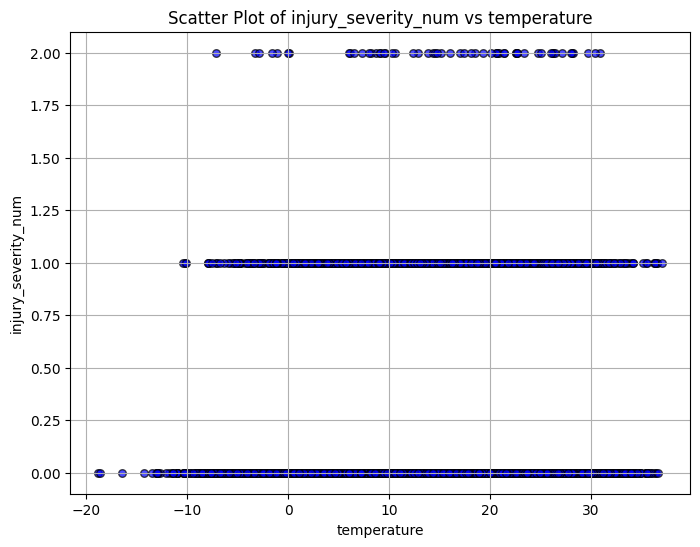

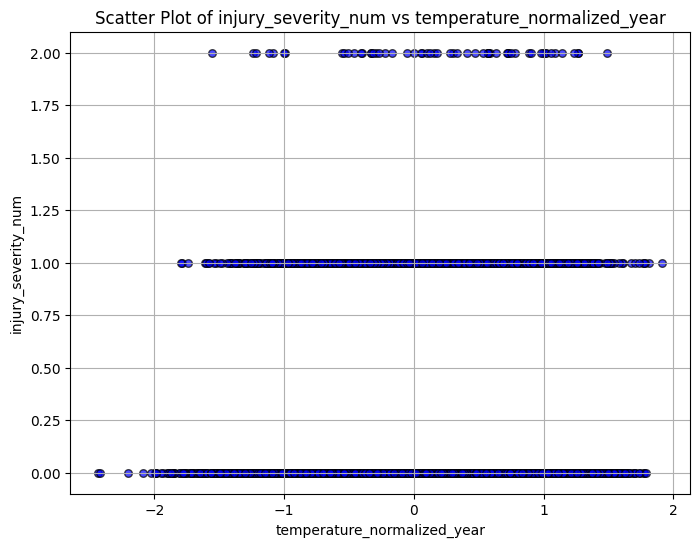

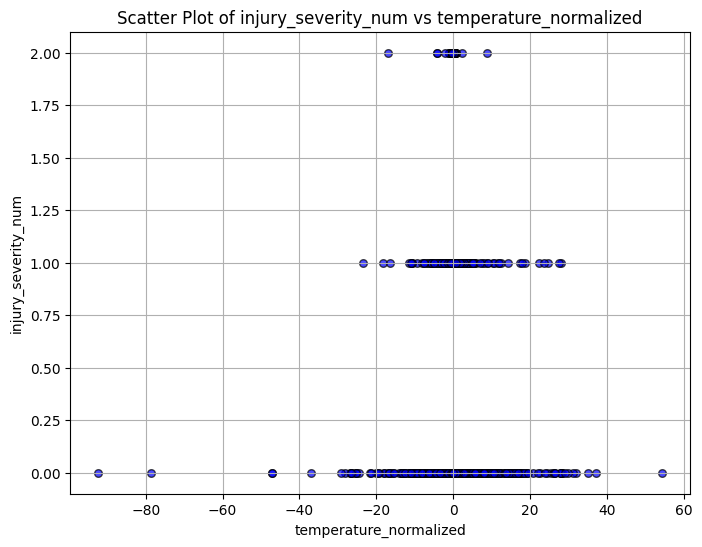

In [107]:

plot_scatter(dataset, 'temperature', 'injury_severity_num')
plot_scatter(dataset, 'temperature_normalized_year', 'injury_severity_num')
plot_scatter(dataset, 'temperature_normalized', 'injury_severity_num')



- Scatter Plot of injury_severity_num vs temperature (°C)

In the first plot, injury_severity_num is plotted against raw temperature values. No strong linear trend is observable; the injury severity seems largely invariant across the observed range of temperatures. The temperature range spans approximately -20°C to 35°C, with most data points concentrated between 0°C and 30°C.

- Scatter Plot of injury_severity_num vs temperature_normalized

- Scatter Plot of injury_severity_num vs temperature_normalized_year

In the third plot, temperature is further normalized on a yearly basis. The range of the normalized temperature is constrained approximately between -2 and 2. The ordinal clustering of injury severity levels persists, with no evident linear trend, which implies that yearly normalization does not substantially alter the observed association between temperature and injury severity. 

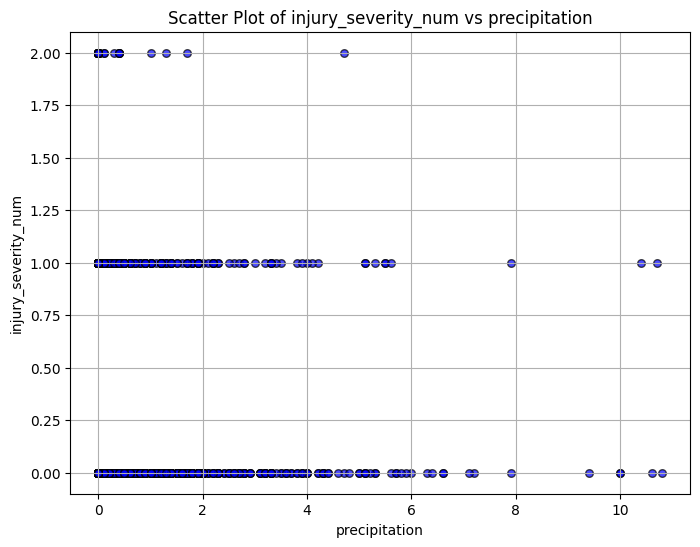

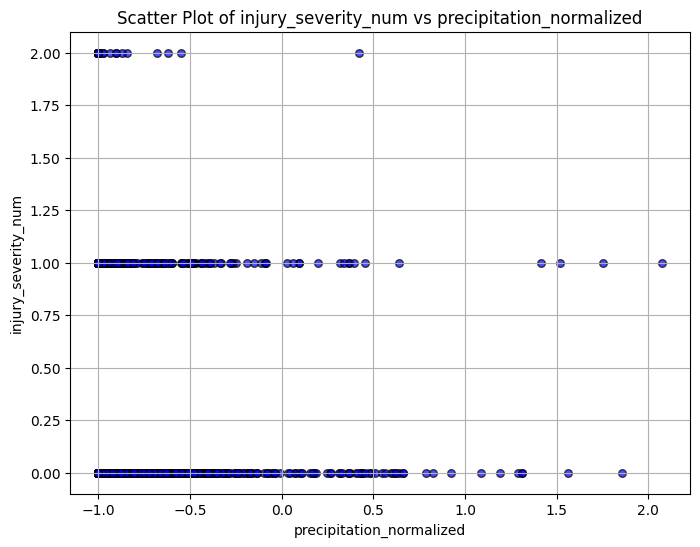

In [83]:

plot_scatter(dataset, 'precipitation', 'injury_severity_num')
plot_scatter(dataset, 'precipitation_normalized', 'injury_severity_num')


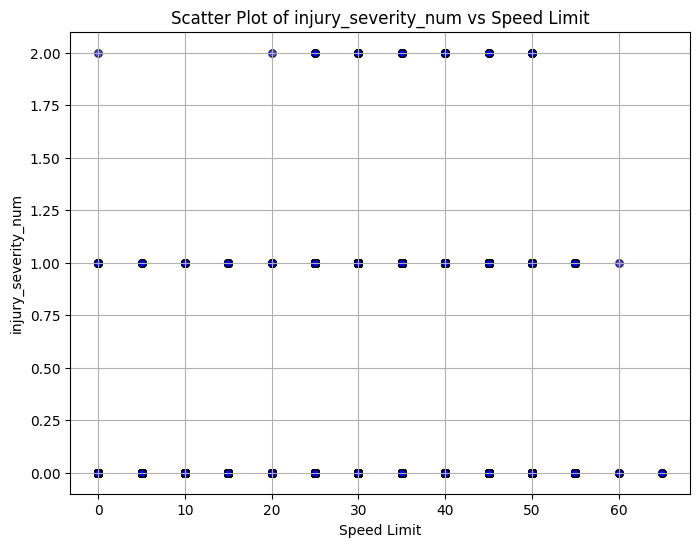

In [84]:

plot_scatter(dataset, 'Speed Limit', 'injury_severity_num')


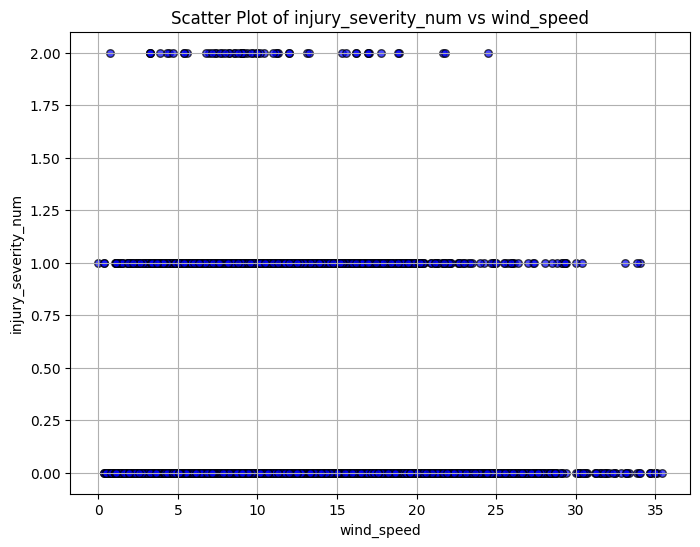

In [85]:
plot_scatter(dataset, 'wind_speed', 'injury_severity_num')


### Analysis Using Grouped Bar Plots

Using grouped bar plots allows us to compare categorical variables across different groups simultaneously. By presenting the counts or proportions side by side, we can quickly identify patterns, disparities, or trends across categories. We expect this method to highlight which conditions are associated with higher frequencies of severe accidents providing a clear visual foundation for subsequent statistical analyses.

In [ ]:


def grouped_barplot_proportion(df, numeric_col, category_col, bins=None, bin_labels=None, color_palette=None):
    """
    Plot a stacked bar chart showing proportions of a categorical variable for each numeric bin.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset
    numeric_col : str
        Numeric variable to bin (e.g., 'Speed Limit')
    category_col : str
        Categorical variable (e.g., 'injury_severity_ord')
    bins : list or int, optional
        Bins for numeric variable (default: no binning)
    bin_labels : list, optional
        Labels for bins (default: generated automatically)
    color_palette : list, optional
        Colors for each category (default matplotlib)
    """
    # Bin numeric variable if bins are provided
    if bins is not None:
        df['numeric_bin'] = pd.cut(df[numeric_col], bins=bins, labels=bin_labels, include_lowest=True)
    else:
        df['numeric_bin'] = df[numeric_col]

    # Pivot table: counts
    pivot = df.pivot_table(index='numeric_bin', columns=category_col, aggfunc='size', fill_value=0)

    # Convert counts to proportions per row
    pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot stacked bar chart
    pivot_prop.plot(kind='bar', stacked=True, figsize=(12,6), width=0.8, color=color_palette, edgecolor='black')
    plt.xlabel(numeric_col)
    plt.ylabel('Proportion')
    plt.title(f'Stacked proportion of {category_col} for each {numeric_col}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title=category_col)
    plt.show()


#### Case of speed limit (using the sampled dataset)

In [ ]:
speed_bins = [0, 20, 30, 40, 50, 60, 70, 80]
speed_labels = ['0-20','20-30','30-40','40-50','50-60','60-70','70-80']

grouped_barplot_proportion(
    dataset,
    numeric_col='Speed Limit',
    category_col='injury_severity_num',
    bins=speed_bins,
    bin_labels=speed_labels,
    color_palette=['green','orange','red']
)


We observe that for the Speed Limit variable, severe accidents are concentrated on roads with speed limits of 40 to 50 mph (approximately 64 to 80 km/h). In contrast, roads with lower speed limits experience fewer severe accidents, consistent with the physical relationship between speed and collision severity. Finally, roads with higher speed limits correspond to highways, which are typically engineered with safety features designed to reduce the risk of accidents.

#### Case of speed limit (using the total dataset)

In [ ]:
speed_bins = [0, 20, 30, 40, 50, 60, 70, 80]
speed_labels = ['0-20','20-30','30-40','40-50','50-60','60-70','70-80']

grouped_barplot_proportion(
    bigbase_final,
    numeric_col='Speed Limit',
    category_col='injury_severity_num',
    bins=speed_bins,
    bin_labels=speed_labels,
    color_palette=['green','orange','red']
)

For the full (non-sampled) dataset, the same trend is observed, although there is a slightly higher number of severe accidents on roads with higher speed limits.

#### Case of temperature

In [ ]:
# Définir des bins pour la température (ajuste selon tes données)
temp_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # °C
temp_labels = ['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40']

grouped_barplot_proportion(
    dataset,
    numeric_col='temperature',
    category_col='injury_severity_num',  # ou 'injury_severity_ord'
    bins=temp_bins,
    bin_labels=temp_labels,
    color_palette=['green','orange','red','purple','brown']  # une couleur par niveau
)


We observe that temperature appears to influence accident severity primarily at very high temperatures, exceeding 35 °C.

## III.6 Weather and number of car crashes par day <a id="crashes_per_day"></a>


To investigate the relationship between daily accident counts and meteorological conditions, we first aggregate the dataset at the day level. The timestamp of each accident is converted to a standardized datetime format, from which we extract the calendar date. We then compute the total number of accidents observed each day, generating a new variable, Accidents_per_day, which serves as the primary outcome for subsequent analyses.

Next, we summarize the daily meteorological variables, such as temperature and precipitation, by computing their daily averages, including both raw and normalized values. This aggregation produces a daily-level dataset that aligns the temporal resolution of the weather data with the count of accidents.

Scatter plots of normalized temperature and precipitation against daily accident counts are then generated to provide an initial visual assessment of potential relationships. This approach allows us to detect trends, patterns, or nonlinear effects, and to identify days with unusually high accident rates relative to weather conditions. We expect these analyses to reveal whether extreme temperatures or precipitation levels correspond to increases in daily accident counts, providing a descriptive foundation for more formal count-based modeling in subsequent steps.

In [ ]:

dataset['Crash Date/Time'] = pd.to_datetime(dataset['Crash Date/Time'], errors='coerce')

dataset['Crash Date'] = dataset['Crash Date/Time'].dt.date

dataset['Accidents_per_day'] = dataset.groupby('Crash Date')['Crash Date'].transform('count')

dataset[['Crash Date', 'Accidents_per_day','temperature',]].head(10)


In [ ]:
dataset["Accidents_per_day"].value_counts()

In [ ]:
df_daily = dataset.groupby('Crash Date').agg({
    'Accidents_per_day': 'max',      # total accidents ce jour
    'temperature': 'mean',
    'temperature_normalized_year': 'mean',
    'precipitation': 'mean',
    'precipitation_normalized': 'mean'             
}).reset_index()

df_daily.head()

In [ ]:
plot_scatter(df_daily, 'temperature_normalized_year', 'Accidents_per_day')
plot_scatter(df_daily, 'precipitation_normalized', 'Accidents_per_day')


# IV. Modeling <a id="modeling"></a>

Regression-based methods are used to quantify the causal effect of weather on accident risk.


## IV.1 Standardization of Variables (Centering and Scaling) <a id="centrage"></a>


This process ensures that variables measured on different scales contribute comparably to the analysis, facilitates the interpretation of coefficients, and improves numerical stability during model fitting.

In [ ]:

def center_and_scale(df, columns):
    """
    Centre et réduit les colonnes numériques d'un DataFrame.
    
    Paramètres
    ----------
    df : pandas.DataFrame
        Dataset d'origine
    columns : list of str
        Noms des colonnes à standardiser
    
    Retour
    ------
    df_scaled : pandas.DataFrame
        Copie du DataFrame avec les colonnes standardisées
    stats : dict
        Moyenne et écart-type utilisés (utile pour interprétation ou inverse transform)
    """
    df_scaled = df.copy()
    stats = {}

    for col in columns:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()

        # Sécurité : éviter division par zéro
        if std == 0 or pd.isna(std):
            raise ValueError(f"La colonne {col} a un écart-type nul ou invalide.")

        df_scaled[col] = (df_scaled[col] - mean) / std
        stats[col] = {"mean": mean, "std": std}

    return df_scaled, stats


In [ ]:
cols_to_scale = [
    'temperature',
    'wind_speed',
    'Vehicle Year',
    'day_or_night_code',
    'Speed Limit', 'temperature_normalized','temperature_normalized_year','temperature_normalized_year_abs','wind_speed_normalized','precipitation_normalized'
]

df_scaled, scaling_stats = center_and_scale(dataset, cols_to_scale)

print(df_scaled["injury_severity_num"].value_counts(),df_scaled["temperature"].value_counts())

In [ ]:
# Pearson correlation for numeric variables
numeric_cols = ['temperature', 'wind_speed', 'Vehicle Year', 'Speed Limit']
corr_matrix = dataset[numeric_cols].corr()
print(corr_matrix)


## IV.2 Multiple Linear Regression Analysis <a id="linear"></a>


In this section, we perform multiple linear regression to explore the relationships between driver and environmental variables (temperature, vehicle year, wind speed, day/night indicator, and speed limit—and the numerical measure of injury severity). This approach is relevant because it allows us to quantify the marginal effect of each explanatory variable while controlling for the others, providing insight into which factors are most strongly associated with accident severity. By comparing models using raw versus normalized variables, we also assess the robustness of these relationships to scaling differences. We expect the analysis to identify key predictors of injury severity, such as speed limit and extreme weather conditions, and to provide preliminary estimates that can inform more specialized models, including count-based or interaction-aware regressions.

In [ ]:



def linear_regression_multi(df, explanatory_vars, dependent_var, plot=True):
    """
    Perform a multiple linear regression (OLS) on several columns of a DataFrame
    and optionally plot the regression line for the first explanatory variable.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    explanatory_vars (list of str): List of independent variable column names
    dependent_var (str): Name of the dependent variable column
    plot (bool): Whether to plot the regression line for the first explanatory variable

    Returns:
    model: statsmodels OLS fitted model
    """
    # Clean the dataset for all columns
    for col in explanatory_vars + [dependent_var]:
        df = clean_column(df, col)

    # Select X and y
    X = df[explanatory_vars]
    y = df[dependent_var]

    # Add constant for intercept
    X = sm.add_constant(X)

    # Fit OLS regression
    model = sm.OLS(y, X).fit()

    # Print summary
    print(model.summary())
    
    return model

# Example usage:
explanatory_vars = ["temperature", "Vehicle Year", "wind_speed","day_or_night_code","Speed Limit"]
explanatory_vars_normalized = ["temperature_normalized_year", "Vehicle Year", "wind_speed_normalized","day_or_night_code","Speed Limit"]

dependent_variable = "injury_severity_num"

model = linear_regression_multi(df_scaled, explanatory_vars, dependent_variable, plot=False)
model = linear_regression_multi(df_scaled, explanatory_vars_normalized, dependent_variable, plot=False)


The model explains a relatively small portion of the variance in injury severity, as indicated by an R-squared value of 0.016, suggesting that additional unobserved factors likely contribute to accident severity.

Among the predictors, Speed Limit exhibits the strongest positive association with injury severity (coef. ≈ 0.0485, p < 0.001), indicating that higher speed limits are associated with more severe accidents. Temperature and Vehicle Year also show small but statistically significant positive effects (p < 0.05), suggesting that higher temperatures may slightly increase injury severity. In contrast, wind speed and day/night code do not appear to have a significant effect in this model, with p-values well above conventional significance thresholds.

In these results, both normalized and non-normalized versions of the temperature and wind speed variables yield very similar coefficient estimates and significance levels. The normalization centers the variables relative to their annual averages, facilitating comparison across different time periods. Despite this transformation, the substantive interpretation of the results remains largely unchanged.

## IV.3 Ordinal Regression Analysis (Ordered Logit / Probit) <a id="ordinal"></a>


To better account for the ordinal nature of injury severity, we implement an ordinal regression model using either the logit or probit link function. Unlike classical linear regression, which treats the dependent variable as continuous, ordinal regression explicitly models the probability of an observation falling into each ordered category of the response variable.

This approach is particularly relevant in our context because injury severity is recorded on a discrete, ordered scale. We expect the ordinal model to provide more accurate estimates of how each factor shifts the likelihood of more severe accidents, capturing nonlinearities in the transition between severity levels. Compared to the linear regression results, we anticipate clearer differentiation between the effects of predictors, particularly for variables with small or moderate impacts, and more interpretable coefficients in terms of probabilities of being in higher severity categories rather than absolute numerical differences.

In [ ]:
from sklearn.preprocessing import StandardScaler
from statsmodels.miscmodels.ordinal_model import OrderedModel

def run_ordered_logit(
    df,
    y_col,
    x_cols,
    distr='logit',
    standardize=True,
    dropna=True,
    method='bfgs',
    disp=False
):
    """
    Run an ordinal regression model (Ordered Logit or Ordered Probit).

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset
    y_col : str
        Name of the dependent (ordinal) variable
    x_cols : list of str
        List of explanatory variables
    distr : str
        Distribution to use: 'logit' (default) or 'probit'
    standardize : bool
        Whether to standardize explanatory variables (recommended)
    dropna : bool
        Whether to drop rows with missing values
    method : str
        Optimization method used by statsmodels
    disp : bool
        Whether to display optimization output

    Returns
    -------
    result : statsmodels object
        Fitted ordinal regression results
    """

    # Select relevant columns
    cols = x_cols + [y_col]
    data = df[cols].copy()

    # Drop rows with missing values
    if dropna:
        data = data.dropna()

    # Separate explanatory variables and target variable
    X = data[x_cols]
    y = data[y_col]

    # Standardize explanatory variables
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Define the ordinal regression model
    model = OrderedModel(
        y,
        X,
        distr=distr
    )

    # Fit the model
    result = model.fit(method=method, disp=disp)

    return result


In [ ]:
x_vars = [
    'temperature_normalized_year',
    'wind_speed',
    'Vehicle Year',
    'day_or_night_code', 'Speed Limit'
]

x_vars2 = [
    'temperature',
    'wind_speed',
    'Vehicle Year',
    'day_or_night_code', 'Speed Limit'
]


result = run_ordered_logit(
    df=dataset,
    y_col='injury_severity_num',
    x_cols=x_vars
)

print(result.summary())

result = run_ordered_logit(
    df=dataset,
    y_col='injury_severity_num',
    x_cols=x_vars2
)

print(result.summary())


The ordinal regression model estimates the effects of explanatory variables on the likelihood of observing higher injury severity levels. Among the predictors, x5 (likely corresponding to Speed Limit) exhibits the strongest positive association with injury severity (coef. ≈ 0.356, p < 0.001), indicating that higher speed limits substantially increase the probability of more severe accidents. Both x1 and x3 (for instance, temperature and wind speed) are also positively associated with injury severity, with statistically significant coefficients, suggesting that extreme weather conditions may modestly raise the likelihood of more serious injuries. In contrast, x2 and x4 (e.g., Vehicle Year and day/night code) show no significant effect in this model.

## IV.4 Regression of Daily Accident Counts <a id="daily_reg"></a>


Assessing the impact of average daily temperature and precipitation on the number of accidents

In [ ]:
cols_to_scale = [
    'temperature',
    'temperature_normalized_year',
    'precipitation','precipitation_normalized',
    "Accidents_per_day"]

df_daily_scaled, scaling_stats = center_and_scale(df_daily, cols_to_scale)


In [ ]:
experiment_3 = ["temperature","precipitation"]
experiment_4 = ["temperature_normalized_year", "precipitation_normalized"]

dependent_variable2 = "Accidents_per_day"

model = linear_regression_multi(df_daily_scaled, experiment_3, dependent_variable2, plot=False)
model = linear_regression_multi(df_daily_scaled, experiment_4, dependent_variable2, plot=False)


The OLS regression of daily accident counts on temperature and precipitation shows very low explanatory power (R² ≈ 0.001).
Neither temperature nor precipitation is statistically significant (p > 0.2).
Normalized variables yield similar results.
These findings indicate that linear regression is poorly suited for modeling daily accident counts.

## IV.5 Count-Based Modeling of Daily Accident Frequency <a id="count"></a>


We adopt an experimental approach based on count models, specifically Poisson regression, which are explicitly designed to model variables corresponding to the number of events observed over a given period. 

To better characterize the potentially nonlinear relationship between weather conditions and accident frequency,  temperature and speed limit are discretized. This transformation allows us to reason in terms of differential exposure to risk under different weather conditions while preserving a clear interpretation of relative effects. 

The objective of this approach is thus to test the hypothesis that certain meteorological conditions are associated with a significant increase in the number of accidents, within a modeling framework consistent with the nature of the data and the mechanisms underlying the studied phenomenon.

In [ ]:
df = dataset.copy()

# Create temperature bins
df["temp_bin"] = pd.cut(
    df["temperature"],
    bins=[-20, 0, 5, 10, 15, 20, 30, 50]
)

# Convert Crash Date/Time to datetime
df["Crash_DateTime"] = pd.to_datetime(
    df["Crash Date/Time"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)

# Extract useful date components
df["date"] = df["Crash_DateTime"].dt.date
df["hour"] = df["Crash_DateTime"].dt.hour
df["month"] = df["Crash_DateTime"].dt.month
df["weekday"] = df["Crash_DateTime"].dt.weekday  # 0 = Monday

# Aggregate by date, temperature bin, and speed limit
agg = (
    df
    .groupby(["date", "temp_bin", "Speed Limit"])
    .size()
    .reset_index(name="accidents")
)

# Check the first rows
agg.head()


In [ ]:

agg = agg.rename(columns={"Speed Limit": "Speed_Limit"})

poisson_model = smf.glm(
    formula="accidents ~ C(temp_bin) + C(Speed_Limit)",
    data=agg,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())
